
Rastrigin: 2D


In [1]:
pip install pyGPGO


  Created wheel for pyGPGO: filename=pyGPGO-0.5.1-py3-none-any.whl size=19879 sha256=1bdb0173d2dcf277de18b26d857564eb00f3bf0be85f460d9e71ed8eb9300c0d
  Stored in directory: /root/.cache/pip/wheels/c8/5d/0b/2160114e2f1b87791c51b66cf07f89831dbb6f49167950316f
Successfully built pyGPGO


In [2]:
### Import:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import itertools

from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from joblib import Parallel, delayed
from numpy.linalg import solve, cholesky
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from scipy.stats import norm
import time

warnings.filterwarnings("ignore", category=RuntimeWarning)


In [3]:
### Inputs:

func = 'Rastrigin'
n_test = 500
eps = 1e-08

util = 'EI'

n_init = 5 # random initialisations
iters = 20
opt = True

In [4]:
### Objective Function - Rastrigin(x) 2-D:

def objfunc(x1_training, x2_training):
        return  operator * (10 * dim + x1_training** 2 - 10 * np.cos(2 * np.pi * x1_training)
                                    + x2_training** 2 - 10 * np.cos(2 * np.pi * x2_training)
                          )
            
# Constraints:
lb = -5.12 
ub = +5.12
    
# Input array dimension(s):
dim = 2

# 2-D inputs' parameter bounds:
param = {'x1_training': ('cont', [lb, ub]),
             'x2_training': ('cont', [lb, ub])}

# True y bounds:
operator = -1
y_global_orig = 0 # targets global minimum

# Test data:
x1_test = np.linspace(lb, ub, n_test) 
x2_test = np.linspace(lb, ub, n_test)
  
x_test = np.column_stack((x1_test,x2_test))


In [5]:
n_start_AcqFunc = iters


In [6]:
### Cumulative Regret Calculators:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list
  
def acqFuncExact(x):
    new_array = []
    x = np.array(x) * -1
    for i, num in enumerate(x):
            new_array = x[:-2][::-3]
    return new_array[::-1]

def acqFuncApprox(x):
    new_array = []
    x = np.array(x) * -1
    for i, num in enumerate(x):
            new_array = x[:-1][::-3]
    return new_array[::-1]


In [7]:
### Surrogate derivatives: 

cov_func = squaredExponential()

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)
   
def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE
    
    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the GP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        
        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)
        
        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds           


In [8]:
### Add exact acquisition function gradient as attribute:

class Acquisition_grad(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'EI': self.EI
        }

        self.f = mode_dict[mode]
    
    def EI(self, tau, mean, std, ds, dm):
        gamma = (mean - tau - self.eps) / (std + self.eps)
        gamma_h = (mean - tau) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)
        
        f = (std + self.eps) * (gamma * norm.cdf(gamma) + norm.pdf(gamma))
        df1 = f / (std + self.eps) * dsdx 
        df2 = (std + self.eps) * norm.cdf(gamma) * dmdx
        df = (df1 + df2)[0]
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval(self, tau, mean, std, ds, dm):
    
        return self.f(tau, mean, std, ds, dm, **self.params)
        

In [9]:
## GPGO_multi: 

class GPGO_multi(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t         Max. ExactAcqFunc \t Max. ApproxAcqFunc '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'
 
    def acqfuncExact(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df
   
    def acqfuncApprox(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f
   
    def _optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr        
        self.history.append(self.f_best_min)

        x_best_exact = np.empty((n_start, len(self.parameter_key)))
        f_best_exact = np.empty((n_start,))
        opt_exact = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best_exact = np.array([res.x for res in opt_exact])
        f_best_exact = np.array([np.atleast_1d(res.fun)[0] for res in opt_exact])
        f_best_min_exact = min(f_best_exact)

        self.x_best_exact = x_best_exact
        self.f_best_exact = f_best_exact
        self.f_best_min_exact = f_best_min_exact
        self.best_exact = x_best_exact[np.argmin(f_best_exact)]
        self.start_points_arr = start_points_arr
        self.history.append(self.f_best_min_exact)

    def _printInit(self):
        print(self.header)
        inverse = -1
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        inverse = -1
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        max_acqfunc = str(inverse * self.f_best_min)
        max_acqfunc_exact = str(inverse * self.f_best_min_exact)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            max_acqfunc = BOLD + OKGREEN + max_acqfunc + ENDC
            max_acqfunc_exact = BOLD + OKGREEN + max_acqfunc_exact + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, max_acqfunc_exact, max_acqfunc))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [10]:
## dGPGO:

class dGPGO(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t         Max. ExactAcqFunc \t Max. ApproxAcqFunc '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'

    def acqfuncExact(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df
   
    def acqfuncApprox(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.history.append(self.f_best_min)

        x_best_approx = np.empty((n_start, len(self.parameter_key)))
        f_best_approx = np.empty((n_start,))
        opt_approx = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best_approx = np.array([res.x for res in opt_approx])
        f_best_approx = np.array([np.atleast_1d(res.fun)[0] for res in opt_approx])
        f_best_min_approx = min(f_best_approx)

        self.x_best_approx = x_best_approx
        self.f_best_approx = f_best_approx
        self.f_best_min_approx = f_best_min_approx
        self.best_approx = x_best_approx[np.argmin(f_best_approx)]
        self.start_points_arr = start_points_arr
        self.history.append(self.f_best_min_approx)
    
    def _printInit(self):
        print(self.header)
        inverse = -1
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        inverse = -1
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        max_acqfunc = str(inverse * self.f_best_min)
        max_acqfunc_approx = str(inverse * self.f_best_min_approx)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            max_acqfunc = BOLD + OKGREEN + max_acqfunc + ENDC
            max_acqfunc_approx = BOLD + OKGREEN + max_acqfunc_approx + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, max_acqfunc, max_acqfunc_approx))

    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [11]:
###Reproducible set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [12]:
start_approx = time.time()
start_approx


1653141477.2095063

In [13]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_1)
surrogate_approx_1 = dGaussianProcess(cov_func, optimize=opt)

approx_1 = GPGO_multi(surrogate_approx_1, Acquisition_grad(util), objfunc, param)
approx_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-0.84969467  2.25612281]	 20.33436270766351	 19.908403246996286	    	    
init	 [-5.1188288  -2.02411446]	 33.07414982069084	 19.908403246996286	    	    
init	 [-3.61721968 -4.17445279]	 53.347974723929894	 19.908403246996286	    	    
init	 [-3.21269544 -1.58145816]	 39.218472310354045	 19.908403246996286	    	    
init	 [-1.05710106  0.39748336]	 19.908403246996286	 19.908403246996286	    	    
1  	 [ 5.12 -5.12]	 57.849427451571785	 19.908403246996286	 19.908403236569633	 19.908403236996275
2  	 [4.60729025 5.12      ]	 67.96437441351335	 19.908403246996286	 19.90840323415899	 19.908403183897036
3  	 [-5.12  5.12]	 57.849427451571785	 19.908403246996286	 19.908294881384364	 19.908386159773798
4  	 [ 4.14371716 -0.05763721]	 21.629764732147287	 19.908403246996286	 19.908289147652493	 19.90829491257108
5  	 [ 0.90035873 -3.6886239 ]	 30.074692068191148	 19.9084032469962

In [14]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_2)
surrogate_approx_2 = dGaussianProcess(cov_func, optimize=opt)

approx_2 = GPGO_multi(surrogate_approx_2, Acquisition_grad(util), objfunc, param)
approx_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-0.6554122  -4.85451539]	 43.490296251903594	 18.964539418712707	    	    
init	 [ 0.50854377 -0.6622987 ]	 35.91861667536101	 18.964539418712707	    	    
init	 [-0.81543371 -1.73737143]	 20.479562046739524	 18.964539418712707	    	    
init	 [-3.02439799  1.2213347 ]	 18.964539418712707	 18.964539418712707	    	    
init	 [-2.05153614 -2.3876887 ]	 28.041315668371354	 18.964539418712707	    	    
1  	 [2.38606629 4.76477404]	 55.01468421587924	 18.964539418712707	 18.96453938815674	 18.964538211847795
2  	 [ 5.12 -5.12]	 57.849427451571785	 18.964539418712707	 18.964529239343356	 18.964538196136406
3  	 [5.12       0.46679287]	 48.925730883727155	 18.964539418712707	 18.964251074510273	 18.964251074436
4  	 [-5.12  5.12]	 57.849427451571785	 18.964539418712707	 18.96082338859467	 18.964011927182607
5  	 [-5.12 -5.12]	 57.849427451571785	 18.964539418712707	 18.960823388

In [15]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_3)
surrogate_approx_3 = dGaussianProcess(cov_func, optimize=opt)

approx_3 = GPGO_multi(surrogate_approx_3, Acquisition_grad(util), objfunc, param)
approx_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [0.52017052 2.1314337 ]	 27.953858411008774	 10.607662635789808	    	    
init	 [-2.14113547  0.11087468]	 10.607662635789808	 10.607662635789808	    	    
init	 [4.02377681 4.05804123]	 33.42749829480097	 10.607662635789808	    	    
init	 [-3.83400642 -2.99783293]	 28.650953928965198	 10.607662635789808	    	    
init	 [-4.59297584 -0.6061072 ]	 57.6631355589384	 10.607662635789808	    	    
1  	 [ 5.12       -3.02919362]	 38.26848737487875	 10.607662635789808	 10.607639236553297	 10.607662645167347
2  	 [-5.12  5.12]	 57.849427451571785	 10.607662635789808	 10.607539928532438	 10.607660548564983
3  	 [ 0.59616785 -5.12      ]	 47.50946877132776	 10.607662635789808	 10.596113223068063	 10.60750620043678
4  	 [ 1.6198372  -1.35910892]	 38.098734926981656	 10.607662635789808	 10.566347912557411	 10.56674700580002
5  	 [-1.23866698  5.12      ]	 39.74753681021736	 10.607662

In [16]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_4)
surrogate_approx_4 = dGaussianProcess(cov_func, optimize=opt)

approx_4= GPGO_multi(surrogate_approx_4, Acquisition_grad(util), objfunc, param)
approx_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [4.78238555 0.48365823]	 51.03163809010808	 14.323038259018315	    	    
init	 [4.84028785 2.19971578]	 39.78645699016559	 14.323038259018315	    	    
init	 [ 2.02474316 -2.90724357]	 14.323038259018315	 14.323038259018315	    	    
init	 [ 4.87705042 -5.05620219]	 52.80627247106233	 14.323038259018315	    	    
init	 [-2.52946061 -0.66773471]	 41.61497868486559	 14.323038259018315	    	    
1  	 [-5.12  5.12]	 57.849427451571785	 14.323038259018315	 14.323037154731137	 14.323038210382029
2  	 [0.36083895 5.12      ]	 45.469685467793816	 14.323038259018315	 14.323018900412448	 14.323018900447135
3  	 [-5.12 -5.12]	 57.849427451571785	 14.323038259018315	 14.323002230148575	 14.323002230148575
4  	 [-0.95955547 -5.12      ]	 30.166612693168744	 14.323038259018315	 14.287364580727377	 14.310508764675385
5	 [0.85386022 1.14518979]	 9.848565927769162	 9.848565927769162	 14.16

In [17]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_5)
surrogate_approx_5 = dGaussianProcess(cov_func, optimize=opt)

approx_5 = GPGO_multi(surrogate_approx_5, Acquisition_grad(util), objfunc, param)
approx_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-2.84678993  3.79629882]	 33.93442008827236	 7.8108627039749745	    	    
init	 [-3.00319585  4.2865757 ]	 39.673876075575784	 7.8108627039749745	    	    
init	 [-0.11866943  1.14425716]	 7.8108627039749745	 7.8108627039749745	    	    
init	 [2.72289645 0.1886002 ]	 25.38160395721669	 7.8108627039749745	    	    
init	 [-2.08076286 -3.19773462]	 22.589982116319675	 7.8108627039749745	    	    
1  	 [ 5.12       -4.99221608]	 53.85889262633622	 7.8108627039749745	 7.810881347216296	 7.810883273706283
2  	 [5.12 5.12]	 57.849427451571785	 7.8108627039749745	 7.810880583399054	 7.810880583399054
3  	 [-5.12       -0.04626534]	 29.346401473652964	 7.8108627039749745	 7.808937737416248	 7.809482539503194
4  	 [1.00367536 5.12      ]	 29.93474424974604	 7.8108627039749745	 7.793946367039503	 7.797950818226047
5  	 [-5.12 -5.12]	 57.849427451571785	 7.8108627039749745	 7.79328

In [18]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_6)
surrogate_approx_6 = dGaussianProcess(cov_func, optimize=opt)

approx_6 = GPGO_multi(surrogate_approx_6, Acquisition_grad(util), objfunc, param)
approx_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 4.02288795 -1.72052679]	 31.08835710146886	 17.28954482757088	    	    
init	 [ 3.28938622 -4.69302655]	 58.797867722203385	 17.28954482757088	    	    
init	 [-4.0175956   0.97333314]	 17.28954482757088	 17.28954482757088	    	    
init	 [ 0.30532979 -0.83141193]	 19.296253155889353	 17.28954482757088	    	    
init	 [-1.68542362  1.25459899]	 28.650630936276173	 17.28954482757088	    	    
1  	 [5.12 5.12]	 57.849427451571785	 17.28954482757088	 17.28954481698576	 17.28954481698576
2  	 [-4.80259369 -4.71437125]	 64.26542863155163	 17.28954482757088	 17.289544778430603	 17.28954423527897
3  	 [-5.12  5.12]	 57.849427451571785	 17.28954482757088	 17.288218848125762	 17.288698462495336
4  	 [0.39537661 5.12      ]	 46.99706773057963	 17.28954482757088	 17.288210707238278	 17.28821160659021
5  	 [-0.74584862 -5.12      ]	 39.74181351109142	 17.28954482757088	 17.266711545

In [19]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_7)
surrogate_approx_7 = dGaussianProcess(cov_func, optimize=opt)

approx_7 = GPGO_multi(surrogate_approx_7, Acquisition_grad(util), objfunc, param)
approx_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-4.33860312  2.86636843]	 45.646133072936244	 22.52235437888213	    	    
init	 [-0.63068947  2.28828342]	 34.83012662845338	 22.52235437888213	    	    
init	 [4.8946126  0.39419771]	 44.09657005662876	 22.52235437888213	    	    
init	 [ 0.01147355 -4.38219639]	 36.613209822404315	 22.52235437888213	    	    
init	 [-2.37118484e+00 -1.20319155e-03]	 22.52235437888213	 22.52235437888213	    	    
1  	 [-5.12 -5.12]	 57.849427451571785	 22.52235437888213	 22.5223271525891	 22.5223271525891
2  	 [ 5.12 -5.12]	 57.849427451571785	 22.52235437888213	 22.522177196868483	 22.522318976237948
3  	 [3.59519658 5.12      ]	 60.11400890618464	 22.52235437888213	 22.522171077175976	 22.522178731773916
4  	 [-4.02558214 -1.33646422]	 33.289738493146906	 22.52235437888213	 22.52235436888213	 22.52235436888213
5	 [ 1.40596198 -0.96125084]	 21.500283080921378	 21.500283080921378	 22.463

In [20]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_8)
surrogate_approx_8 = dGaussianProcess(cov_func, optimize=opt)

approx_8 = GPGO_multi(surrogate_approx_8, Acquisition_grad(util), objfunc, param)
approx_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [3.82391708 4.79785639]	 50.20079446939181	 13.871821018360485	    	    
init	 [3.78055209 0.31596228]	 36.5114251593508	 13.871821018360485	    	    
init	 [-2.73686192 -5.00327624]	 43.34985765011677	 13.871821018360485	    	    
init	 [-0.7119993  -0.99992207]	 13.871821018360485	 13.871821018360485	    	    
init	 [ 0.23218863 -0.22126801]	 17.190590355445654	 13.871821018360485	    	    
1  	 [-5.12  5.12]	 57.849427451571785	 13.871821018360485	 13.871804552259617	 13.87182100835591
2  	 [ 5.12 -5.12]	 57.849427451571785	 13.871821018360485	 13.871799791089153	 13.871818156847137
3  	 [-5.12       -0.06374542]	 29.720210105624936	 13.871821018360485	 13.870551889463057	 13.871565590954381
4  	 [-0.66934534  4.17609807]	 38.26303623050173	 13.871821018360485	 13.869540159329253	 13.869722654714254
5  	 [ 1.18397091 -4.40957845]	 45.24448966701673	 13.871821018360485	 

In [21]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_9)
surrogate_approx_9 = dGaussianProcess(cov_func, optimize=opt)

approx_9 = GPGO_multi(surrogate_approx_9, Acquisition_grad(util), objfunc, param)
approx_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-5.01376866  0.01919582]	 25.248289026162446	 24.454800313488693	    	    
init	 [-0.04328148 -3.74958562]	 24.454800313488693	 24.454800313488693	    	    
init	 [-3.66478248 -2.88195916]	 39.46509426509438	 24.454800313488693	    	    
init	 [-0.83447623 -2.57944404]	 31.06766397812992	 24.454800313488693	    	    
init	 [-4.25922917 -1.58209393]	 49.922543556206975	 24.454800313488693	    	    
1  	 [3.51080105 5.12      ]	 61.22741827329939	 24.454800313488693	 24.454800303488692	 24.454800303488692
2  	 [ 5.12       -0.52804179]	 49.0487252552488	 24.454800313488693	 24.454799528651524	 24.454799190264318
3  	 [-2.51307674  5.12      ]	 55.20653314176944	 24.454800313488693	 24.454773367582575	 24.45479887875186
4  	 [ 4.6746987 -5.12     ]	 65.33428637822472	 24.454800313488693	 24.45260172774946	 24.45415863270791
5  	 [0.58132326 1.56232803]	 40.744440457370196	 2

In [22]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_10)
surrogate_approx_10 = dGaussianProcess(cov_func, optimize=opt)

approx_10 = GPGO_multi(surrogate_approx_10, Acquisition_grad(util), objfunc, param)
approx_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 2.77832339 -4.90750004]	 41.674330194390116	 13.839458310244165	    	    
init	 [1.36855793 2.54775176]	 44.69639719065837	 13.839458310244165	    	    
init	 [-0.01528819 -2.81808235]	 13.839458310244165	 13.839458310244165	    	    
init	 [-3.09183626  2.66783449]	 33.23221510904937	 13.839458310244165	    	    
init	 [-3.38830503 -4.2154003 ]	 54.73014366983691	 13.839458310244165	    	    
1  	 [ 5.12       -0.56819479]	 48.34354032374067	 13.839458310244165	 13.839193299462396	 13.839194745163578
2  	 [5.12 5.12]	 57.849427451571785	 13.839458310244165	 13.838737393896949	 13.838737393896949
3  	 [-5.12       -0.60617696]	 47.14817388107489	 13.839458310244165	 13.767410946666615	 13.820401586557528
4  	 [-5.12  5.12]	 57.849427451571785	 13.839458310244165	 13.4966189368752	 13.73441165615301
5  	 [-0.83794347  5.12      ]	 34.37813959228219	 13.839458310244165	 13

In [23]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_11)
surrogate_approx_11 = dGaussianProcess(cov_func, optimize=opt)

approx_11 = GPGO_multi(surrogate_approx_11, Acquisition_grad(util), objfunc, param)
approx_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-3.27403839 -4.92057353]	 47.655641290890955	 10.679755252484755	    	    
init	 [-0.37664229  2.30332343]	 35.87889240695259	 10.679755252484755	    	    
init	 [-0.81711509 -0.14922651]	 10.679755252484755	 10.679755252484755	    	    
init	 [-4.98912446 -0.12931474]	 28.05462905574235	 10.679755252484755	    	    
init	 [4.52410012 3.59214172]	 71.62694632141611	 10.679755252484755	    	    
1  	 [ 5.12       -4.19757366]	 53.30954297406896	 10.679755252484755	 10.67975494666741	 10.679755258820743
2  	 [-5.12  5.12]	 57.849427451571785	 10.679755252484755	 10.667691690722592	 10.679736422670041
3  	 [ 0.96008561 -5.12      ]	 30.1593101839877	 10.679755252484755	 10.673719214252126	 10.673719223953665
4  	 [ 3.08642682 -0.51789934]	 31.16963553049775	 10.679755252484755	 10.669109138683778	 10.670015724738233
5  	 [1.20979321 5.12      ]	 37.888831587583496	 10.679755

In [24]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_12)
surrogate_approx_12 = dGaussianProcess(cov_func, optimize=opt)

approx_12 = GPGO_multi(surrogate_approx_12, Acquisition_grad(util), objfunc, param)
approx_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-3.54137249  2.45810889]	 57.903242869085595	 40.51116653209555	    	    
init	 [-2.42365424  0.34549139]	 40.51116653209555	 40.51116653209555	    	    
init	 [-4.97075238  4.28796936]	 55.62655915398208	 40.51116653209555	    	    
init	 [ 4.10332011 -4.77776458]	 49.962803461970296	 40.51116653209555	    	    
init	 [ 4.6791612  -3.71497655]	 62.183891474990624	 40.51116653209555	    	    
1  	 [5.12 5.12]	 57.849427451571785	 40.51116653209555	 40.51116652209555	 40.51116652209555
2  	 [-5.12 -5.12]	 57.849427451571785	 40.51116653209555	 40.511166354596	 40.511166354596
3	 [2.51316601 0.83223596]	 32.03425372922798	 32.03425372922798	 40.51085659049695	 40.5108964825321
4  	 [0.33253279 5.12      ]	 43.99166812264413	 32.03425372922798	 32.033224164417845	 32.03333946824885
5  	 [-0.48617459 -4.11915504]	 39.840171729291015	 32.03425372922798	 32.03329345020354	 32.0

In [25]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_13)
surrogate_approx_13 = dGaussianProcess(cov_func, optimize=opt)

approx_13 = GPGO_multi(surrogate_approx_13, Acquisition_grad(util), objfunc, param)
approx_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 2.84367268 -2.68757791]	 33.58019830007169	 17.435826639425656	    	    
init	 [3.32061217 4.76927179]	 56.857057997503354	 17.435826639425656	    	    
init	 [ 4.83943541 -0.47667971]	 48.211919361679726	 17.435826639425656	    	    
init	 [1.11659482 2.82139151]	 17.435826639425656	 17.435826639425656	    	    
init	 [1.45012065 2.27346667]	 38.25352329493884	 17.435826639425656	    	    
1  	 [-5.12       -2.72662604]	 47.82255875853998	 17.435826639425656	 17.43582662942564	 17.435826629425343
2  	 [-5.12  5.12]	 57.849427451571785	 17.435826639425656	 17.435798686617552	 17.435826629045824
3  	 [-1.07699711 -5.12      ]	 31.23223902581529	 17.435826639425656	 17.43503492676786	 17.43504492040609
4	 [-2.85655888  1.12634699]	 16.211447268203663	 16.211447268203663	 17.428329239819544	 17.43296598397259
5  	 [-1.15488876  5.12      ]	 34.63186840715162	 16.21144726820

In [26]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_14)
surrogate_approx_14 = dGaussianProcess(cov_func, optimize=opt)

approx_14 = GPGO_multi(surrogate_approx_14, Acquisition_grad(util), objfunc, param)
approx_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [0.14277984 2.79721013]	 18.683085263052178	 10.423838604848608	    	    
init	 [ 3.7931795  -5.03759925]	 47.36348784446708	 10.423838604848608	    	    
init	 [-1.94830412  4.68586229]	 40.19779334078636	 10.423838604848608	    	    
init	 [ 0.13431513 -1.86076749]	 10.423838604848608	 10.423838604848608	    	    
init	 [ 0.40140736 -2.85434939]	 30.353548735049138	 10.423838604848608	    	    
1  	 [-5.12 -5.12]	 57.849427451571785	 10.423838604848608	 10.423838349238634	 10.423838349238634
2  	 [5.12 5.12]	 57.849427451571785	 10.423838604848608	 10.423836054052794	 10.423836054052794
3  	 [-5.12        0.35579362]	 45.219697928142004	 10.423838604848608	 10.423818065806698	 10.423818065791163
4  	 [ 5.12       -0.06381356]	 29.721889000291867	 10.423838604848608	 10.423748898324018	 10.423748909813742
5  	 [-5.12  5.12]	 57.849427451571785	 10.423838604848608	 10.2722

In [27]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_15)
surrogate_approx_15 = dGaussianProcess(cov_func, optimize=opt)

approx_15 = GPGO_multi(surrogate_approx_15, Acquisition_grad(util), objfunc, param)
approx_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 3.57189322 -3.28810573]	 54.938487770767075	 7.990765314336182	    	    
init	 [-4.56332069 -1.41784631]	 60.750198753157726	 7.990765314336182	    	    
init	 [-2.29989449  0.3072023 ]	 31.984997246800887	 7.990765314336182	    	    
init	 [-1.9873903  -2.00218256]	 7.990765314336182	 7.990765314336182	    	    
init	 [-3.97576933 -2.5610341 ]	 41.754957769694336	 7.990765314336182	    	    
1  	 [3.22352535 5.12      ]	 47.660038955332915	 7.990765314336182	 7.990779890199916	 7.990779890165227
2  	 [-5.12  5.12]	 57.849427451571785	 7.990765314336182	 7.990663671685265	 7.99077713723363
3  	 [5.12       1.00950276]	 29.961629259450355	 7.990765314336182	 7.986459800062187	 7.989125545338676
4  	 [-0.33203042 -5.12      ]	 43.963894196122205	 7.990765314336182	 7.981994680925024	 7.983218894808818
5  	 [-0.90983136  4.44647521]	 41.60113866833508	 7.990765314336182	 7.

In [28]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_16)
surrogate_approx_16 = dGaussianProcess(cov_func, optimize=opt)

approx_16 = GPGO_multi(surrogate_approx_16, Acquisition_grad(util), objfunc, param)
approx_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-2.83349935  0.23719262]	 22.27210456874814	 22.27210456874814	    	    
init	 [ 0.51918292 -4.65303603]	 57.57021076017139	 22.27210456874814	    	    
init	 [-1.42613673 -2.83565116]	 33.89145899403749	 22.27210456874814	    	    
init	 [ 1.9325559  -3.44339021]	 35.85029586225333	 22.27210456874814	    	    
init	 [-4.39987336  4.51595121]	 77.78800881964571	 22.27210456874814	    	    
1  	 [5.12 5.12]	 57.849427451571785	 22.27210456874814	 22.27210455874814	 22.27210455874814
2  	 [5.12       0.13359347]	 32.2634102746575	 22.27210456874814	 22.271828627969274	 22.271828639771474
3  	 [0.53980509 3.56722813]	 51.82642495204445	 22.27210456874814	 22.27151329603578	 22.271590617443536
4  	 [-5.12 -5.12]	 57.849427451571785	 22.27210456874814	 22.270777410706682	 22.270777410706682
5  	 [ 5.12 -5.12]	 57.849427451571785	 22.27210456874814	 22.146730433348374	 22.24783

In [29]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_17)
surrogate_approx_17 = dGaussianProcess(cov_func, optimize=opt)

approx_17 = GPGO_multi(surrogate_approx_17, Acquisition_grad(util), objfunc, param)
approx_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-2.10263037  0.31320838]	 20.395145364684023	 20.395145364684023	    	    
init	 [-3.15882714 -4.42470033]	 53.03732051200137	 20.395145364684023	    	    
init	 [2.93873111 1.60085526]	 29.989224812583537	 20.395145364684023	    	    
init	 [1.40821398 0.77417363]	 29.451989415882437	 20.395145364684023	    	    
init	 [-4.71999574 -1.45598869]	 55.89242173757483	 20.395145364684023	    	    
1  	 [ 5.12 -5.12]	 57.849427451571785	 20.395145364684023	 20.395145305707423	 20.39514535410384
2  	 [-5.12        5.04700552]	 54.82995879070466	 20.395145364684023	 20.395047780165285	 20.395143889498936
3  	 [-0.25145931  5.12      ]	 39.07963528683356	 20.395145364684023	 20.394497496983043	 20.39449785433406
4  	 [5.12 5.12]	 57.849427451571785	 20.395145364684023	 20.392568322496473	 20.392568322496473
5  	 [ 1.07732459 -3.51438454]	 34.627903225397255	 20.395145364684023	 2

In [30]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_18)
surrogate_approx_18 = dGaussianProcess(cov_func, optimize=opt)

approx_18 = GPGO_multi(surrogate_approx_18, Acquisition_grad(util), objfunc, param)
approx_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [1.53983224 0.05584255]	 22.67190580753611	 22.67190580753611	    	    
init	 [ 3.87687906 -3.25795609]	 38.990099416711985	 22.67190580753611	    	    
init	 [3.60686662 2.56139557]	 56.66448698782129	 22.67190580753611	    	    
init	 [1.70088108 4.99604939]	 40.894059318256296	 22.67190580753611	    	    
init	 [-2.48864335 -4.83014733]	 54.6725749848372	 22.67190580753611	    	    
1  	 [-5.12        2.10205643]	 35.329805712230566	 22.67190580753611	 22.671905797046726	 22.671905797155784
2  	 [-2.46249779  5.12      ]	 54.71227593611043	 22.67190580753611	 22.657512603055007	 22.66298980827792
3  	 [-2.31060644 -0.70591271]	 32.28865706538239	 22.67190580753611	 22.6439952492247	 22.654749728099297
4  	 [ 1.04805555 -5.12      ]	 30.47552603449096	 22.67190580753611	 22.550513228263	 22.55849899944511
5  	 [-5.12       -2.45342437]	 54.51885144131757	 22.671905807536

In [31]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_19)
surrogate_approx_19 = dGaussianProcess(cov_func, optimize=opt)

approx_19 = GPGO_multi(surrogate_approx_19, Acquisition_grad(util), objfunc, param)
approx_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-4.12125592  2.6751971 ]	 41.43485596167127	 25.867003842388073	    	    
init	 [-2.59135515 -3.70553152]	 51.60126035043229	 25.867003842388073	    	    
init	 [-1.72598719 -4.27008445]	 43.97430127029199	 25.867003842388073	    	    
init	 [1.76104531 3.13952049]	 25.867003842388073	 25.867003842388073	    	    
init	 [4.9432772  1.38916592]	 44.66580306903559	 25.867003842388073	    	    
1  	 [ 5.12 -5.12]	 57.849427451571785	 25.867003842388073	 25.866958859664855	 25.867003817800185
2  	 [ 1.77603451 -1.6863028 ]	 28.265626512765603	 25.867003842388073	 25.863429192078005	 25.86386966740578
3  	 [5.12 5.12]	 57.849427451571785	 25.867003842388073	 25.839686473620926	 25.839686473620926
4  	 [-1.28669673  5.12      ]	 42.8656497627398	 25.867003842388073	 25.82651237629454	 25.830755885522468
5  	 [-5.12       -0.97841422]	 29.97384127003042	 25.867003842388073	 25.5

In [32]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_20)
surrogate_approx_20 = dGaussianProcess(cov_func, optimize=opt)

approx_20 = GPGO_multi(surrogate_approx_20, Acquisition_grad(util), objfunc, param)
approx_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [0.9024594  4.07258857]	 20.24255447774017	 17.388691338534382	    	    
init	 [4.00927467 3.23417577]	 35.55852254546393	 17.388691338534382	    	    
init	 [-4.75249064  1.96359764]	 36.54582989269194	 17.388691338534382	    	    
init	 [-1.24230715  0.18955208]	 17.388691338534382	 17.388691338534382	    	    
init	 [ 1.61742301 -3.13497377]	 33.22932870179905	 17.388691338534382	    	    
1  	 [-5.12 -5.12]	 57.849427451571785	 17.388691338534382	 17.388691324429224	 17.388691324429224
2  	 [ 5.12       -0.92645578]	 30.831816007590838	 17.388691338534382	 17.383872698790483	 17.383879699258294
3  	 [ 5.12 -5.12]	 57.849427451571785	 17.388691338534382	 17.32000809412862	 17.381329865996687
4  	 [-2.7036894  5.12     ]	 49.10354331784983	 17.388691338534382	 17.29706431852983	 17.364569480344787
5  	 [-1.34011159 -5.12      ]	 46.08479947632442	 17.388691338534382	 17.

In [33]:
end_approx = time.time()
end_approx

time_approx = end_approx - start_approx
time_approx

start_exact = time.time()
start_exact

1653142757.7467935

In [34]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_1)
surrogate_exact_1 = dGaussianProcess(cov_func, optimize=opt)

exact_1 = dGPGO(surrogate_exact_1, Acquisition_grad(util), objfunc, param)
exact_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-0.84969467  2.25612281]	 20.33436270766351	 19.908403246996286	    	    
init	 [-5.1188288  -2.02411446]	 33.07414982069084	 19.908403246996286	    	    
init	 [-3.61721968 -4.17445279]	 53.347974723929894	 19.908403246996286	    	    
init	 [-3.21269544 -1.58145816]	 39.218472310354045	 19.908403246996286	    	    
init	 [-1.05710106  0.39748336]	 19.908403246996286	 19.908403246996286	    	    
1  	 [ 4.04077223 -4.24914728]	 44.655863836006326	 19.908403246996286	 19.908403236569633	 19.908403236996275
2  	 [5.12 5.12]	 57.849427451571785	 19.908403246996286	 19.90840323415899	 19.908403183873823
3  	 [4.33744349 0.432798  ]	 53.344410128242544	 19.908403246996286	 19.90766397882616	 19.90838615977363
4  	 [-5.12        4.36680096]	 64.69123843795754	 19.908403246996286	 19.90829130925116	 19.908386159779287
5  	 [ 0.15769158 -5.09614947]	 32.285447952253	 19.90840324

In [35]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_2)
surrogate_exact_2 = dGaussianProcess(cov_func, optimize=opt)

exact_2 = dGPGO(surrogate_exact_2, Acquisition_grad(util), objfunc, param)
exact_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-0.6554122  -4.85451539]	 43.490296251903594	 18.964539418712707	    	    
init	 [ 0.50854377 -0.6622987 ]	 35.91861667536101	 18.964539418712707	    	    
init	 [-0.81543371 -1.73737143]	 20.479562046739524	 18.964539418712707	    	    
init	 [-3.02439799  1.2213347 ]	 18.964539418712707	 18.964539418712707	    	    
init	 [-2.05153614 -2.3876887 ]	 28.041315668371354	 18.964539418712707	    	    
1  	 [5.12       3.79058262]	 50.77089119709249	 18.964539418712707	 18.96453938815674	 18.964538211847795
2  	 [ 4.8426374  -3.96513962]	 43.91494982240336	 18.964539418712707	 18.9645292393409	 18.964538196136406
3  	 [0.07192172 5.12      ]	 29.933685188852706	 18.964539418712707	 18.964468578788942	 18.964469117492204
4  	 [-5.12 -5.12]	 57.849427451571785	 18.964539418712707	 18.96082338803084	 18.963990954164956
5  	 [ 4.59349575 -0.07218847]	 40.44010539027009	 18.964539

In [36]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_3)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=opt)

exact_3 = dGPGO(surrogate_exact_3, Acquisition_grad(util), objfunc, param)
exact_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [0.52017052 2.1314337 ]	 27.953858411008774	 10.607662635789808	    	    
init	 [-2.14113547  0.11087468]	 10.607662635789808	 10.607662635789808	    	    
init	 [4.02377681 4.05804123]	 33.42749829480097	 10.607662635789808	    	    
init	 [-3.83400642 -2.99783293]	 28.650953928965198	 10.607662635789808	    	    
init	 [-4.59297584 -0.6061072 ]	 57.6631355589384	 10.607662635789808	    	    
1  	 [ 1.67759318 -3.17566744]	 32.79081619438729	 10.607662635789808	 10.607639236553297	 10.607662645167347
2  	 [-3.55868405  4.82551581]	 60.708961282145246	 10.607662635789808	 10.607539928681135	 10.607660548566015
3  	 [ 5.12      -0.3507253]	 44.96238197718422	 10.607662635789808	 10.60628490665781	 10.606285954683417
4  	 [-1.57258335 -5.10192032]	 49.46191739291357	 10.607662635789808	 10.478411578989444	 10.600788511649766
5  	 [ 4.60130562 -3.45104534]	 70.65406330267014	

In [37]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_4)
surrogate_exact_4 = dGaussianProcess(cov_func, optimize=opt)

exact_4 = dGPGO(surrogate_exact_4, Acquisition_grad(util), objfunc, param)
exact_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [4.78238555 0.48365823]	 51.03163809010808	 14.323038259018315	    	    
init	 [4.84028785 2.19971578]	 39.78645699016559	 14.323038259018315	    	    
init	 [ 2.02474316 -2.90724357]	 14.323038259018315	 14.323038259018315	    	    
init	 [ 4.87705042 -5.05620219]	 52.80627247106233	 14.323038259018315	    	    
init	 [-2.52946061 -0.66773471]	 41.61497868486559	 14.323038259018315	    	    
1  	 [-2.37593926  5.12      ]	 51.682475782417484	 14.323038259018315	 14.323037154731137	 14.323038210382029
2  	 [-5.12 -5.12]	 57.849427451571785	 14.323038259018315	 14.323002230149687	 14.323002230149687
3  	 [1.96075502 5.12      ]	 33.07175374525896	 14.323038259018315	 14.317069408044068	 14.317094060284358
4  	 [0.79127659 1.31343849]	 23.667976570604065	 14.323038259018315	 14.295724376544108	 14.310508764692136
5  	 [-1.08833013 -4.87479297]	 29.387172349591154	 14.3230382

In [38]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_5)
surrogate_exact_5 = dGaussianProcess(cov_func, optimize=opt)

exact_5 = dGPGO(surrogate_exact_5, Acquisition_grad(util), objfunc, param)
exact_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-2.84678993  3.79629882]	 33.93442008827236	 7.8108627039749745	    	    
init	 [-3.00319585  4.2865757 ]	 39.673876075575784	 7.8108627039749745	    	    
init	 [-0.11866943  1.14425716]	 7.8108627039749745	 7.8108627039749745	    	    
init	 [2.72289645 0.1886002 ]	 25.38160395721669	 7.8108627039749745	    	    
init	 [-2.08076286 -3.19773462]	 22.589982116319675	 7.8108627039749745	    	    
1  	 [ 4.32894502 -5.09733749]	 61.29459456639687	 7.8108627039749745	 7.810881347216296	 7.810883273706283
2  	 [5.12 5.12]	 57.849427451571785	 7.8108627039749745	 7.810880583399788	 7.810880583399788
3  	 [-5.12       -0.31192635]	 42.81552120921353	 7.8108627039749745	 7.8089377374162465	 7.809482539504372
4  	 [1.11276445 4.76007737]	 35.670566143430165	 7.8108627039749745	 7.793938181882096	 7.797950781357444
5  	 [-5.12 -5.12]	 57.849427451571785	 7.8108627039749745	 7.7931

In [39]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_6)
surrogate_exact_6 = dGaussianProcess(cov_func, optimize=opt)

exact_6 = dGPGO(surrogate_exact_6, Acquisition_grad(util), objfunc, param)
exact_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 4.02288795 -1.72052679]	 31.08835710146886	 17.28954482757088	    	    
init	 [ 3.28938622 -4.69302655]	 58.797867722203385	 17.28954482757088	    	    
init	 [-4.0175956   0.97333314]	 17.28954482757088	 17.28954482757088	    	    
init	 [ 0.30532979 -0.83141193]	 19.296253155889353	 17.28954482757088	    	    
init	 [-1.68542362  1.25459899]	 28.650630936276173	 17.28954482757088	    	    
1  	 [5.12 5.12]	 57.849427451571785	 17.28954482757088	 17.28954481698576	 17.28954481698576
2  	 [-5.12 -5.12]	 57.849427451571785	 17.28954482757088	 17.289544778430603	 17.28954423527897
3  	 [0.39239961 5.12      ]	 46.879049981380305	 17.28954482757088	 17.288218848126796	 17.288698462390023
4  	 [-0.95408494 -4.92186911]	 26.729297813340416	 17.28954482757088	 17.280194724131146	 17.28869255123846
5  	 [3.88132283 1.66847213]	 35.40357333585098	 17.28954482757088	 17.205031381

In [40]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_7)
surrogate_exact_7 = dGaussianProcess(cov_func, optimize=opt)

exact_7 = dGPGO(surrogate_exact_7, Acquisition_grad(util), objfunc, param)
exact_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-4.33860312  2.86636843]	 45.646133072936244	 22.52235437888213	    	    
init	 [-0.63068947  2.28828342]	 34.83012662845338	 22.52235437888213	    	    
init	 [4.8946126  0.39419771]	 44.09657005662876	 22.52235437888213	    	    
init	 [ 0.01147355 -4.38219639]	 36.613209822404315	 22.52235437888213	    	    
init	 [-2.37118484e+00 -1.20319155e-03]	 22.52235437888213	 22.52235437888213	    	    
1  	 [-5.12 -5.12]	 57.849427451571785	 22.52235437888213	 22.5223271525891	 22.5223271525891
2  	 [3.66237484 5.12      ]	 57.569392297613234	 22.52235437888213	 22.522177196868483	 22.522318976237948
3  	 [ 4.52828409 -4.16265128]	 62.45864721017638	 22.52235437888213	 22.5210520808623	 22.52231897626113
4  	 [-4.02558214 -1.33646422]	 33.289738493146906	 22.52235437888213	 22.52235436888213	 22.52235436888213
5	 [ 1.30561129 -0.85934528]	 19.524098049117512	 19.52409804911751

In [41]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_8)
surrogate_exact_8 = dGaussianProcess(cov_func, optimize=opt)

exact_8 = dGPGO(surrogate_exact_8, Acquisition_grad(util), objfunc, param)
exact_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [3.82391708 4.79785639]	 50.20079446939181	 13.871821018360485	    	    
init	 [3.78055209 0.31596228]	 36.5114251593508	 13.871821018360485	    	    
init	 [-2.73686192 -5.00327624]	 43.34985765011677	 13.871821018360485	    	    
init	 [-0.7119993  -0.99992207]	 13.871821018360485	 13.871821018360485	    	    
init	 [ 0.23218863 -0.22126801]	 17.190590355445654	 13.871821018360485	    	    
1  	 [ 4.96376909 -4.82584897]	 53.598448729164815	 13.871821018360485	 13.871804552259617	 13.87182100835591
2  	 [-5.03492225  2.95509263]	 34.71822332027364	 13.871821018360485	 13.871820781110607	 13.871820781110607
3  	 [-0.88346227  5.12      ]	 32.26835247215	 13.871821018360485	 13.871149387167755	 13.871158644529636
4  	 [ 1.0844111  -4.79070896]	 32.97062299379361	 13.871821018360485	 13.842134558934491	 13.86830497242246
5  	 [-5.12       -1.44673329]	 50.46289040957707	 13

In [42]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_9)
surrogate_exact_9 = dGaussianProcess(cov_func, optimize=opt)

exact_9 = dGPGO(surrogate_exact_9, Acquisition_grad(util), objfunc, param)
exact_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-5.01376866  0.01919582]	 25.248289026162446	 24.454800313488693	    	    
init	 [-0.04328148 -3.74958562]	 24.454800313488693	 24.454800313488693	    	    
init	 [-3.66478248 -2.88195916]	 39.46509426509438	 24.454800313488693	    	    
init	 [-0.83447623 -2.57944404]	 31.06766397812992	 24.454800313488693	    	    
init	 [-4.25922917 -1.58209393]	 49.922543556206975	 24.454800313488693	    	    
1  	 [5.12 5.12]	 57.849427451571785	 24.454800313488693	 24.454800303488692	 24.454800303488692
2  	 [ 5.03785231 -1.04596176]	 27.16958169742484	 24.454800313488693	 24.454799385147297	 24.454799979579946
3  	 [-1.47691444  4.45110873]	 61.42049213265991	 24.454800313488693	 24.45479920624852	 24.45479831050948
4  	 [1.55244529 1.27551439]	 35.09524858557889	 24.454800313488693	 24.45016399153349	 24.45195180388192
5  	 [-2.25090749  1.29293161]	 29.460154598682422	 24.4548003

In [43]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_10)
surrogate_exact_10 = dGaussianProcess(cov_func, optimize=opt)

exact_10 = dGPGO(surrogate_exact_10, Acquisition_grad(util), objfunc, param)
exact_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 2.77832339 -4.90750004]	 41.674330194390116	 13.839458310244165	    	    
init	 [1.36855793 2.54775176]	 44.69639719065837	 13.839458310244165	    	    
init	 [-0.01528819 -2.81808235]	 13.839458310244165	 13.839458310244165	    	    
init	 [-3.09183626  2.66783449]	 33.23221510904937	 13.839458310244165	    	    
init	 [-3.38830503 -4.2154003 ]	 54.73014366983691	 13.839458310244165	    	    
1  	 [ 5.12       -0.53830217]	 48.92629267922258	 13.839458310244165	 13.839193299462396	 13.839194745163578
2  	 [5.12 5.12]	 57.849427451571785	 13.839458310244165	 13.838736940818274	 13.838736940818274
3  	 [-4.22754093 -0.73798976]	 37.76417471725897	 13.839458310244165	 13.767410946664924	 13.82040158655739
4  	 [ 1.77944761 -0.72160778]	 23.6219314007071	 13.839458310244165	 13.495993287041971	 13.734462876277629
5  	 [-4.5050859   5.00650982]	 65.36419794062027	 13.8394583

In [44]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_11)
surrogate_exact_11 = dGaussianProcess(cov_func, optimize=opt)

exact_11 = dGPGO(surrogate_exact_11, Acquisition_grad(util), objfunc, param)
exact_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-3.27403839 -4.92057353]	 47.655641290890955	 10.679755252484755	    	    
init	 [-0.37664229  2.30332343]	 35.87889240695259	 10.679755252484755	    	    
init	 [-0.81711509 -0.14922651]	 10.679755252484755	 10.679755252484755	    	    
init	 [-4.98912446 -0.12931474]	 28.05462905574235	 10.679755252484755	    	    
init	 [4.52410012 3.59214172]	 71.62694632141611	 10.679755252484755	    	    
1  	 [ 3.03550212 -4.46785095]	 49.22040431745476	 10.679755252484755	 10.67975494666741	 10.679755258820743
2  	 [ 4.25360926 -0.55294285]	 48.0774987666756	 10.679755252484755	 10.667816115686156	 10.679736422670036
3  	 [1.24702516 5.12      ]	 40.292881856182845	 10.679755252484755	 10.537519173805586	 10.679736422670985
4  	 [-0.14982725 -3.281103  ]	 26.843298318720986	 10.679755252484755	 10.52699427880254	 10.679736403603444
5  	 [-3.6313084   3.02560873]	 39.25519344676327

In [45]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_12)
surrogate_exact_12 = dGaussianProcess(cov_func, optimize=opt)

exact_12 = dGPGO(surrogate_exact_12, Acquisition_grad(util), objfunc, param)
exact_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-3.54137249  2.45810889]	 57.903242869085595	 40.51116653209555	    	    
init	 [-2.42365424  0.34549139]	 40.51116653209555	 40.51116653209555	    	    
init	 [-4.97075238  4.28796936]	 55.62655915398208	 40.51116653209555	    	    
init	 [ 4.10332011 -4.77776458]	 49.962803461970296	 40.51116653209555	    	    
init	 [ 4.6791612  -3.71497655]	 62.183891474990624	 40.51116653209555	    	    
1  	 [5.12 5.12]	 57.849427451571785	 40.51116653209555	 40.51116652209555	 40.51116652209555
2  	 [-5.12 -5.12]	 57.849427451571785	 40.51116653209555	 40.511166354596	 40.511166354596
3	 [2.39120481 0.97307722]	 24.5606403651218	 24.5606403651218	 40.51085659049695	 40.5108964825321
4  	 [-0.46882411 -4.42580423]	 58.54919150500953	 24.5606403651218	 24.55961089021675	 24.559680614679042
5  	 [0.89124597 4.54092672]	 43.33072399829906	 24.5606403651218	 24.5503937109417	 24.5596072

In [46]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_13)
surrogate_exact_13 = dGaussianProcess(cov_func, optimize=opt)

exact_13 = dGPGO(surrogate_exact_13, Acquisition_grad(util), objfunc, param)
exact_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 2.84367268 -2.68757791]	 33.58019830007169	 17.435826639425656	    	    
init	 [3.32061217 4.76927179]	 56.857057997503354	 17.435826639425656	    	    
init	 [ 4.83943541 -0.47667971]	 48.211919361679726	 17.435826639425656	    	    
init	 [1.11659482 2.82139151]	 17.435826639425656	 17.435826639425656	    	    
init	 [1.45012065 2.27346667]	 38.25352329493884	 17.435826639425656	    	    
1  	 [-5.12 -5.12]	 57.849427451571785	 17.435826639425656	 17.43582662942564	 17.435826629425343
2  	 [-3.81749683  0.42652771]	 39.59347826031612	 17.435826639425656	 17.435820572853327	 17.435826629046847
3  	 [-2.89939236  5.12      ]	 39.26351982732489	 17.435826639425656	 17.43556617907401	 17.43568707815877
4  	 [-0.69420447 -5.12      ]	 42.84099984901968	 17.435826639425656	 17.43255839935984	 17.42890093790951
5  	 [-2.78914898 -2.47302964]	 41.316915597905414	 17.4358266394

In [47]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_14)
surrogate_exact_14 = dGaussianProcess(cov_func, optimize=opt)

exact_14 = dGPGO(surrogate_exact_14, Acquisition_grad(util), objfunc, param)
exact_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [0.14277984 2.79721013]	 18.683085263052178	 10.423838604848608	    	    
init	 [ 3.7931795  -5.03759925]	 47.36348784446708	 10.423838604848608	    	    
init	 [-1.94830412  4.68586229]	 40.19779334078636	 10.423838604848608	    	    
init	 [ 0.13431513 -1.86076749]	 10.423838604848608	 10.423838604848608	    	    
init	 [ 0.40140736 -2.85434939]	 30.353548735049138	 10.423838604848608	    	    
1  	 [-5.12 -5.12]	 57.849427451571785	 10.423838604848608	 10.423838349238634	 10.423838349238634
2  	 [5.12 5.12]	 57.849427451571785	 10.423838604848608	 10.423836054052794	 10.423836054052794
3  	 [-5.12       0.3554545]	 45.20267174597589	 10.423838604848608	 10.423818065806698	 10.423818065791163
4  	 [ 5.12       -0.06050559]	 29.64235096159109	 10.423838604848608	 10.423748898324018	 10.423748909813291
5  	 [-1.59760721 -0.03747418]	 21.007297417913293	 10.423838604848608	

In [48]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_15)
surrogate_exact_15 = dGaussianProcess(cov_func, optimize=opt)

exact_15 = dGPGO(surrogate_exact_15, Acquisition_grad(util), objfunc, param)
exact_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 3.57189322 -3.28810573]	 54.938487770767075	 7.990765314336182	    	    
init	 [-4.56332069 -1.41784631]	 60.750198753157726	 7.990765314336182	    	    
init	 [-2.29989449  0.3072023 ]	 31.984997246800887	 7.990765314336182	    	    
init	 [-1.9873903  -2.00218256]	 7.990765314336182	 7.990765314336182	    	    
init	 [-3.97576933 -2.5610341 ]	 41.754957769694336	 7.990765314336182	    	    
1  	 [5.12 5.12]	 57.849427451571785	 7.990765314336182	 7.990779890199916	 7.990779890165227
2  	 [-0.35157246  5.12      ]	 45.005812766692976	 7.990765314336182	 7.990748857348481	 7.990777137233649
3  	 [2.59308841 1.16950306]	 31.584688947189136	 7.990765314336182	 7.989281592406023	 7.990523449495727
4  	 [-5.04628403  4.05419228]	 42.89546382913226	 7.990765314336182	 7.990241474878395	 7.9905234373325325
5  	 [-1.61688397 -5.12      ]	 48.96133288911423	 7.990765314336182	 7

In [49]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_16)
surrogate_exact_16 = dGaussianProcess(cov_func, optimize=opt)

exact_16 = dGPGO(surrogate_exact_16, Acquisition_grad(util), objfunc, param)
exact_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-2.83349935  0.23719262]	 22.27210456874814	 22.27210456874814	    	    
init	 [ 0.51918292 -4.65303603]	 57.57021076017139	 22.27210456874814	    	    
init	 [-1.42613673 -2.83565116]	 33.89145899403749	 22.27210456874814	    	    
init	 [ 1.9325559  -3.44339021]	 35.85029586225333	 22.27210456874814	    	    
init	 [-4.39987336  4.51595121]	 77.78800881964571	 22.27210456874814	    	    
1  	 [5.12 5.12]	 57.849427451571785	 22.27210456874814	 22.27210455874814	 22.27210455874814
2  	 [5.12     0.135655]	 32.36092416035443	 22.27210456874814	 22.271828627969274	 22.271828639771474
3  	 [0.43755248 3.98750253]	 35.362499449628345	 22.27210456874814	 22.271513294204595	 22.27159060490342
4  	 [-5.12 -5.12]	 57.849427451571785	 22.27210456874814	 22.270777410718544	 22.270777410718544
5  	 [0.82489184 0.43273641]	 25.45399405097639	 22.27210456874814	 22.216551594464626	 2

In [50]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_17)
surrogate_exact_17 = dGaussianProcess(cov_func, optimize=opt)

exact_17 = dGPGO(surrogate_exact_17, Acquisition_grad(util), objfunc, param)
exact_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-2.10263037  0.31320838]	 20.395145364684023	 20.395145364684023	    	    
init	 [-3.15882714 -4.42470033]	 53.03732051200137	 20.395145364684023	    	    
init	 [2.93873111 1.60085526]	 29.989224812583537	 20.395145364684023	    	    
init	 [1.40821398 0.77417363]	 29.451989415882437	 20.395145364684023	    	    
init	 [-4.71999574 -1.45598869]	 55.89242173757483	 20.395145364684023	    	    
1  	 [ 4.96008736 -4.44720822]	 64.14783177084814	 20.395145364684023	 20.395145305707423	 20.39514535410384
2  	 [-1.51638461  5.12      ]	 51.17119182678712	 20.395145364684023	 20.39504778016532	 20.39514391509022
3  	 [5.12 5.12]	 57.849427451571785	 20.395145364684023	 20.392578904491298	 20.392578904491298
4  	 [ 0.84045277 -5.12      ]	 34.24880863486494	 20.395145364684023	 20.382873056610034	 20.3871216940663
5  	 [ 5.12       -0.71699151]	 41.49793838029413	 20.39514536468

In [51]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_18)
surrogate_exact_18 = dGaussianProcess(cov_func, optimize=opt)

exact_18 = dGPGO(surrogate_exact_18, Acquisition_grad(util), objfunc, param)
exact_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [1.53983224 0.05584255]	 22.67190580753611	 22.67190580753611	    	    
init	 [ 3.87687906 -3.25795609]	 38.990099416711985	 22.67190580753611	    	    
init	 [3.60686662 2.56139557]	 56.66448698782129	 22.67190580753611	    	    
init	 [1.70088108 4.99604939]	 40.894059318256296	 22.67190580753611	    	    
init	 [-2.48864335 -4.83014733]	 54.6725749848372	 22.67190580753611	    	    
1  	 [-5.00718904  2.9174042 ]	 34.91005808676357	 22.67190580753611	 22.671905797046726	 22.671905797155784
2  	 [-2.5172874  -0.57162906]	 45.60877814255882	 22.67190580753611	 22.66450117022293	 22.66798281677844
3	 [-1.16270398  2.84418166]	 18.64896345126307	 18.64896345126307	 22.594935781672323	 22.63476652010772
4  	 [ 0.94316799 -5.09984298]	 29.43280579581087	 18.64896345126307	 18.52757528971427	 18.53555819557122
5  	 [-5.12       -3.24013922]	 48.80404132120228	 18.6489634512630

In [52]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_19)
surrogate_exact_19 = dGaussianProcess(cov_func, optimize=opt)

exact_19 = dGPGO(surrogate_exact_19, Acquisition_grad(util), objfunc, param)
exact_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-4.12125592  2.6751971 ]	 41.43485596167127	 25.867003842388073	    	    
init	 [-2.59135515 -3.70553152]	 51.60126035043229	 25.867003842388073	    	    
init	 [-1.72598719 -4.27008445]	 43.97430127029199	 25.867003842388073	    	    
init	 [1.76104531 3.13952049]	 25.867003842388073	 25.867003842388073	    	    
init	 [4.9432772  1.38916592]	 44.66580306903559	 25.867003842388073	    	    
1  	 [ 4.82659077 -3.73107955]	 53.77420826130772	 25.867003842388073	 25.866958859664855	 25.867003817800185
2	 [-0.85223298  0.10979632]	 7.034295421249853	 7.034295421249853	 25.855043552960773	 25.86167210976803
3  	 [5.12 5.12]	 57.849427451571785	 7.034295421249853	 7.007093301406828	 7.007093301406828
4  	 [-5.11255451 -1.1055489 ]	 31.87825221324293	 7.034295421249853	 6.993867956507509	 6.99815456267566
5  	 [ 1.56245442 -1.92118448]	 26.573427226374246	 7.034295421249853	 6.

In [53]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_20)
surrogate_exact_20 = dGaussianProcess(cov_func, optimize=opt)

exact_20 = dGPGO(surrogate_exact_20, Acquisition_grad(util), objfunc, param)
exact_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [0.9024594  4.07258857]	 20.24255447774017	 17.388691338534382	    	    
init	 [4.00927467 3.23417577]	 35.55852254546393	 17.388691338534382	    	    
init	 [-4.75249064  1.96359764]	 36.54582989269194	 17.388691338534382	    	    
init	 [-1.24230715  0.18955208]	 17.388691338534382	 17.388691338534382	    	    
init	 [ 1.61742301 -3.13497377]	 33.22932870179905	 17.388691338534382	    	    
1  	 [-5.12 -5.12]	 57.849427451571785	 17.388691338534382	 17.388691324429224	 17.388691324429224
2  	 [ 5.12       -0.90774061]	 31.382342682975256	 17.388691338534382	 17.383872698790483	 17.383879699258294
3  	 [-2.32334252  4.6958363 ]	 55.23356041730585	 17.388691338534382	 17.320008093204432	 17.38146822705297
4  	 [-1.42211353 -5.12      ]	 49.77338827837845	 17.388691338534382	 17.33480809013927	 17.381468227051258
5  	 [-5.12       -1.50067346]	 51.17664504423531	 17.3886913

In [54]:
end_exact = time.time()
end_exact

time_exact = end_exact - start_exact
time_exact


1192.130666255951

In [55]:
### Simple regret minimization: run number = 1

approx_output_1 = np.append(np.min(-approx_1.GP.y[0:n_init]),-approx_1.GP.y[n_init:(n_init+iters)]) 
exact_output_1 = np.append(np.min(-exact_1.GP.y[0:n_init]),-exact_1.GP.y[n_init:(n_init+iters)]) 

regret_approx_1 = np.log(approx_output_1 - y_global_orig)
regret_exact_1 = np.log(exact_output_1 - y_global_orig)

simple_regret_approx_1 = min_max_array(regret_approx_1)
simple_regret_exact_1 = min_max_array(regret_exact_1)

min_simple_regret_approx_1 = min(simple_regret_approx_1)
min_simple_regret_exact_1 = min(simple_regret_exact_1)

min_simple_regret_approx_1, min_simple_regret_exact_1


(2.4284143695438964, 2.9911419163163977)

In [56]:
### Simple regret minimization: run number = 2

approx_output_2 = np.append(np.min(-approx_2.GP.y[0:n_init]),-approx_2.GP.y[n_init:(n_init+iters)]) 
exact_output_2 = np.append(np.min(-exact_2.GP.y[0:n_init]),-exact_2.GP.y[n_init:(n_init+iters)]) 

regret_approx_2 = np.log(approx_output_2 - y_global_orig)
regret_exact_2 = np.log(exact_output_2 - y_global_orig)

simple_regret_approx_2 = min_max_array(regret_approx_2)
simple_regret_exact_2 = min_max_array(regret_exact_2)

min_simple_regret_approx_2 = min(simple_regret_approx_2)
min_simple_regret_exact_2 = min(simple_regret_exact_2)

min_simple_regret_approx_2, min_simple_regret_exact_2


(2.7987870042985024, 2.9425708889884663)

In [57]:
### Simple regret minimization: run number = 3

approx_output_3 = np.append(np.min(-approx_3.GP.y[0:n_init]),-approx_3.GP.y[n_init:(n_init+iters)]) 
exact_output_3 = np.append(np.min(-exact_3.GP.y[0:n_init]),-exact_3.GP.y[n_init:(n_init+iters)]) 

regret_approx_3 = np.log(approx_output_3 - y_global_orig)
regret_exact_3 = np.log(exact_output_3 - y_global_orig)

simple_regret_approx_3 = min_max_array(regret_approx_3)
simple_regret_exact_3 = min_max_array(regret_exact_3)

min_simple_regret_approx_3 = min(simple_regret_approx_3)
min_simple_regret_exact_3 = min(simple_regret_exact_3)

min_simple_regret_approx_3, min_simple_regret_exact_3

(2.361576630127625, 2.361576630127625)

In [58]:
### Simple regret minimization: run number = 4

approx_output_4 = np.append(np.min(-approx_4.GP.y[0:n_init]),-approx_4.GP.y[n_init:(n_init+iters)]) 
exact_output_4 = np.append(np.min(-exact_4.GP.y[0:n_init]),-exact_4.GP.y[n_init:(n_init+iters)]) 

regret_approx_4 = np.log(approx_output_4 - y_global_orig)
regret_exact_4 = np.log(exact_output_4 - y_global_orig)

simple_regret_approx_4 = min_max_array(regret_approx_4)
simple_regret_exact_4 = min_max_array(regret_exact_4)

min_simple_regret_approx_4 = min(simple_regret_approx_4)
min_simple_regret_exact_4 = min(simple_regret_exact_4)

min_simple_regret_approx_4, min_simple_regret_exact_4

(2.287325853495161, 2.6488079738442334)

In [59]:
### Simple regret minimization: run number = 5

approx_output_5 = np.append(np.min(-approx_5.GP.y[0:n_init]),-approx_5.GP.y[n_init:(n_init+iters)]) 
exact_output_5 = np.append(np.min(-exact_5.GP.y[0:n_init]),-exact_5.GP.y[n_init:(n_init+iters)]) 

regret_approx_5 = np.log(approx_output_5 - y_global_orig)
regret_exact_5 = np.log(exact_output_5 - y_global_orig)

simple_regret_approx_5 = min_max_array(regret_approx_5)
simple_regret_exact_5 = min_max_array(regret_exact_5)

min_simple_regret_approx_5 = min(simple_regret_approx_5)
min_simple_regret_exact_5 = min(simple_regret_exact_5)

min_simple_regret_approx_5, min_simple_regret_exact_5

(2.05551541920764, 1.8954626597772544)

In [60]:
### Simple regret minimization: run number = 6

approx_output_6 = np.append(np.min(-approx_6.GP.y[0:n_init]),-approx_6.GP.y[n_init:(n_init+iters)]) 
exact_output_6 = np.append(np.min(-exact_6.GP.y[0:n_init]),-exact_6.GP.y[n_init:(n_init+iters)]) 

regret_approx_6 = np.log(approx_output_6 - y_global_orig)
regret_exact_6 = np.log(exact_output_6 - y_global_orig)

simple_regret_approx_6 = min_max_array(regret_approx_6)
simple_regret_exact_6 = min_max_array(regret_exact_6)

min_simple_regret_approx_6 = min(simple_regret_approx_6)
min_simple_regret_exact_6 = min(simple_regret_exact_6)

min_simple_regret_approx_6, min_simple_regret_exact_6

(2.305694571691399, 2.0031187980196936)

In [61]:
### Simple regret minimization: run number = 7

approx_output_7 = np.append(np.min(-approx_7.GP.y[0:n_init]),-approx_7.GP.y[n_init:(n_init+iters)]) 
exact_output_7 = np.append(np.min(-exact_7.GP.y[0:n_init]),-exact_7.GP.y[n_init:(n_init+iters)]) 

regret_approx_7 = np.log(approx_output_7 - y_global_orig)
regret_exact_7 = np.log(exact_output_7 - y_global_orig)

simple_regret_approx_7 = min_max_array(regret_approx_7)
simple_regret_exact_7 = min_max_array(regret_exact_7)

min_simple_regret_approx_7 = min(simple_regret_approx_7)
min_simple_regret_exact_7 = min(simple_regret_exact_7)

min_simple_regret_approx_7, min_simple_regret_exact_7

(2.6518784163206433, 2.9716494999912664)

In [62]:
### Simple regret minimization: run number = 8

approx_output_8 = np.append(np.min(-approx_8.GP.y[0:n_init]),-approx_8.GP.y[n_init:(n_init+iters)]) 
exact_output_8 = np.append(np.min(-exact_8.GP.y[0:n_init]),-exact_8.GP.y[n_init:(n_init+iters)]) 

regret_approx_8 = np.log(approx_output_8 - y_global_orig)
regret_exact_8 = np.log(exact_output_8 - y_global_orig)

simple_regret_approx_8 = min_max_array(regret_approx_8)
simple_regret_exact_8 = min_max_array(regret_exact_8)

min_simple_regret_approx_8 = min(simple_regret_approx_8)
min_simple_regret_exact_8 = min(simple_regret_exact_8)

min_simple_regret_approx_8, min_simple_regret_exact_8

(2.6298595175876263, 2.1925571922207507)

In [63]:
### Simple regret minimization: run number = 9

approx_output_9 = np.append(np.min(-approx_9.GP.y[0:n_init]),-approx_9.GP.y[n_init:(n_init+iters)]) 
exact_output_9 = np.append(np.min(-exact_9.GP.y[0:n_init]),-exact_9.GP.y[n_init:(n_init+iters)]) 

regret_approx_9 = np.log(approx_output_9 - y_global_orig)
regret_exact_9 = np.log(exact_output_9 - y_global_orig)

simple_regret_approx_9 = min_max_array(regret_approx_9)
simple_regret_exact_9 = min_max_array(regret_exact_9)

min_simple_regret_approx_9 = min(simple_regret_approx_9)
min_simple_regret_exact_9 = min(simple_regret_exact_9)

min_simple_regret_approx_9, min_simple_regret_exact_9

(2.560990822316828, 2.226896329775584)

In [64]:
### Simple regret minimization: run number = 10

approx_output_10 = np.append(np.min(-approx_10.GP.y[0:n_init]),-approx_10.GP.y[n_init:(n_init+iters)]) 
exact_output_10 = np.append(np.min(-exact_10.GP.y[0:n_init]),-exact_10.GP.y[n_init:(n_init+iters)]) 

regret_approx_10 = np.log(approx_output_10 - y_global_orig)
regret_exact_10 = np.log(exact_output_10 - y_global_orig)

simple_regret_approx_10 = min_max_array(regret_approx_10)
simple_regret_exact_10 = min_max_array(regret_exact_10)

min_simple_regret_approx_10 = min(simple_regret_approx_10)
min_simple_regret_exact_10 = min(simple_regret_exact_10)

min_simple_regret_approx_10, min_simple_regret_exact_10

(2.524186473727273, 1.1954175839502463)

In [65]:
### Simple regret minimization: run number = 11

approx_output_11 = np.append(np.min(-approx_11.GP.y[0:n_init]),-approx_11.GP.y[n_init:(n_init+iters)]) 
exact_output_11 = np.append(np.min(-exact_11.GP.y[0:n_init]),-exact_11.GP.y[n_init:(n_init+iters)]) 

regret_approx_11 = np.log(approx_output_11 - y_global_orig)
regret_exact_11 = np.log(exact_output_11 - y_global_orig)

simple_regret_approx_11 = min_max_array(regret_approx_11)
simple_regret_exact_11 = min_max_array(regret_exact_11)

min_simple_regret_approx_11 = min(simple_regret_approx_11)
min_simple_regret_exact_11 = min(simple_regret_exact_11)

min_simple_regret_approx_11, min_simple_regret_exact_11

(2.3683499168354514, 2.3683499168354514)

In [66]:
### Simple regret minimization: run number = 12

approx_output_12 = np.append(np.min(-approx_12.GP.y[0:n_init]),-approx_12.GP.y[n_init:(n_init+iters)]) 
exact_output_12 = np.append(np.min(-exact_12.GP.y[0:n_init]),-exact_12.GP.y[n_init:(n_init+iters)]) 

regret_approx_12 = np.log(approx_output_12 - y_global_orig)
regret_exact_12 = np.log(exact_output_12 - y_global_orig)

simple_regret_approx_12 = min_max_array(regret_approx_12)
simple_regret_exact_12 = min_max_array(regret_exact_12)

min_simple_regret_approx_12 = min(simple_regret_approx_12)
min_simple_regret_exact_12 = min(simple_regret_exact_12)

min_simple_regret_approx_12, min_simple_regret_exact_12

(2.1663482533613734, 3.133243352216147)

In [67]:
### Simple regret minimization: run number = 13

approx_output_13 = np.append(np.min(-approx_13.GP.y[0:n_init]),-approx_13.GP.y[n_init:(n_init+iters)]) 
exact_output_13 = np.append(np.min(-exact_13.GP.y[0:n_init]),-exact_13.GP.y[n_init:(n_init+iters)]) 

regret_approx_13 = np.log(approx_output_13 - y_global_orig)
regret_exact_13 = np.log(exact_output_13 - y_global_orig)

simple_regret_approx_13 = min_max_array(regret_approx_13)
simple_regret_exact_13 = min_max_array(regret_exact_13)

min_simple_regret_approx_13 = min(simple_regret_approx_13)
min_simple_regret_exact_13 = min(simple_regret_exact_13)

min_simple_regret_approx_13, min_simple_regret_exact_13

(2.763744473861365, 1.7819371952409373)

In [68]:
### Simple regret minimization: run number = 14

approx_output_14 = np.append(np.min(-approx_14.GP.y[0:n_init]),-approx_14.GP.y[n_init:(n_init+iters)]) 
exact_output_14 = np.append(np.min(-exact_14.GP.y[0:n_init]),-exact_14.GP.y[n_init:(n_init+iters)]) 

regret_approx_14 = np.log(approx_output_14 - y_global_orig)
regret_exact_14 = np.log(exact_output_14 - y_global_orig)

simple_regret_approx_14 = min_max_array(regret_approx_14)
simple_regret_exact_14 = min_max_array(regret_exact_14)

min_simple_regret_approx_14 = min(simple_regret_approx_14)
min_simple_regret_exact_14 = min(simple_regret_exact_14)

min_simple_regret_approx_14, min_simple_regret_exact_14

(2.3440953566682032, 2.3440953566682032)

In [69]:
### Simple regret minimization: run number = 15

approx_output_15 = np.append(np.min(-approx_15.GP.y[0:n_init]),-approx_15.GP.y[n_init:(n_init+iters)]) 
exact_output_15 = np.append(np.min(-exact_15.GP.y[0:n_init]),-exact_15.GP.y[n_init:(n_init+iters)]) 

regret_approx_15 = np.log(approx_output_15 - y_global_orig)
regret_exact_15 = np.log(exact_output_15 - y_global_orig)

simple_regret_approx_15 = min_max_array(regret_approx_15)
simple_regret_exact_15 = min_max_array(regret_exact_15)

min_simple_regret_approx_15 = min(simple_regret_approx_15)
min_simple_regret_exact_15 = min(simple_regret_exact_15)

min_simple_regret_approx_15, min_simple_regret_exact_15

(2.078286539213237, 2.078286539213237)

In [70]:
### Simple regret minimization: run number = 16

approx_output_16 = np.append(np.min(-approx_16.GP.y[0:n_init]),-approx_16.GP.y[n_init:(n_init+iters)]) 
exact_output_16 = np.append(np.min(-exact_16.GP.y[0:n_init]),-exact_16.GP.y[n_init:(n_init+iters)]) 

regret_approx_16 = np.log(approx_output_16 - y_global_orig)
regret_exact_16 = np.log(exact_output_16 - y_global_orig)

simple_regret_approx_16 = min_max_array(regret_approx_16)
simple_regret_exact_16 = min_max_array(regret_exact_16)

min_simple_regret_approx_16 = min(simple_regret_approx_16)
min_simple_regret_exact_16 = min(simple_regret_exact_16)

min_simple_regret_approx_16, min_simple_regret_exact_16

(0.7561829349218671, 1.8668773589138925)

In [71]:
### Simple regret minimization: run number = 17

approx_output_17 = np.append(np.min(-approx_17.GP.y[0:n_init]),-approx_17.GP.y[n_init:(n_init+iters)]) 
exact_output_17 = np.append(np.min(-exact_17.GP.y[0:n_init]),-exact_17.GP.y[n_init:(n_init+iters)]) 

regret_approx_17 = np.log(approx_output_17 - y_global_orig)
regret_exact_17 = np.log(exact_output_17 - y_global_orig)

simple_regret_approx_17 = min_max_array(regret_approx_17)
simple_regret_exact_17 = min_max_array(regret_exact_17)

min_simple_regret_approx_17 = min(simple_regret_approx_17)
min_simple_regret_exact_17 = min(simple_regret_exact_17)

min_simple_regret_approx_17, min_simple_regret_exact_17

(2.3974366122046145, 1.9582744638521108)

In [72]:
### Simple regret minimization: run number = 18

approx_output_18 = np.append(np.min(-approx_18.GP.y[0:n_init]),-approx_18.GP.y[n_init:(n_init+iters)]) 
exact_output_18 = np.append(np.min(-exact_18.GP.y[0:n_init]),-exact_18.GP.y[n_init:(n_init+iters)]) 

regret_approx_18 = np.log(approx_output_18 - y_global_orig)
regret_exact_18 = np.log(exact_output_18 - y_global_orig)

simple_regret_approx_18 = min_max_array(regret_approx_18)
simple_regret_exact_18 = min_max_array(regret_exact_18)

min_simple_regret_approx_18 = min(simple_regret_approx_18)
min_simple_regret_exact_18 = min(simple_regret_exact_18)

min_simple_regret_approx_18, min_simple_regret_exact_18

(2.7045909863640625, 2.6976772806421248)

In [73]:
### Simple regret minimization: run number = 19

approx_output_19 = np.append(np.min(-approx_19.GP.y[0:n_init]),-approx_19.GP.y[n_init:(n_init+iters)]) 
exact_output_19 = np.append(np.min(-exact_19.GP.y[0:n_init]),-exact_19.GP.y[n_init:(n_init+iters)]) 

regret_approx_19 = np.log(approx_output_19 - y_global_orig)
regret_exact_19 = np.log(exact_output_19 - y_global_orig)

simple_regret_approx_19 = min_max_array(regret_approx_19)
simple_regret_exact_19 = min_max_array(regret_exact_19)

min_simple_regret_approx_19 = min(simple_regret_approx_19)
min_simple_regret_exact_19 = min(simple_regret_exact_19)

min_simple_regret_approx_19, min_simple_regret_exact_19

(2.928979775244578, 1.95079753221021)

In [74]:
### Simple regret minimization: run number = 20

approx_output_20 = np.append(np.min(-approx_20.GP.y[0:n_init]),-approx_20.GP.y[n_init:(n_init+iters)]) 
exact_output_20 = np.append(np.min(-exact_20.GP.y[0:n_init]),-exact_20.GP.y[n_init:(n_init+iters)]) 

regret_approx_20 = np.log(approx_output_20 - y_global_orig)
regret_exact_20 = np.log(exact_output_20 - y_global_orig)

simple_regret_approx_20 = min_max_array(regret_approx_20)
simple_regret_exact_20 = min_max_array(regret_exact_20)

min_simple_regret_approx_20 = min(simple_regret_approx_20)
min_simple_regret_exact_20 = min(simple_regret_exact_20)

min_simple_regret_approx_20, min_simple_regret_exact_20

(2.8558200718561926, 1.8555330690381389)

In [75]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_approx_1[slice1],
       simple_regret_approx_2[slice1],
       simple_regret_approx_3[slice1],
       simple_regret_approx_4[slice1],
       simple_regret_approx_5[slice1],
       simple_regret_approx_6[slice1],
       simple_regret_approx_7[slice1],
       simple_regret_approx_8[slice1],
       simple_regret_approx_9[slice1],
       simple_regret_approx_10[slice1],
       simple_regret_approx_11[slice1],
       simple_regret_approx_12[slice1],
       simple_regret_approx_13[slice1],
       simple_regret_approx_14[slice1],
       simple_regret_approx_15[slice1],
       simple_regret_approx_16[slice1],
       simple_regret_approx_17[slice1],
       simple_regret_approx_18[slice1],
       simple_regret_approx_19[slice1],
       simple_regret_approx_20[slice1]]

exact1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx1 = np.asarray(approx1_results[4:5][0])[0]
median_approx1 = np.asarray(approx1_results[9:10][0])[0]
upper_approx1 = np.asarray(approx1_results[14:15][0])[0]

lower_exact1 = np.asarray(exact1_results[4:5][0])[0]
median_exact1 = np.asarray(exact1_results[9:10][0])[0]
upper_exact1 = np.asarray(exact1_results[14:15][0])[0]

In [76]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_approx_1[slice11],
       simple_regret_approx_2[slice11],
       simple_regret_approx_3[slice11],
       simple_regret_approx_4[slice11],
       simple_regret_approx_5[slice11],
       simple_regret_approx_6[slice11],
       simple_regret_approx_7[slice11],
       simple_regret_approx_8[slice11],
       simple_regret_approx_9[slice11],
       simple_regret_approx_10[slice11],
       simple_regret_approx_11[slice11],
       simple_regret_approx_12[slice11],
       simple_regret_approx_13[slice11],
       simple_regret_approx_14[slice11],
       simple_regret_approx_15[slice11],
       simple_regret_approx_16[slice11],
       simple_regret_approx_17[slice11],
       simple_regret_approx_18[slice11],
       simple_regret_approx_19[slice11],
       simple_regret_approx_20[slice11]]

exact11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx11 = np.asarray(approx11_results[4:5][0])[0]
median_approx11 = np.asarray(approx11_results[9:10][0])[0]
upper_approx11 = np.asarray(approx11_results[14:15][0])[0]

lower_exact11 = np.asarray(exact11_results[4:5][0])[0]
median_exact11 = np.asarray(exact11_results[9:10][0])[0]
upper_exact11 = np.asarray(exact11_results[14:15][0])[0]

In [77]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_approx_1[slice21],
       simple_regret_approx_2[slice21],
       simple_regret_approx_3[slice21],
       simple_regret_approx_4[slice21],
       simple_regret_approx_5[slice21],
       simple_regret_approx_6[slice21],
       simple_regret_approx_7[slice21],
       simple_regret_approx_8[slice21],
       simple_regret_approx_9[slice21],
       simple_regret_approx_10[slice21],
       simple_regret_approx_11[slice21],
       simple_regret_approx_12[slice21],
       simple_regret_approx_13[slice21],
       simple_regret_approx_14[slice21],
       simple_regret_approx_15[slice21],
       simple_regret_approx_16[slice21],
       simple_regret_approx_17[slice21],
       simple_regret_approx_18[slice21],
       simple_regret_approx_19[slice21],
       simple_regret_approx_20[slice21]]

exact21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx21 = np.asarray(approx21_results[4:5][0])[0]
median_approx21 = np.asarray(approx21_results[9:10][0])[0]
upper_approx21 = np.asarray(approx21_results[14:15][0])[0]

lower_exact21 = np.asarray(exact21_results[4:5][0])[0]
median_exact21 = np.asarray(exact21_results[9:10][0])[0]
upper_exact21 = np.asarray(exact21_results[14:15][0])[0]

In [78]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_approx_1[slice2],
       simple_regret_approx_2[slice2],
       simple_regret_approx_3[slice2],
       simple_regret_approx_4[slice2],
       simple_regret_approx_5[slice2],
       simple_regret_approx_6[slice2],
       simple_regret_approx_7[slice2],
       simple_regret_approx_8[slice2],
       simple_regret_approx_9[slice2],
       simple_regret_approx_10[slice2],
       simple_regret_approx_11[slice2],
       simple_regret_approx_12[slice2],
       simple_regret_approx_13[slice2],
       simple_regret_approx_14[slice2],
       simple_regret_approx_15[slice2],
       simple_regret_approx_16[slice2],
       simple_regret_approx_17[slice2],
       simple_regret_approx_18[slice2],
       simple_regret_approx_19[slice2],
       simple_regret_approx_20[slice2]]

exact2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx2 = np.asarray(approx2_results[4:5][0])[0]
median_approx2 = np.asarray(approx2_results[9:10][0])[0]
upper_approx2 = np.asarray(approx2_results[14:15][0])[0]

lower_exact2 = np.asarray(exact2_results[4:5][0])[0]
median_exact2 = np.asarray(exact2_results[9:10][0])[0]
upper_exact2 = np.asarray(exact2_results[14:15][0])[0]

In [79]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_approx_1[slice12],
       simple_regret_approx_2[slice12],
       simple_regret_approx_3[slice12],
       simple_regret_approx_4[slice12],
       simple_regret_approx_5[slice12],
       simple_regret_approx_6[slice12],
       simple_regret_approx_7[slice12],
       simple_regret_approx_8[slice12],
       simple_regret_approx_9[slice12],
       simple_regret_approx_10[slice12],
       simple_regret_approx_11[slice12],
       simple_regret_approx_12[slice12],
       simple_regret_approx_13[slice12],
       simple_regret_approx_14[slice12],
       simple_regret_approx_15[slice12],
       simple_regret_approx_16[slice12],
       simple_regret_approx_17[slice12],
       simple_regret_approx_18[slice12],
       simple_regret_approx_19[slice12],
       simple_regret_approx_20[slice12]]

exact12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx12 = np.asarray(approx12_results[4:5][0])[0]
median_approx12 = np.asarray(approx12_results[9:10][0])[0]
upper_approx12 = np.asarray(approx12_results[14:15][0])[0]

lower_exact12 = np.asarray(exact12_results[4:5][0])[0]
median_exact12 = np.asarray(exact12_results[9:10][0])[0]
upper_exact12 = np.asarray(exact12_results[14:15][0])[0]

In [80]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_approx_1[slice3],
       simple_regret_approx_2[slice3],
       simple_regret_approx_3[slice3],
       simple_regret_approx_4[slice3],
       simple_regret_approx_5[slice3],
       simple_regret_approx_6[slice3],
       simple_regret_approx_7[slice3],
       simple_regret_approx_8[slice3],
       simple_regret_approx_9[slice3],
       simple_regret_approx_10[slice3],
       simple_regret_approx_11[slice3],
       simple_regret_approx_12[slice3],
       simple_regret_approx_13[slice3],
       simple_regret_approx_14[slice3],
       simple_regret_approx_15[slice3],
       simple_regret_approx_16[slice3],
       simple_regret_approx_17[slice3],
       simple_regret_approx_18[slice3],
       simple_regret_approx_19[slice3],
       simple_regret_approx_20[slice3]]

exact3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx3 = np.asarray(approx3_results[4:5][0])[0]
median_approx3 = np.asarray(approx3_results[9:10][0])[0]
upper_approx3 = np.asarray(approx3_results[14:15][0])[0]

lower_exact3 = np.asarray(exact3_results[4:5][0])[0]
median_exact3 = np.asarray(exact3_results[9:10][0])[0]
upper_exact3 = np.asarray(exact3_results[14:15][0])[0]

In [81]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_approx_1[slice13],
       simple_regret_approx_2[slice13],
       simple_regret_approx_3[slice13],
       simple_regret_approx_4[slice13],
       simple_regret_approx_5[slice13],
       simple_regret_approx_6[slice13],
       simple_regret_approx_7[slice13],
       simple_regret_approx_8[slice13],
       simple_regret_approx_9[slice13],
       simple_regret_approx_10[slice13],
       simple_regret_approx_11[slice13],
       simple_regret_approx_12[slice13],
       simple_regret_approx_13[slice13],
       simple_regret_approx_14[slice13],
       simple_regret_approx_15[slice13],
       simple_regret_approx_16[slice13],
       simple_regret_approx_17[slice13],
       simple_regret_approx_18[slice13],
       simple_regret_approx_19[slice13],
       simple_regret_approx_20[slice13]]

exact13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx13 = np.asarray(approx13_results[4:5][0])[0]
median_approx13 = np.asarray(approx13_results[9:10][0])[0]
upper_approx13 = np.asarray(approx13_results[14:15][0])[0]

lower_exact13 = np.asarray(exact13_results[4:5][0])[0]
median_exact13 = np.asarray(exact13_results[9:10][0])[0]
upper_exact13 = np.asarray(exact13_results[14:15][0])[0]

In [82]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_approx_1[slice4],
       simple_regret_approx_2[slice4],
       simple_regret_approx_3[slice4],
       simple_regret_approx_4[slice4],
       simple_regret_approx_5[slice4],
       simple_regret_approx_6[slice4],
       simple_regret_approx_7[slice4],
       simple_regret_approx_8[slice4],
       simple_regret_approx_9[slice4],
       simple_regret_approx_10[slice4],
       simple_regret_approx_11[slice4],
       simple_regret_approx_12[slice4],
       simple_regret_approx_13[slice4],
       simple_regret_approx_14[slice4],
       simple_regret_approx_15[slice4],
       simple_regret_approx_16[slice4],
       simple_regret_approx_17[slice4],
       simple_regret_approx_18[slice4],
       simple_regret_approx_19[slice4],
       simple_regret_approx_20[slice4]]

exact4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx4 = np.asarray(approx4_results[4:5][0])[0]
median_approx4 = np.asarray(approx4_results[9:10][0])[0]
upper_approx4 = np.asarray(approx4_results[14:15][0])[0]

lower_exact4 = np.asarray(exact4_results[4:5][0])[0]
median_exact4 = np.asarray(exact4_results[9:10][0])[0]
upper_exact4 = np.asarray(exact4_results[14:15][0])[0]

In [83]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_approx_1[slice14],
       simple_regret_approx_2[slice14],
       simple_regret_approx_3[slice14],
       simple_regret_approx_4[slice14],
       simple_regret_approx_5[slice14],
       simple_regret_approx_6[slice14],
       simple_regret_approx_7[slice14],
       simple_regret_approx_8[slice14],
       simple_regret_approx_9[slice14],
       simple_regret_approx_10[slice14],
       simple_regret_approx_11[slice14],
       simple_regret_approx_12[slice14],
       simple_regret_approx_13[slice14],
       simple_regret_approx_14[slice14],
       simple_regret_approx_15[slice14],
       simple_regret_approx_16[slice14],
       simple_regret_approx_17[slice14],
       simple_regret_approx_18[slice14],
       simple_regret_approx_19[slice14],
       simple_regret_approx_20[slice14]]

exact14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx14 = np.asarray(approx14_results[4:5][0])[0]
median_approx14 = np.asarray(approx14_results[9:10][0])[0]
upper_approx14 = np.asarray(approx14_results[14:15][0])[0]

lower_exact14 = np.asarray(exact14_results[4:5][0])[0]
median_exact14 = np.asarray(exact14_results[9:10][0])[0]
upper_exact14 = np.asarray(exact14_results[14:15][0])[0]

In [84]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_approx_1[slice5],
       simple_regret_approx_2[slice5],
       simple_regret_approx_3[slice5],
       simple_regret_approx_4[slice5],
       simple_regret_approx_5[slice5],
       simple_regret_approx_6[slice5],
       simple_regret_approx_7[slice5],
       simple_regret_approx_8[slice5],
       simple_regret_approx_9[slice5],
       simple_regret_approx_10[slice5],
       simple_regret_approx_11[slice5],
       simple_regret_approx_12[slice5],
       simple_regret_approx_13[slice5],
       simple_regret_approx_14[slice5],
       simple_regret_approx_15[slice5],
       simple_regret_approx_16[slice5],
       simple_regret_approx_17[slice5],
       simple_regret_approx_18[slice5],
       simple_regret_approx_19[slice5],
       simple_regret_approx_20[slice5]]

exact5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx5 = np.asarray(approx5_results[4:5][0])[0]
median_approx5 = np.asarray(approx5_results[9:10][0])[0]
upper_approx5 = np.asarray(approx5_results[14:15][0])[0]

lower_exact5 = np.asarray(exact5_results[4:5][0])[0]
median_exact5 = np.asarray(exact5_results[9:10][0])[0]
upper_exact5 = np.asarray(exact5_results[14:15][0])[0]

In [85]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_approx_1[slice15],
       simple_regret_approx_2[slice15],
       simple_regret_approx_3[slice15],
       simple_regret_approx_4[slice15],
       simple_regret_approx_5[slice15],
       simple_regret_approx_6[slice15],
       simple_regret_approx_7[slice15],
       simple_regret_approx_8[slice15],
       simple_regret_approx_9[slice15],
       simple_regret_approx_10[slice15],
       simple_regret_approx_11[slice15],
       simple_regret_approx_12[slice15],
       simple_regret_approx_13[slice15],
       simple_regret_approx_14[slice15],
       simple_regret_approx_15[slice15],
       simple_regret_approx_16[slice15],
       simple_regret_approx_17[slice15],
       simple_regret_approx_18[slice15],
       simple_regret_approx_19[slice15],
       simple_regret_approx_20[slice15]]

exact15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx15 = np.asarray(approx15_results[4:5][0])[0]
median_approx15 = np.asarray(approx15_results[9:10][0])[0]
upper_approx15 = np.asarray(approx15_results[14:15][0])[0]

lower_exact15 = np.asarray(exact15_results[4:5][0])[0]
median_exact15 = np.asarray(exact15_results[9:10][0])[0]
upper_exact15 = np.asarray(exact15_results[14:15][0])[0]

In [86]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_approx_1[slice6],
       simple_regret_approx_2[slice6],
       simple_regret_approx_3[slice6],
       simple_regret_approx_4[slice6],
       simple_regret_approx_5[slice6],
       simple_regret_approx_6[slice6],
       simple_regret_approx_7[slice6],
       simple_regret_approx_8[slice6],
       simple_regret_approx_9[slice6],
       simple_regret_approx_10[slice6],
       simple_regret_approx_11[slice6],
       simple_regret_approx_12[slice6],
       simple_regret_approx_13[slice6],
       simple_regret_approx_14[slice6],
       simple_regret_approx_15[slice6],
       simple_regret_approx_16[slice6],
       simple_regret_approx_17[slice6],
       simple_regret_approx_18[slice6],
       simple_regret_approx_19[slice6],
       simple_regret_approx_20[slice6]]

exact6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx6 = np.asarray(approx6_results[4:5][0])[0]
median_approx6 = np.asarray(approx6_results[9:10][0])[0]
upper_approx6 = np.asarray(approx6_results[14:15][0])[0]

lower_exact6 = np.asarray(exact6_results[4:5][0])[0]
median_exact6 = np.asarray(exact6_results[9:10][0])[0]
upper_exact6 = np.asarray(exact6_results[14:15][0])[0]

In [87]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_approx_1[slice16],
       simple_regret_approx_2[slice16],
       simple_regret_approx_3[slice16],
       simple_regret_approx_4[slice16],
       simple_regret_approx_5[slice16],
       simple_regret_approx_6[slice16],
       simple_regret_approx_7[slice16],
       simple_regret_approx_8[slice16],
       simple_regret_approx_9[slice16],
       simple_regret_approx_10[slice16],
       simple_regret_approx_11[slice16],
       simple_regret_approx_12[slice16],
       simple_regret_approx_13[slice16],
       simple_regret_approx_14[slice16],
       simple_regret_approx_15[slice16],
       simple_regret_approx_16[slice16],
       simple_regret_approx_17[slice16],
       simple_regret_approx_18[slice16],
       simple_regret_approx_19[slice16],
       simple_regret_approx_20[slice16]]

exact16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx16 = np.asarray(approx16_results[4:5][0])[0]
median_approx16 = np.asarray(approx16_results[9:10][0])[0]
upper_approx16 = np.asarray(approx16_results[14:15][0])[0]

lower_exact16 = np.asarray(exact16_results[4:5][0])[0]
median_exact16 = np.asarray(exact16_results[9:10][0])[0]
upper_exact16 = np.asarray(exact16_results[14:15][0])[0]

In [88]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_approx_1[slice7],
       simple_regret_approx_2[slice7],
       simple_regret_approx_3[slice7],
       simple_regret_approx_4[slice7],
       simple_regret_approx_5[slice7],
       simple_regret_approx_6[slice7],
       simple_regret_approx_7[slice7],
       simple_regret_approx_8[slice7],
       simple_regret_approx_9[slice7],
       simple_regret_approx_10[slice7],
       simple_regret_approx_11[slice7],
       simple_regret_approx_12[slice7],
       simple_regret_approx_13[slice7],
       simple_regret_approx_14[slice7],
       simple_regret_approx_15[slice7],
       simple_regret_approx_16[slice7],
       simple_regret_approx_17[slice7],
       simple_regret_approx_18[slice7],
       simple_regret_approx_19[slice7],
       simple_regret_approx_20[slice7]]

exact7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx7 = np.asarray(approx7_results[4:5][0])[0]
median_approx7 = np.asarray(approx7_results[9:10][0])[0]
upper_approx7 = np.asarray(approx7_results[14:15][0])[0]

lower_exact7 = np.asarray(exact7_results[4:5][0])[0]
median_exact7 = np.asarray(exact7_results[9:10][0])[0]
upper_exact7 = np.asarray(exact7_results[14:15][0])[0]

In [89]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_approx_1[slice17],
       simple_regret_approx_2[slice17],
       simple_regret_approx_3[slice17],
       simple_regret_approx_4[slice17],
       simple_regret_approx_5[slice17],
       simple_regret_approx_6[slice17],
       simple_regret_approx_7[slice17],
       simple_regret_approx_8[slice17],
       simple_regret_approx_9[slice17],
       simple_regret_approx_10[slice17],
       simple_regret_approx_11[slice17],
       simple_regret_approx_12[slice17],
       simple_regret_approx_13[slice17],
       simple_regret_approx_14[slice17],
       simple_regret_approx_15[slice17],
       simple_regret_approx_16[slice17],
       simple_regret_approx_17[slice17],
       simple_regret_approx_18[slice17],
       simple_regret_approx_19[slice17],
       simple_regret_approx_20[slice17]]

exact17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx17 = np.asarray(approx17_results[4:5][0])[0]
median_approx17 = np.asarray(approx17_results[9:10][0])[0]
upper_approx17 = np.asarray(approx17_results[14:15][0])[0]

lower_exact17 = np.asarray(exact17_results[4:5][0])[0]
median_exact17 = np.asarray(exact17_results[9:10][0])[0]
upper_exact17 = np.asarray(exact17_results[14:15][0])[0]

In [90]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_approx_1[slice8],
       simple_regret_approx_2[slice8],
       simple_regret_approx_3[slice8],
       simple_regret_approx_4[slice8],
       simple_regret_approx_5[slice8],
       simple_regret_approx_6[slice8],
       simple_regret_approx_7[slice8],
       simple_regret_approx_8[slice8],
       simple_regret_approx_9[slice8],
       simple_regret_approx_10[slice8],
       simple_regret_approx_11[slice8],
       simple_regret_approx_12[slice8],
       simple_regret_approx_13[slice8],
       simple_regret_approx_14[slice8],
       simple_regret_approx_15[slice8],
       simple_regret_approx_16[slice8],
       simple_regret_approx_17[slice8],
       simple_regret_approx_18[slice8],
       simple_regret_approx_19[slice8],
       simple_regret_approx_20[slice8]]

exact8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx8 = np.asarray(approx8_results[4:5][0])[0]
median_approx8 = np.asarray(approx8_results[9:10][0])[0]
upper_approx8 = np.asarray(approx8_results[14:15][0])[0]

lower_exact8 = np.asarray(exact8_results[4:5][0])[0]
median_exact8 = np.asarray(exact8_results[9:10][0])[0]
upper_exact8 = np.asarray(exact8_results[14:15][0])[0]

In [91]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_approx_1[slice18],
       simple_regret_approx_2[slice18],
       simple_regret_approx_3[slice18],
       simple_regret_approx_4[slice18],
       simple_regret_approx_5[slice18],
       simple_regret_approx_6[slice18],
       simple_regret_approx_7[slice18],
       simple_regret_approx_8[slice18],
       simple_regret_approx_9[slice18],
       simple_regret_approx_10[slice18],
       simple_regret_approx_11[slice18],
       simple_regret_approx_12[slice18],
       simple_regret_approx_13[slice18],
       simple_regret_approx_14[slice18],
       simple_regret_approx_15[slice18],
       simple_regret_approx_16[slice18],
       simple_regret_approx_17[slice18],
       simple_regret_approx_18[slice18],
       simple_regret_approx_19[slice18],
       simple_regret_approx_20[slice18]]

exact18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx18 = np.asarray(approx18_results[4:5][0])[0]
median_approx18 = np.asarray(approx18_results[9:10][0])[0]
upper_approx18 = np.asarray(approx18_results[14:15][0])[0]

lower_exact18 = np.asarray(exact18_results[4:5][0])[0]
median_exact18 = np.asarray(exact18_results[9:10][0])[0]
upper_exact18 = np.asarray(exact18_results[14:15][0])[0]

In [92]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_approx_1[slice9],
       simple_regret_approx_2[slice9],
       simple_regret_approx_3[slice9],
       simple_regret_approx_4[slice9],
       simple_regret_approx_5[slice9],
       simple_regret_approx_6[slice9],
       simple_regret_approx_7[slice9],
       simple_regret_approx_8[slice9],
       simple_regret_approx_9[slice9],
       simple_regret_approx_10[slice9],
       simple_regret_approx_11[slice9],
       simple_regret_approx_12[slice9],
       simple_regret_approx_13[slice9],
       simple_regret_approx_14[slice9],
       simple_regret_approx_15[slice9],
       simple_regret_approx_16[slice9],
       simple_regret_approx_17[slice9],
       simple_regret_approx_18[slice9],
       simple_regret_approx_19[slice9],
       simple_regret_approx_20[slice9]]

exact9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx9 = np.asarray(approx9_results[4:5][0])[0]
median_approx9 = np.asarray(approx9_results[9:10][0])[0]
upper_approx9 = np.asarray(approx9_results[14:15][0])[0]

lower_exact9 = np.asarray(exact9_results[4:5][0])[0]
median_exact9 = np.asarray(exact9_results[9:10][0])[0]
upper_exact9 = np.asarray(exact9_results[14:15][0])[0]

In [93]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_approx_1[slice19],
       simple_regret_approx_2[slice19],
       simple_regret_approx_3[slice19],
       simple_regret_approx_4[slice19],
       simple_regret_approx_5[slice19],
       simple_regret_approx_6[slice19],
       simple_regret_approx_7[slice19],
       simple_regret_approx_8[slice19],
       simple_regret_approx_9[slice19],
       simple_regret_approx_10[slice19],
       simple_regret_approx_11[slice19],
       simple_regret_approx_12[slice19],
       simple_regret_approx_13[slice19],
       simple_regret_approx_14[slice19],
       simple_regret_approx_15[slice19],
       simple_regret_approx_16[slice19],
       simple_regret_approx_17[slice19],
       simple_regret_approx_18[slice19],
       simple_regret_approx_19[slice19],
       simple_regret_approx_20[slice19]]

exact19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx19 = np.asarray(approx19_results[4:5][0])[0]
median_approx19 = np.asarray(approx19_results[9:10][0])[0]
upper_approx19 = np.asarray(approx19_results[14:15][0])[0]

lower_exact19 = np.asarray(exact19_results[4:5][0])[0]
median_exact19 = np.asarray(exact19_results[9:10][0])[0]
upper_exact19 = np.asarray(exact19_results[14:15][0])[0]

In [94]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_approx_1[slice10],
       simple_regret_approx_2[slice10],
       simple_regret_approx_3[slice10],
       simple_regret_approx_4[slice10],
       simple_regret_approx_5[slice10],
       simple_regret_approx_6[slice10],
       simple_regret_approx_7[slice10],
       simple_regret_approx_8[slice10],
       simple_regret_approx_9[slice10],
       simple_regret_approx_10[slice10],
       simple_regret_approx_11[slice10],
       simple_regret_approx_12[slice10],
       simple_regret_approx_13[slice10],
       simple_regret_approx_14[slice10],
       simple_regret_approx_15[slice10],
       simple_regret_approx_16[slice10],
       simple_regret_approx_17[slice10],
       simple_regret_approx_18[slice10],
       simple_regret_approx_19[slice10],
       simple_regret_approx_20[slice10]]

exact10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx10 = np.asarray(approx10_results[4:5][0])[0]
median_approx10 = np.asarray(approx10_results[9:10][0])[0]
upper_approx10 = np.asarray(approx10_results[14:15][0])[0]

lower_exact10 = np.asarray(exact10_results[4:5][0])[0]
median_exact10 = np.asarray(exact10_results[9:10][0])[0]
upper_exact10 = np.asarray(exact10_results[14:15][0])[0]

In [95]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_approx_1[slice20],
       simple_regret_approx_2[slice20],
       simple_regret_approx_3[slice20],
       simple_regret_approx_4[slice20],
       simple_regret_approx_5[slice20],
       simple_regret_approx_6[slice20],
       simple_regret_approx_7[slice20],
       simple_regret_approx_8[slice20],
       simple_regret_approx_9[slice20],
       simple_regret_approx_10[slice20],
       simple_regret_approx_11[slice20],
       simple_regret_approx_12[slice20],
       simple_regret_approx_13[slice20],
       simple_regret_approx_14[slice20],
       simple_regret_approx_15[slice20],
       simple_regret_approx_16[slice20],
       simple_regret_approx_17[slice20],
       simple_regret_approx_18[slice20],
       simple_regret_approx_19[slice20],
       simple_regret_approx_20[slice20]]

exact20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx20 = np.asarray(approx20_results[4:5][0])[0]
median_approx20 = np.asarray(approx20_results[9:10][0])[0]
upper_approx20 = np.asarray(approx20_results[14:15][0])[0]

lower_exact20 = np.asarray(exact20_results[4:5][0])[0]
median_exact20 = np.asarray(exact20_results[9:10][0])[0]
upper_exact20 = np.asarray(exact20_results[14:15][0])[0]

In [96]:
### Summarize arrays: 'Loser'

lower_approx = [lower_approx1,
            lower_approx2,
            lower_approx3,
            lower_approx4,
            lower_approx5,
            lower_approx6,
            lower_approx7,
            lower_approx8,
            lower_approx9,
            lower_approx10,
            lower_approx11,
            lower_approx12,
            lower_approx13,
            lower_approx14,
            lower_approx15,
            lower_approx16,
            lower_approx17,
            lower_approx18,
            lower_approx19,
            lower_approx20,
            lower_approx21]

median_approx = [median_approx1,
            median_approx2,
            median_approx3,
            median_approx4,
            median_approx5,
            median_approx6,
            median_approx7,
            median_approx8,
            median_approx9,
            median_approx10,
            median_approx11,
            median_approx12,
            median_approx13,
            median_approx14,
            median_approx15,
            median_approx16,
            median_approx17,
            median_approx18,
            median_approx19,
            median_approx20,
            median_approx21]

upper_approx = [upper_approx1,
            upper_approx2,
            upper_approx3,
            upper_approx4,
            upper_approx5,
            upper_approx6,
            upper_approx7,
            upper_approx8,
            upper_approx9,
            upper_approx10,
            upper_approx11,
            upper_approx12,
            upper_approx13,
            upper_approx14,
            upper_approx15,
            upper_approx16,
            upper_approx17,
            upper_approx18,
            upper_approx19,
            upper_approx20,
            upper_approx21]

In [97]:
### Summarize arrays: 'exact'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21]

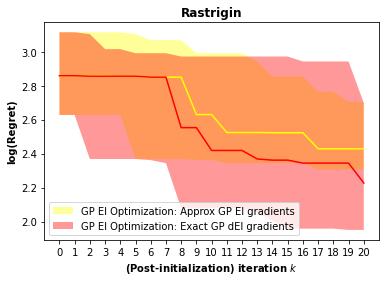

In [98]:
### Visualise!

title = func
plt.figure()

plt.plot(median_approx, color = 'Yellow')
plt.plot(median_exact, color = 'Red')

xstar = np.arange(0, iters+1, step=1)
plt.fill_between(xstar, lower_approx, upper_approx, facecolor = 'Yellow', alpha=0.4, label='GP EI Optimization: Approx GP EI gradients')
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Red', alpha=0.4, label='GP EI Optimization: Exact GP dEI gradients')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialization) iteration $\it{k}$', weight = 'bold')
plt.ylabel('log(Regret)', weight = 'bold') 
plt.legend(loc=3) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show() #visualize!

In [99]:
time_approx, time_exact


(1280.5371770858765, 1192.130666255951)

In [100]:
min_ei = 0


In [101]:
### acqFunc regret minimization: run number = 1

### Exact
acqFuncApprox_exact_1 = acqFuncApprox(exact_1.history) 
acqFuncExact_exact_1 = acqFuncExact(exact_1.history)

acqFuncApproxRegret_exact_1 = np.log(acqFuncApprox_exact_1 - min_ei)
acqFuncExactRegret_exact_1 = np.log(acqFuncExact_exact_1 - min_ei)

acqFuncApproxSimpleRegret_exact_1 = min_max_array(acqFuncApproxRegret_exact_1)
acqFuncExactSimpleRegret_exact_1 = min_max_array(acqFuncExactRegret_exact_1)

min_acqFuncApproxSimpleRegret_exact_1 = min(acqFuncApproxSimpleRegret_exact_1)
min_acqFuncExactSimpleRegret_exact_1 = min(acqFuncExactSimpleRegret_exact_1)

min_acqFuncApproxSimpleRegret_exact_1, min_acqFuncExactSimpleRegret_exact_1


(2.5859109037075445, 2.555070264406561)

In [102]:
### acqFunc regret minimization: run number = 2

### Exact
acqFuncApprox_exact_2 = acqFuncApprox(exact_2.history) 
acqFuncExact_exact_2 = acqFuncExact(exact_2.history)

acqFuncApproxRegret_exact_2 = np.log(acqFuncApprox_exact_2 - min_ei)
acqFuncExactRegret_exact_2 = np.log(acqFuncExact_exact_2 - min_ei)

acqFuncApproxSimpleRegret_exact_2 = min_max_array(acqFuncApproxRegret_exact_2)
acqFuncExactSimpleRegret_exact_2 = min_max_array(acqFuncExactRegret_exact_2)

min_acqFuncApproxSimpleRegret_exact_2 = min(acqFuncApproxSimpleRegret_exact_2)
min_acqFuncExactSimpleRegret_exact_2 = min(acqFuncExactSimpleRegret_exact_2)

min_acqFuncApproxSimpleRegret_exact_2, min_acqFuncExactSimpleRegret_exact_2


(2.4750992226247455, 2.4025599530443116)

In [103]:
### acqFunc regret minimization: run number = 3

### Exact
acqFuncApprox_exact_3 = acqFuncApprox(exact_3.history) 
acqFuncExact_exact_3 = acqFuncExact(exact_3.history)

acqFuncApproxRegret_exact_3 = np.log(acqFuncApprox_exact_3 - min_ei)
acqFuncExactRegret_exact_3 = np.log(acqFuncExact_exact_3 - min_ei)

acqFuncApproxSimpleRegret_exact_3 = min_max_array(acqFuncApproxRegret_exact_3)
acqFuncExactSimpleRegret_exact_3 = min_max_array(acqFuncExactRegret_exact_3)

min_acqFuncApproxSimpleRegret_exact_3 = min(acqFuncApproxSimpleRegret_exact_3)
min_acqFuncExactSimpleRegret_exact_3 = min(acqFuncExactSimpleRegret_exact_3)

min_acqFuncApproxSimpleRegret_exact_3, min_acqFuncExactSimpleRegret_exact_3


(1.4488007245434333, 0.9393833131200476)

In [104]:
### acqFunc regret minimization: run number = 4

### Exact
acqFuncApprox_exact_4 = acqFuncApprox(exact_4.history) 
acqFuncExact_exact_4 = acqFuncExact(exact_4.history)

acqFuncApproxRegret_exact_4 = np.log(acqFuncApprox_exact_4 - min_ei)
acqFuncExactRegret_exact_4 = np.log(acqFuncExact_exact_4 - min_ei)

acqFuncApproxSimpleRegret_exact_4 = min_max_array(acqFuncApproxRegret_exact_4)
acqFuncExactSimpleRegret_exact_4 = min_max_array(acqFuncExactRegret_exact_4)

min_acqFuncApproxSimpleRegret_exact_4 = min(acqFuncApproxSimpleRegret_exact_4)
min_acqFuncExactSimpleRegret_exact_4 = min(acqFuncExactSimpleRegret_exact_4)

min_acqFuncApproxSimpleRegret_exact_4, min_acqFuncExactSimpleRegret_exact_4


(2.0070225450029846, 1.881172536297131)

In [105]:
### acqFunc regret minimization: run number = 5

### Exact
acqFuncApprox_exact_5 = acqFuncApprox(exact_5.history) 
acqFuncExact_exact_5 = acqFuncExact(exact_5.history)

acqFuncApproxRegret_exact_5 = np.log(acqFuncApprox_exact_5 - min_ei)
acqFuncExactRegret_exact_5 = np.log(acqFuncExact_exact_5 - min_ei)

acqFuncApproxSimpleRegret_exact_5 = min_max_array(acqFuncApproxRegret_exact_5)
acqFuncExactSimpleRegret_exact_5 = min_max_array(acqFuncExactRegret_exact_5)

min_acqFuncApproxSimpleRegret_exact_5 = min(acqFuncApproxSimpleRegret_exact_5)
min_acqFuncExactSimpleRegret_exact_5 = min(acqFuncExactSimpleRegret_exact_5)

min_acqFuncApproxSimpleRegret_exact_5, min_acqFuncExactSimpleRegret_exact_5


(0.6085525204469281, 0.19006016026436942)

In [106]:
### acqFunc regret minimization: run number = 6

### Exact
acqFuncApprox_exact_6 = acqFuncApprox(exact_6.history) 
acqFuncExact_exact_6 = acqFuncExact(exact_6.history)

acqFuncApproxRegret_exact_6 = np.log(acqFuncApprox_exact_6 - min_ei)
acqFuncExactRegret_exact_6 = np.log(acqFuncExact_exact_6 - min_ei)

acqFuncApproxSimpleRegret_exact_6 = min_max_array(acqFuncApproxRegret_exact_6)
acqFuncExactSimpleRegret_exact_6 = min_max_array(acqFuncExactRegret_exact_6)

min_acqFuncApproxSimpleRegret_exact_6 = min(acqFuncApproxSimpleRegret_exact_6)
min_acqFuncExactSimpleRegret_exact_6 = min(acqFuncExactSimpleRegret_exact_6)

min_acqFuncApproxSimpleRegret_exact_6, min_acqFuncExactSimpleRegret_exact_6


(0.9312928008113823, 0.6216969007665322)

In [107]:
### acqFunc regret minimization: run number = 7

### Exact
acqFuncApprox_exact_7 = acqFuncApprox(exact_7.history) 
acqFuncExact_exact_7 = acqFuncExact(exact_7.history)

acqFuncApproxRegret_exact_7 = np.log(acqFuncApprox_exact_7 - min_ei)
acqFuncExactRegret_exact_7 = np.log(acqFuncExact_exact_7 - min_ei)

acqFuncApproxSimpleRegret_exact_7 = min_max_array(acqFuncApproxRegret_exact_7)
acqFuncExactSimpleRegret_exact_7 = min_max_array(acqFuncExactRegret_exact_7)

min_acqFuncApproxSimpleRegret_exact_7 = min(acqFuncApproxSimpleRegret_exact_7)
min_acqFuncExactSimpleRegret_exact_7 = min(acqFuncExactSimpleRegret_exact_7)

min_acqFuncApproxSimpleRegret_exact_7, min_acqFuncExactSimpleRegret_exact_7


(2.5107988960177123, 2.5004620616829287)

In [108]:
### acqFunc regret minimization: run number = 8

### Exact
acqFuncApprox_exact_8 = acqFuncApprox(exact_8.history) 
acqFuncExact_exact_8 = acqFuncExact(exact_8.history)

acqFuncApproxRegret_exact_8 = np.log(acqFuncApprox_exact_8 - min_ei)
acqFuncExactRegret_exact_8 = np.log(acqFuncExact_exact_8 - min_ei)

acqFuncApproxSimpleRegret_exact_8 = min_max_array(acqFuncApproxRegret_exact_8)
acqFuncExactSimpleRegret_exact_8 = min_max_array(acqFuncExactRegret_exact_8)

min_acqFuncApproxSimpleRegret_exact_8 = min(acqFuncApproxSimpleRegret_exact_8)
min_acqFuncExactSimpleRegret_exact_8 = min(acqFuncExactSimpleRegret_exact_8)

min_acqFuncApproxSimpleRegret_exact_8, min_acqFuncExactSimpleRegret_exact_8


(1.2050520441336572, 1.2050017577137901)

In [109]:
### acqFunc regret minimization: run number = 9

### Exact
acqFuncApprox_exact_9 = acqFuncApprox(exact_9.history) 
acqFuncExact_exact_9 = acqFuncExact(exact_9.history)

acqFuncApproxRegret_exact_9 = np.log(acqFuncApprox_exact_9 - min_ei)
acqFuncExactRegret_exact_9 = np.log(acqFuncExact_exact_9 - min_ei)

acqFuncApproxSimpleRegret_exact_9 = min_max_array(acqFuncApproxRegret_exact_9)
acqFuncExactSimpleRegret_exact_9 = min_max_array(acqFuncExactRegret_exact_9)

min_acqFuncApproxSimpleRegret_exact_9 = min(acqFuncApproxSimpleRegret_exact_9)
min_acqFuncExactSimpleRegret_exact_9 = min(acqFuncExactSimpleRegret_exact_9)

min_acqFuncApproxSimpleRegret_exact_9, min_acqFuncExactSimpleRegret_exact_9


(2.646254612111737, 2.6383498064644066)

In [110]:
### acqFunc regret minimization: run number = 10

### Exact
acqFuncApprox_exact_10 = acqFuncApprox(exact_10.history) 
acqFuncExact_exact_10 = acqFuncExact(exact_10.history)

acqFuncApproxRegret_exact_10 = np.log(acqFuncApprox_exact_10 - min_ei)
acqFuncExactRegret_exact_10 = np.log(acqFuncExact_exact_10 - min_ei)

acqFuncApproxSimpleRegret_exact_10 = min_max_array(acqFuncApproxRegret_exact_10)
acqFuncExactSimpleRegret_exact_10 = min_max_array(acqFuncExactRegret_exact_10)

min_acqFuncApproxSimpleRegret_exact_10 = min(acqFuncApproxSimpleRegret_exact_10)
min_acqFuncExactSimpleRegret_exact_10 = min(acqFuncExactSimpleRegret_exact_10)

min_acqFuncApproxSimpleRegret_exact_10, min_acqFuncExactSimpleRegret_exact_10


(-1.839572540798939, -2.3079949016670067)

In [111]:
### acqFunc regret minimization: run number = 11

### Exact
acqFuncApprox_exact_11 = acqFuncApprox(exact_11.history) 
acqFuncExact_exact_11 = acqFuncExact(exact_11.history)

acqFuncApproxRegret_exact_11 = np.log(acqFuncApprox_exact_11 - min_ei)
acqFuncExactRegret_exact_11 = np.log(acqFuncExact_exact_11 - min_ei)

acqFuncApproxSimpleRegret_exact_11 = min_max_array(acqFuncApproxRegret_exact_11)
acqFuncExactSimpleRegret_exact_11 = min_max_array(acqFuncExactRegret_exact_11)

min_acqFuncApproxSimpleRegret_exact_11 = min(acqFuncApproxSimpleRegret_exact_11)
min_acqFuncExactSimpleRegret_exact_11 = min(acqFuncExactSimpleRegret_exact_11)

min_acqFuncApproxSimpleRegret_exact_11, min_acqFuncExactSimpleRegret_exact_11


(1.5202080024993476, 1.1175012143474468)

In [112]:
### acqFunc regret minimization: run number = 12

### Exact
acqFuncApprox_exact_12 = acqFuncApprox(exact_12.history) 
acqFuncExact_exact_12 = acqFuncExact(exact_12.history)

acqFuncApproxRegret_exact_12 = np.log(acqFuncApprox_exact_12 - min_ei)
acqFuncExactRegret_exact_12 = np.log(acqFuncExact_exact_12 - min_ei)

acqFuncApproxSimpleRegret_exact_12 = min_max_array(acqFuncApproxRegret_exact_12)
acqFuncExactSimpleRegret_exact_12 = min_max_array(acqFuncExactRegret_exact_12)

min_acqFuncApproxSimpleRegret_exact_12 = min(acqFuncApproxSimpleRegret_exact_12)
min_acqFuncExactSimpleRegret_exact_12 = min(acqFuncExactSimpleRegret_exact_12)

min_acqFuncApproxSimpleRegret_exact_12, min_acqFuncExactSimpleRegret_exact_12


(2.686583515947455, 2.439667338781667)

In [113]:
### acqFunc regret minimization: run number = 13

### Exact
acqFuncApprox_exact_13 = acqFuncApprox(exact_13.history) 
acqFuncExact_exact_13 = acqFuncExact(exact_13.history)

acqFuncApproxRegret_exact_13 = np.log(acqFuncApprox_exact_13 - min_ei)
acqFuncExactRegret_exact_13 = np.log(acqFuncExact_exact_13 - min_ei)

acqFuncApproxSimpleRegret_exact_13 = min_max_array(acqFuncApproxRegret_exact_13)
acqFuncExactSimpleRegret_exact_13 = min_max_array(acqFuncExactRegret_exact_13)

min_acqFuncApproxSimpleRegret_exact_13 = min(acqFuncApproxSimpleRegret_exact_13)
min_acqFuncExactSimpleRegret_exact_13 = min(acqFuncExactSimpleRegret_exact_13)

min_acqFuncApproxSimpleRegret_exact_13, min_acqFuncExactSimpleRegret_exact_13


(0.22504665832193294, -0.007683677729462838)

In [114]:
### acqFunc regret minimization: run number = 14

### Exact
acqFuncApprox_exact_14 = acqFuncApprox(exact_14.history) 
acqFuncExact_exact_14 = acqFuncExact(exact_14.history)

acqFuncApproxRegret_exact_14 = np.log(acqFuncApprox_exact_14 - min_ei)
acqFuncExactRegret_exact_14 = np.log(acqFuncExact_exact_14 - min_ei)

acqFuncApproxSimpleRegret_exact_14 = min_max_array(acqFuncApproxRegret_exact_14)
acqFuncExactSimpleRegret_exact_14 = min_max_array(acqFuncExactRegret_exact_14)

min_acqFuncApproxSimpleRegret_exact_14 = min(acqFuncApproxSimpleRegret_exact_14)
min_acqFuncExactSimpleRegret_exact_14 = min(acqFuncExactSimpleRegret_exact_14)

min_acqFuncApproxSimpleRegret_exact_14, min_acqFuncExactSimpleRegret_exact_14


(1.41534374995433, 1.071484167679118)

In [115]:
### acqFunc regret minimization: run number = 15

### Exact
acqFuncApprox_exact_15 = acqFuncApprox(exact_15.history) 
acqFuncExact_exact_15 = acqFuncExact(exact_15.history)

acqFuncApproxRegret_exact_15 = np.log(acqFuncApprox_exact_15 - min_ei)
acqFuncExactRegret_exact_15 = np.log(acqFuncExact_exact_15 - min_ei)

acqFuncApproxSimpleRegret_exact_15 = min_max_array(acqFuncApproxRegret_exact_15)
acqFuncExactSimpleRegret_exact_15 = min_max_array(acqFuncExactRegret_exact_15)

min_acqFuncApproxSimpleRegret_exact_15 = min(acqFuncApproxSimpleRegret_exact_15)
min_acqFuncExactSimpleRegret_exact_15 = min(acqFuncExactSimpleRegret_exact_15)

min_acqFuncApproxSimpleRegret_exact_15, min_acqFuncExactSimpleRegret_exact_15


(0.7725732252124283, 0.07393053248372554)

In [116]:
### acqFunc regret minimization: run number = 16

### Exact
acqFuncApprox_exact_16 = acqFuncApprox(exact_16.history) 
acqFuncExact_exact_16 = acqFuncExact(exact_16.history)

acqFuncApproxRegret_exact_16 = np.log(acqFuncApprox_exact_16 - min_ei)
acqFuncExactRegret_exact_16 = np.log(acqFuncExact_exact_16 - min_ei)

acqFuncApproxSimpleRegret_exact_16 = min_max_array(acqFuncApproxRegret_exact_16)
acqFuncExactSimpleRegret_exact_16 = min_max_array(acqFuncExactRegret_exact_16)

min_acqFuncApproxSimpleRegret_exact_16 = min(acqFuncApproxSimpleRegret_exact_16)
min_acqFuncExactSimpleRegret_exact_16 = min(acqFuncExactSimpleRegret_exact_16)

min_acqFuncApproxSimpleRegret_exact_16, min_acqFuncExactSimpleRegret_exact_16


(0.8720027273541266, 0.13368356272064583)

In [117]:
### acqFunc regret minimization: run number = 17

### Exact
acqFuncApprox_exact_17 = acqFuncApprox(exact_17.history) 
acqFuncExact_exact_17 = acqFuncExact(exact_17.history)

acqFuncApproxRegret_exact_17 = np.log(acqFuncApprox_exact_17 - min_ei)
acqFuncExactRegret_exact_17 = np.log(acqFuncExact_exact_17 - min_ei)

acqFuncApproxSimpleRegret_exact_17 = min_max_array(acqFuncApproxRegret_exact_17)
acqFuncExactSimpleRegret_exact_17 = min_max_array(acqFuncExactRegret_exact_17)

min_acqFuncApproxSimpleRegret_exact_17 = min(acqFuncApproxSimpleRegret_exact_17)
min_acqFuncExactSimpleRegret_exact_17 = min(acqFuncExactSimpleRegret_exact_17)

min_acqFuncApproxSimpleRegret_exact_17, min_acqFuncExactSimpleRegret_exact_17


(-0.0930572968130503, -0.18649612115855568)

In [118]:
### acqFunc regret minimization: run number = 18

### Exact
acqFuncApprox_exact_18 = acqFuncApprox(exact_18.history) 
acqFuncExact_exact_18 = acqFuncExact(exact_18.history)

acqFuncApproxRegret_exact_18 = np.log(acqFuncApprox_exact_18 - min_ei)
acqFuncExactRegret_exact_18 = np.log(acqFuncExact_exact_18 - min_ei)

acqFuncApproxSimpleRegret_exact_18 = min_max_array(acqFuncApproxRegret_exact_18)
acqFuncExactSimpleRegret_exact_18 = min_max_array(acqFuncExactRegret_exact_18)

min_acqFuncApproxSimpleRegret_exact_18 = min(acqFuncApproxSimpleRegret_exact_18)
min_acqFuncExactSimpleRegret_exact_18 = min(acqFuncExactSimpleRegret_exact_18)

min_acqFuncApproxSimpleRegret_exact_18, min_acqFuncExactSimpleRegret_exact_18


(2.1637117713791167, 2.155041111811995)

In [119]:
### acqFunc regret minimization: run number = 19

### Exact
acqFuncApprox_exact_19 = acqFuncApprox(exact_19.history) 
acqFuncExact_exact_19 = acqFuncExact(exact_19.history)

acqFuncApproxRegret_exact_19 = np.log(acqFuncApprox_exact_19 - min_ei)
acqFuncExactRegret_exact_19 = np.log(acqFuncExact_exact_19 - min_ei)

acqFuncApproxSimpleRegret_exact_19 = min_max_array(acqFuncApproxRegret_exact_19)
acqFuncExactSimpleRegret_exact_19 = min_max_array(acqFuncExactRegret_exact_19)

min_acqFuncApproxSimpleRegret_exact_19 = min(acqFuncApproxSimpleRegret_exact_19)
min_acqFuncExactSimpleRegret_exact_19 = min(acqFuncExactSimpleRegret_exact_19)

min_acqFuncApproxSimpleRegret_exact_19, min_acqFuncExactSimpleRegret_exact_19


(0.26296512778867154, -1.2706619657991651)

In [120]:
### acqFunc regret minimization: run number = 20

### Exact
acqFuncApprox_exact_20 = acqFuncApprox(exact_20.history) 
acqFuncExact_exact_20 = acqFuncExact(exact_20.history)

acqFuncApproxRegret_exact_20 = np.log(acqFuncApprox_exact_20 - min_ei)
acqFuncExactRegret_exact_20 = np.log(acqFuncExact_exact_20 - min_ei)

acqFuncApproxSimpleRegret_exact_20 = min_max_array(acqFuncApproxRegret_exact_20)
acqFuncExactSimpleRegret_exact_20 = min_max_array(acqFuncExactRegret_exact_20)

min_acqFuncApproxSimpleRegret_exact_20 = min(acqFuncApproxSimpleRegret_exact_20)
min_acqFuncExactSimpleRegret_exact_20 = min(acqFuncExactSimpleRegret_exact_20)

min_acqFuncApproxSimpleRegret_exact_20, min_acqFuncExactSimpleRegret_exact_20


(0.758888629686954, 0.3668342349423223)

In [121]:
# Iteration1 :

ApproxSimpleRegret_exact1 = [acqFuncApproxSimpleRegret_exact_1[slice1],
                              acqFuncApproxSimpleRegret_exact_2[slice1],
                              acqFuncApproxSimpleRegret_exact_3[slice1],
                              acqFuncApproxSimpleRegret_exact_4[slice1],
                              acqFuncApproxSimpleRegret_exact_5[slice1],
                              acqFuncApproxSimpleRegret_exact_6[slice1],
                              acqFuncApproxSimpleRegret_exact_7[slice1],
                              acqFuncApproxSimpleRegret_exact_8[slice1],
                              acqFuncApproxSimpleRegret_exact_9[slice1],
                              acqFuncApproxSimpleRegret_exact_10[slice1],
                              acqFuncApproxSimpleRegret_exact_11[slice1],
                              acqFuncApproxSimpleRegret_exact_12[slice1],
                              acqFuncApproxSimpleRegret_exact_13[slice1],
                              acqFuncApproxSimpleRegret_exact_14[slice1],
                              acqFuncApproxSimpleRegret_exact_15[slice1],
                              acqFuncApproxSimpleRegret_exact_16[slice1],
                              acqFuncApproxSimpleRegret_exact_17[slice1],
                              acqFuncApproxSimpleRegret_exact_18[slice1],
                              acqFuncApproxSimpleRegret_exact_19[slice1],
                              acqFuncApproxSimpleRegret_exact_20[slice1]]

ExactSimpleRegret_exact1 = [acqFuncExactSimpleRegret_exact_1[slice1],
                              acqFuncExactSimpleRegret_exact_2[slice1],
                              acqFuncExactSimpleRegret_exact_3[slice1],
                              acqFuncExactSimpleRegret_exact_4[slice1],
                              acqFuncExactSimpleRegret_exact_5[slice1],
                              acqFuncExactSimpleRegret_exact_6[slice1],
                              acqFuncExactSimpleRegret_exact_7[slice1],
                              acqFuncExactSimpleRegret_exact_8[slice1],
                              acqFuncExactSimpleRegret_exact_9[slice1],
                              acqFuncExactSimpleRegret_exact_10[slice1],
                              acqFuncExactSimpleRegret_exact_11[slice1],
                              acqFuncExactSimpleRegret_exact_12[slice1],
                              acqFuncExactSimpleRegret_exact_13[slice1],
                              acqFuncExactSimpleRegret_exact_14[slice1],
                              acqFuncExactSimpleRegret_exact_15[slice1],
                              acqFuncExactSimpleRegret_exact_16[slice1],
                              acqFuncExactSimpleRegret_exact_17[slice1],
                              acqFuncExactSimpleRegret_exact_18[slice1],
                              acqFuncExactSimpleRegret_exact_19[slice1],
                              acqFuncExactSimpleRegret_exact_20[slice1]]

ApproxSimpleRegret_exact1_results = pd.DataFrame(ApproxSimpleRegret_exact1).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact1_results = pd.DataFrame(ExactSimpleRegret_exact1).sort_values(by=[0], ascending=False)


### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact1 = np.asarray(ApproxSimpleRegret_exact1_results[4:5][0])[0]
median_ApproxSimpleRegret_exact1 = np.asarray(ApproxSimpleRegret_exact1_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact1 = np.asarray(ApproxSimpleRegret_exact1_results[14:15][0])[0]

lower_ExactSimpleRegret_exact1 = np.asarray(ExactSimpleRegret_exact1_results[4:5][0])[0]
median_ExactSimpleRegret_exact1 = np.asarray(ExactSimpleRegret_exact1_results[9:10][0])[0]
upper_ExactSimpleRegret_exact1 = np.asarray(ExactSimpleRegret_exact1_results[14:15][0])[0]


In [122]:
# Iteration2 :

ApproxSimpleRegret_exact2 = [acqFuncApproxSimpleRegret_exact_1[slice2],
                              acqFuncApproxSimpleRegret_exact_2[slice2],
                              acqFuncApproxSimpleRegret_exact_3[slice2],
                              acqFuncApproxSimpleRegret_exact_4[slice2],
                              acqFuncApproxSimpleRegret_exact_5[slice2],
                              acqFuncApproxSimpleRegret_exact_6[slice2],
                              acqFuncApproxSimpleRegret_exact_7[slice2],
                              acqFuncApproxSimpleRegret_exact_8[slice2],
                              acqFuncApproxSimpleRegret_exact_9[slice2],
                              acqFuncApproxSimpleRegret_exact_10[slice2],
                              acqFuncApproxSimpleRegret_exact_11[slice2],
                              acqFuncApproxSimpleRegret_exact_12[slice2],
                              acqFuncApproxSimpleRegret_exact_13[slice2],
                              acqFuncApproxSimpleRegret_exact_14[slice2],
                              acqFuncApproxSimpleRegret_exact_15[slice2],
                              acqFuncApproxSimpleRegret_exact_16[slice2],
                              acqFuncApproxSimpleRegret_exact_17[slice2],
                              acqFuncApproxSimpleRegret_exact_18[slice2],
                              acqFuncApproxSimpleRegret_exact_19[slice2],
                              acqFuncApproxSimpleRegret_exact_20[slice2]]

ExactSimpleRegret_exact2 = [acqFuncExactSimpleRegret_exact_1[slice2],
                              acqFuncExactSimpleRegret_exact_2[slice2],
                              acqFuncExactSimpleRegret_exact_3[slice2],
                              acqFuncExactSimpleRegret_exact_4[slice2],
                              acqFuncExactSimpleRegret_exact_5[slice2],
                              acqFuncExactSimpleRegret_exact_6[slice2],
                              acqFuncExactSimpleRegret_exact_7[slice2],
                              acqFuncExactSimpleRegret_exact_8[slice2],
                              acqFuncExactSimpleRegret_exact_9[slice2],
                              acqFuncExactSimpleRegret_exact_10[slice2],
                              acqFuncExactSimpleRegret_exact_11[slice2],
                              acqFuncExactSimpleRegret_exact_12[slice2],
                              acqFuncExactSimpleRegret_exact_13[slice2],
                              acqFuncExactSimpleRegret_exact_14[slice2],
                              acqFuncExactSimpleRegret_exact_15[slice2],
                              acqFuncExactSimpleRegret_exact_16[slice2],
                              acqFuncExactSimpleRegret_exact_17[slice2],
                              acqFuncExactSimpleRegret_exact_18[slice2],
                              acqFuncExactSimpleRegret_exact_19[slice2],
                              acqFuncExactSimpleRegret_exact_20[slice2]]

ApproxSimpleRegret_exact2_results = pd.DataFrame(ApproxSimpleRegret_exact2).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact2_results = pd.DataFrame(ExactSimpleRegret_exact2).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact2 = np.asarray(ApproxSimpleRegret_exact2_results[4:5][0])[0]
median_ApproxSimpleRegret_exact2 = np.asarray(ApproxSimpleRegret_exact2_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact2 = np.asarray(ApproxSimpleRegret_exact2_results[14:15][0])[0]

lower_ExactSimpleRegret_exact2 = np.asarray(ExactSimpleRegret_exact2_results[4:5][0])[0]
median_ExactSimpleRegret_exact2 = np.asarray(ExactSimpleRegret_exact2_results[9:10][0])[0]
upper_ExactSimpleRegret_exact2 = np.asarray(ExactSimpleRegret_exact2_results[14:15][0])[0]


In [123]:
# Iteration3 :

ApproxSimpleRegret_exact3 = [acqFuncApproxSimpleRegret_exact_1[slice3],
                              acqFuncApproxSimpleRegret_exact_2[slice3],
                              acqFuncApproxSimpleRegret_exact_3[slice3],
                              acqFuncApproxSimpleRegret_exact_4[slice3],
                              acqFuncApproxSimpleRegret_exact_5[slice3],
                              acqFuncApproxSimpleRegret_exact_6[slice3],
                              acqFuncApproxSimpleRegret_exact_7[slice3],
                              acqFuncApproxSimpleRegret_exact_8[slice3],
                              acqFuncApproxSimpleRegret_exact_9[slice3],
                              acqFuncApproxSimpleRegret_exact_10[slice3],
                              acqFuncApproxSimpleRegret_exact_11[slice3],
                              acqFuncApproxSimpleRegret_exact_12[slice3],
                              acqFuncApproxSimpleRegret_exact_13[slice3],
                              acqFuncApproxSimpleRegret_exact_14[slice3],
                              acqFuncApproxSimpleRegret_exact_15[slice3],
                              acqFuncApproxSimpleRegret_exact_16[slice3],
                              acqFuncApproxSimpleRegret_exact_17[slice3],
                              acqFuncApproxSimpleRegret_exact_18[slice3],
                              acqFuncApproxSimpleRegret_exact_19[slice3],
                              acqFuncApproxSimpleRegret_exact_20[slice3]]

ExactSimpleRegret_exact3 = [acqFuncExactSimpleRegret_exact_1[slice3],
                              acqFuncExactSimpleRegret_exact_2[slice3],
                              acqFuncExactSimpleRegret_exact_3[slice3],
                              acqFuncExactSimpleRegret_exact_4[slice3],
                              acqFuncExactSimpleRegret_exact_5[slice3],
                              acqFuncExactSimpleRegret_exact_6[slice3],
                              acqFuncExactSimpleRegret_exact_7[slice3],
                              acqFuncExactSimpleRegret_exact_8[slice3],
                              acqFuncExactSimpleRegret_exact_9[slice3],
                              acqFuncExactSimpleRegret_exact_10[slice3],
                              acqFuncExactSimpleRegret_exact_11[slice3],
                              acqFuncExactSimpleRegret_exact_12[slice3],
                              acqFuncExactSimpleRegret_exact_13[slice3],
                              acqFuncExactSimpleRegret_exact_14[slice3],
                              acqFuncExactSimpleRegret_exact_15[slice3],
                              acqFuncExactSimpleRegret_exact_16[slice3],
                              acqFuncExactSimpleRegret_exact_17[slice3],
                              acqFuncExactSimpleRegret_exact_18[slice3],
                              acqFuncExactSimpleRegret_exact_19[slice3],
                              acqFuncExactSimpleRegret_exact_20[slice3]]

ApproxSimpleRegret_exact3_results = pd.DataFrame(ApproxSimpleRegret_exact3).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact3_results = pd.DataFrame(ExactSimpleRegret_exact3).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact3 = np.asarray(ApproxSimpleRegret_exact3_results[4:5][0])[0]
median_ApproxSimpleRegret_exact3 = np.asarray(ApproxSimpleRegret_exact3_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact3 = np.asarray(ApproxSimpleRegret_exact3_results[14:15][0])[0]

lower_ExactSimpleRegret_exact3 = np.asarray(ExactSimpleRegret_exact3_results[4:5][0])[0]
median_ExactSimpleRegret_exact3 = np.asarray(ExactSimpleRegret_exact3_results[9:10][0])[0]
upper_ExactSimpleRegret_exact3 = np.asarray(ExactSimpleRegret_exact3_results[14:15][0])[0]


In [124]:
# Iteration4 :

ApproxSimpleRegret_exact4 = [acqFuncApproxSimpleRegret_exact_1[slice4],
                              acqFuncApproxSimpleRegret_exact_2[slice4],
                              acqFuncApproxSimpleRegret_exact_3[slice4],
                              acqFuncApproxSimpleRegret_exact_4[slice4],
                              acqFuncApproxSimpleRegret_exact_5[slice4],
                              acqFuncApproxSimpleRegret_exact_6[slice4],
                              acqFuncApproxSimpleRegret_exact_7[slice4],
                              acqFuncApproxSimpleRegret_exact_8[slice4],
                              acqFuncApproxSimpleRegret_exact_9[slice4],
                              acqFuncApproxSimpleRegret_exact_10[slice4],
                              acqFuncApproxSimpleRegret_exact_11[slice4],
                              acqFuncApproxSimpleRegret_exact_12[slice4],
                              acqFuncApproxSimpleRegret_exact_13[slice4],
                              acqFuncApproxSimpleRegret_exact_14[slice4],
                              acqFuncApproxSimpleRegret_exact_15[slice4],
                              acqFuncApproxSimpleRegret_exact_16[slice4],
                              acqFuncApproxSimpleRegret_exact_17[slice4],
                              acqFuncApproxSimpleRegret_exact_18[slice4],
                              acqFuncApproxSimpleRegret_exact_19[slice4],
                              acqFuncApproxSimpleRegret_exact_20[slice4]]

ExactSimpleRegret_exact4 = [acqFuncExactSimpleRegret_exact_1[slice4],
                              acqFuncExactSimpleRegret_exact_2[slice4],
                              acqFuncExactSimpleRegret_exact_3[slice4],
                              acqFuncExactSimpleRegret_exact_4[slice4],
                              acqFuncExactSimpleRegret_exact_5[slice4],
                              acqFuncExactSimpleRegret_exact_6[slice4],
                              acqFuncExactSimpleRegret_exact_7[slice4],
                              acqFuncExactSimpleRegret_exact_8[slice4],
                              acqFuncExactSimpleRegret_exact_9[slice4],
                              acqFuncExactSimpleRegret_exact_10[slice4],
                              acqFuncExactSimpleRegret_exact_11[slice4],
                              acqFuncExactSimpleRegret_exact_12[slice4],
                              acqFuncExactSimpleRegret_exact_13[slice4],
                              acqFuncExactSimpleRegret_exact_14[slice4],
                              acqFuncExactSimpleRegret_exact_15[slice4],
                              acqFuncExactSimpleRegret_exact_16[slice4],
                              acqFuncExactSimpleRegret_exact_17[slice4],
                              acqFuncExactSimpleRegret_exact_18[slice4],
                              acqFuncExactSimpleRegret_exact_19[slice4],
                              acqFuncExactSimpleRegret_exact_20[slice4]]

ApproxSimpleRegret_exact4_results = pd.DataFrame(ApproxSimpleRegret_exact4).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact4_results = pd.DataFrame(ExactSimpleRegret_exact4).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact4 = np.asarray(ApproxSimpleRegret_exact4_results[4:5][0])[0]
median_ApproxSimpleRegret_exact4 = np.asarray(ApproxSimpleRegret_exact4_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact4 = np.asarray(ApproxSimpleRegret_exact4_results[14:15][0])[0]

lower_ExactSimpleRegret_exact4 = np.asarray(ExactSimpleRegret_exact4_results[4:5][0])[0]
median_ExactSimpleRegret_exact4 = np.asarray(ExactSimpleRegret_exact4_results[9:10][0])[0]
upper_ExactSimpleRegret_exact4 = np.asarray(ExactSimpleRegret_exact4_results[14:15][0])[0]


In [125]:
# Iteration5 :

ApproxSimpleRegret_exact5 = [acqFuncApproxSimpleRegret_exact_1[slice5],
                              acqFuncApproxSimpleRegret_exact_2[slice5],
                              acqFuncApproxSimpleRegret_exact_3[slice5],
                              acqFuncApproxSimpleRegret_exact_4[slice5],
                              acqFuncApproxSimpleRegret_exact_5[slice5],
                              acqFuncApproxSimpleRegret_exact_6[slice5],
                              acqFuncApproxSimpleRegret_exact_7[slice5],
                              acqFuncApproxSimpleRegret_exact_8[slice5],
                              acqFuncApproxSimpleRegret_exact_9[slice5],
                              acqFuncApproxSimpleRegret_exact_10[slice5],
                              acqFuncApproxSimpleRegret_exact_11[slice5],
                              acqFuncApproxSimpleRegret_exact_12[slice5],
                              acqFuncApproxSimpleRegret_exact_13[slice5],
                              acqFuncApproxSimpleRegret_exact_14[slice5],
                              acqFuncApproxSimpleRegret_exact_15[slice5],
                              acqFuncApproxSimpleRegret_exact_16[slice5],
                              acqFuncApproxSimpleRegret_exact_17[slice5],
                              acqFuncApproxSimpleRegret_exact_18[slice5],
                              acqFuncApproxSimpleRegret_exact_19[slice5],
                              acqFuncApproxSimpleRegret_exact_20[slice5]]

ExactSimpleRegret_exact5 = [acqFuncExactSimpleRegret_exact_1[slice5],
                              acqFuncExactSimpleRegret_exact_2[slice5],
                              acqFuncExactSimpleRegret_exact_3[slice5],
                              acqFuncExactSimpleRegret_exact_4[slice5],
                              acqFuncExactSimpleRegret_exact_5[slice5],
                              acqFuncExactSimpleRegret_exact_6[slice5],
                              acqFuncExactSimpleRegret_exact_7[slice5],
                              acqFuncExactSimpleRegret_exact_8[slice5],
                              acqFuncExactSimpleRegret_exact_9[slice5],
                              acqFuncExactSimpleRegret_exact_10[slice5],
                              acqFuncExactSimpleRegret_exact_11[slice5],
                              acqFuncExactSimpleRegret_exact_12[slice5],
                              acqFuncExactSimpleRegret_exact_13[slice5],
                              acqFuncExactSimpleRegret_exact_14[slice5],
                              acqFuncExactSimpleRegret_exact_15[slice5],
                              acqFuncExactSimpleRegret_exact_16[slice5],
                              acqFuncExactSimpleRegret_exact_17[slice5],
                              acqFuncExactSimpleRegret_exact_18[slice5],
                              acqFuncExactSimpleRegret_exact_19[slice5],
                              acqFuncExactSimpleRegret_exact_20[slice5]]

ApproxSimpleRegret_exact5_results = pd.DataFrame(ApproxSimpleRegret_exact5).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact5_results = pd.DataFrame(ExactSimpleRegret_exact5).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact5 = np.asarray(ApproxSimpleRegret_exact5_results[4:5][0])[0]
median_ApproxSimpleRegret_exact5 = np.asarray(ApproxSimpleRegret_exact5_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact5 = np.asarray(ApproxSimpleRegret_exact5_results[14:15][0])[0]

lower_ExactSimpleRegret_exact5 = np.asarray(ExactSimpleRegret_exact5_results[4:5][0])[0]
median_ExactSimpleRegret_exact5 = np.asarray(ExactSimpleRegret_exact5_results[9:10][0])[0]
upper_ExactSimpleRegret_exact5 = np.asarray(ExactSimpleRegret_exact5_results[14:15][0])[0]


In [126]:
# Iteration6 :

ApproxSimpleRegret_exact6 = [acqFuncApproxSimpleRegret_exact_1[slice6],
                              acqFuncApproxSimpleRegret_exact_2[slice6],
                              acqFuncApproxSimpleRegret_exact_3[slice6],
                              acqFuncApproxSimpleRegret_exact_4[slice6],
                              acqFuncApproxSimpleRegret_exact_5[slice6],
                              acqFuncApproxSimpleRegret_exact_6[slice6],
                              acqFuncApproxSimpleRegret_exact_7[slice6],
                              acqFuncApproxSimpleRegret_exact_8[slice6],
                              acqFuncApproxSimpleRegret_exact_9[slice6],
                              acqFuncApproxSimpleRegret_exact_10[slice6],
                              acqFuncApproxSimpleRegret_exact_11[slice6],
                              acqFuncApproxSimpleRegret_exact_12[slice6],
                              acqFuncApproxSimpleRegret_exact_13[slice6],
                              acqFuncApproxSimpleRegret_exact_14[slice6],
                              acqFuncApproxSimpleRegret_exact_15[slice6],
                              acqFuncApproxSimpleRegret_exact_16[slice6],
                              acqFuncApproxSimpleRegret_exact_17[slice6],
                              acqFuncApproxSimpleRegret_exact_18[slice6],
                              acqFuncApproxSimpleRegret_exact_19[slice6],
                              acqFuncApproxSimpleRegret_exact_20[slice6]]

ExactSimpleRegret_exact6 = [acqFuncExactSimpleRegret_exact_1[slice6],
                              acqFuncExactSimpleRegret_exact_2[slice6],
                              acqFuncExactSimpleRegret_exact_3[slice6],
                              acqFuncExactSimpleRegret_exact_4[slice6],
                              acqFuncExactSimpleRegret_exact_5[slice6],
                              acqFuncExactSimpleRegret_exact_6[slice6],
                              acqFuncExactSimpleRegret_exact_7[slice6],
                              acqFuncExactSimpleRegret_exact_8[slice6],
                              acqFuncExactSimpleRegret_exact_9[slice6],
                              acqFuncExactSimpleRegret_exact_10[slice6],
                              acqFuncExactSimpleRegret_exact_11[slice6],
                              acqFuncExactSimpleRegret_exact_12[slice6],
                              acqFuncExactSimpleRegret_exact_13[slice6],
                              acqFuncExactSimpleRegret_exact_14[slice6],
                              acqFuncExactSimpleRegret_exact_15[slice6],
                              acqFuncExactSimpleRegret_exact_16[slice6],
                              acqFuncExactSimpleRegret_exact_17[slice6],
                              acqFuncExactSimpleRegret_exact_18[slice6],
                              acqFuncExactSimpleRegret_exact_19[slice6],
                              acqFuncExactSimpleRegret_exact_20[slice6]]

ApproxSimpleRegret_exact6_results = pd.DataFrame(ApproxSimpleRegret_exact6).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact6_results = pd.DataFrame(ExactSimpleRegret_exact6).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact6 = np.asarray(ApproxSimpleRegret_exact6_results[4:5][0])[0]
median_ApproxSimpleRegret_exact6 = np.asarray(ApproxSimpleRegret_exact6_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact6 = np.asarray(ApproxSimpleRegret_exact6_results[14:15][0])[0]

lower_ExactSimpleRegret_exact6 = np.asarray(ExactSimpleRegret_exact6_results[4:5][0])[0]
median_ExactSimpleRegret_exact6 = np.asarray(ExactSimpleRegret_exact6_results[9:10][0])[0]
upper_ExactSimpleRegret_exact6 = np.asarray(ExactSimpleRegret_exact6_results[14:15][0])[0]


In [127]:
# Iteration7 :

ApproxSimpleRegret_exact7 =  [acqFuncApproxSimpleRegret_exact_1[slice7],
                              acqFuncApproxSimpleRegret_exact_2[slice7],
                              acqFuncApproxSimpleRegret_exact_3[slice7],
                              acqFuncApproxSimpleRegret_exact_4[slice7],
                              acqFuncApproxSimpleRegret_exact_5[slice7],
                              acqFuncApproxSimpleRegret_exact_6[slice7],
                              acqFuncApproxSimpleRegret_exact_7[slice7],
                              acqFuncApproxSimpleRegret_exact_8[slice7],
                              acqFuncApproxSimpleRegret_exact_9[slice7],
                              acqFuncApproxSimpleRegret_exact_10[slice7],
                              acqFuncApproxSimpleRegret_exact_11[slice7],
                              acqFuncApproxSimpleRegret_exact_12[slice7],
                              acqFuncApproxSimpleRegret_exact_13[slice7],
                              acqFuncApproxSimpleRegret_exact_14[slice7],
                              acqFuncApproxSimpleRegret_exact_15[slice7],
                              acqFuncApproxSimpleRegret_exact_16[slice7],
                              acqFuncApproxSimpleRegret_exact_17[slice7],
                              acqFuncApproxSimpleRegret_exact_18[slice7],
                              acqFuncApproxSimpleRegret_exact_19[slice7],
                              acqFuncApproxSimpleRegret_exact_20[slice7]]

ExactSimpleRegret_exact7 = [acqFuncExactSimpleRegret_exact_1[slice7],
                              acqFuncExactSimpleRegret_exact_2[slice7],
                              acqFuncExactSimpleRegret_exact_3[slice7],
                              acqFuncExactSimpleRegret_exact_4[slice7],
                              acqFuncExactSimpleRegret_exact_5[slice7],
                              acqFuncExactSimpleRegret_exact_6[slice7],
                              acqFuncExactSimpleRegret_exact_7[slice7],
                              acqFuncExactSimpleRegret_exact_8[slice7],
                              acqFuncExactSimpleRegret_exact_9[slice7],
                              acqFuncExactSimpleRegret_exact_10[slice7],
                              acqFuncExactSimpleRegret_exact_11[slice7],
                              acqFuncExactSimpleRegret_exact_12[slice7],
                              acqFuncExactSimpleRegret_exact_13[slice7],
                              acqFuncExactSimpleRegret_exact_14[slice7],
                              acqFuncExactSimpleRegret_exact_15[slice7],
                              acqFuncExactSimpleRegret_exact_16[slice7],
                              acqFuncExactSimpleRegret_exact_17[slice7],
                              acqFuncExactSimpleRegret_exact_18[slice7],
                              acqFuncExactSimpleRegret_exact_19[slice7],
                              acqFuncExactSimpleRegret_exact_20[slice7]]

ApproxSimpleRegret_exact7_results = pd.DataFrame(ApproxSimpleRegret_exact7).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact7_results = pd.DataFrame(ExactSimpleRegret_exact7).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact7 = np.asarray(ApproxSimpleRegret_exact7_results[4:5][0])[0]
median_ApproxSimpleRegret_exact7 = np.asarray(ApproxSimpleRegret_exact7_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact7 = np.asarray(ApproxSimpleRegret_exact7_results[14:15][0])[0]

lower_ExactSimpleRegret_exact7 = np.asarray(ExactSimpleRegret_exact7_results[4:5][0])[0]
median_ExactSimpleRegret_exact7 = np.asarray(ExactSimpleRegret_exact7_results[9:10][0])[0]
upper_ExactSimpleRegret_exact7 = np.asarray(ExactSimpleRegret_exact7_results[14:15][0])[0]


In [128]:
# Iteration8 :

ApproxSimpleRegret_exact8 =  [acqFuncApproxSimpleRegret_exact_1[slice8],
                              acqFuncApproxSimpleRegret_exact_2[slice8],
                              acqFuncApproxSimpleRegret_exact_3[slice8],
                              acqFuncApproxSimpleRegret_exact_4[slice8],
                              acqFuncApproxSimpleRegret_exact_5[slice8],
                              acqFuncApproxSimpleRegret_exact_6[slice8],
                              acqFuncApproxSimpleRegret_exact_7[slice8],
                              acqFuncApproxSimpleRegret_exact_8[slice8],
                              acqFuncApproxSimpleRegret_exact_9[slice8],
                              acqFuncApproxSimpleRegret_exact_10[slice8],
                              acqFuncApproxSimpleRegret_exact_11[slice8],
                              acqFuncApproxSimpleRegret_exact_12[slice8],
                              acqFuncApproxSimpleRegret_exact_13[slice8],
                              acqFuncApproxSimpleRegret_exact_14[slice8],
                              acqFuncApproxSimpleRegret_exact_15[slice8],
                              acqFuncApproxSimpleRegret_exact_16[slice8],
                              acqFuncApproxSimpleRegret_exact_17[slice8],
                              acqFuncApproxSimpleRegret_exact_18[slice8],
                              acqFuncApproxSimpleRegret_exact_19[slice8],
                              acqFuncApproxSimpleRegret_exact_20[slice8]]

ExactSimpleRegret_exact8 = [acqFuncExactSimpleRegret_exact_1[slice8],
                              acqFuncExactSimpleRegret_exact_2[slice8],
                              acqFuncExactSimpleRegret_exact_3[slice8],
                              acqFuncExactSimpleRegret_exact_4[slice8],
                              acqFuncExactSimpleRegret_exact_5[slice8],
                              acqFuncExactSimpleRegret_exact_6[slice8],
                              acqFuncExactSimpleRegret_exact_7[slice8],
                              acqFuncExactSimpleRegret_exact_8[slice8],
                              acqFuncExactSimpleRegret_exact_9[slice8],
                              acqFuncExactSimpleRegret_exact_10[slice8],
                              acqFuncExactSimpleRegret_exact_11[slice8],
                              acqFuncExactSimpleRegret_exact_12[slice8],
                              acqFuncExactSimpleRegret_exact_13[slice8],
                              acqFuncExactSimpleRegret_exact_14[slice8],
                              acqFuncExactSimpleRegret_exact_15[slice8],
                              acqFuncExactSimpleRegret_exact_16[slice8],
                              acqFuncExactSimpleRegret_exact_17[slice8],
                              acqFuncExactSimpleRegret_exact_18[slice8],
                              acqFuncExactSimpleRegret_exact_19[slice8],
                              acqFuncExactSimpleRegret_exact_20[slice8]]

ApproxSimpleRegret_exact8_results = pd.DataFrame(ApproxSimpleRegret_exact8).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact8_results = pd.DataFrame(ExactSimpleRegret_exact8).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact8 = np.asarray(ApproxSimpleRegret_exact8_results[4:5][0])[0]
median_ApproxSimpleRegret_exact8 = np.asarray(ApproxSimpleRegret_exact8_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact8 = np.asarray(ApproxSimpleRegret_exact8_results[14:15][0])[0]

lower_ExactSimpleRegret_exact8 = np.asarray(ExactSimpleRegret_exact8_results[4:5][0])[0]
median_ExactSimpleRegret_exact8 = np.asarray(ExactSimpleRegret_exact8_results[9:10][0])[0]
upper_ExactSimpleRegret_exact8 = np.asarray(ExactSimpleRegret_exact8_results[14:15][0])[0]


In [129]:
# Iteration9 :

ApproxSimpleRegret_exact9 =  [acqFuncApproxSimpleRegret_exact_1[slice9],
                              acqFuncApproxSimpleRegret_exact_2[slice9],
                              acqFuncApproxSimpleRegret_exact_3[slice9],
                              acqFuncApproxSimpleRegret_exact_4[slice9],
                              acqFuncApproxSimpleRegret_exact_5[slice9],
                              acqFuncApproxSimpleRegret_exact_6[slice9],
                              acqFuncApproxSimpleRegret_exact_7[slice9],
                              acqFuncApproxSimpleRegret_exact_8[slice9],
                              acqFuncApproxSimpleRegret_exact_9[slice9],
                              acqFuncApproxSimpleRegret_exact_10[slice9],
                              acqFuncApproxSimpleRegret_exact_11[slice9],
                              acqFuncApproxSimpleRegret_exact_12[slice9],
                              acqFuncApproxSimpleRegret_exact_13[slice9],
                              acqFuncApproxSimpleRegret_exact_14[slice9],
                              acqFuncApproxSimpleRegret_exact_15[slice9],
                              acqFuncApproxSimpleRegret_exact_16[slice9],
                              acqFuncApproxSimpleRegret_exact_17[slice9],
                              acqFuncApproxSimpleRegret_exact_18[slice9],
                              acqFuncApproxSimpleRegret_exact_19[slice9],
                              acqFuncApproxSimpleRegret_exact_20[slice9]]

ExactSimpleRegret_exact9 = [acqFuncExactSimpleRegret_exact_1[slice9],
                              acqFuncExactSimpleRegret_exact_2[slice9],
                              acqFuncExactSimpleRegret_exact_3[slice9],
                              acqFuncExactSimpleRegret_exact_4[slice9],
                              acqFuncExactSimpleRegret_exact_5[slice9],
                              acqFuncExactSimpleRegret_exact_6[slice9],
                              acqFuncExactSimpleRegret_exact_7[slice9],
                              acqFuncExactSimpleRegret_exact_8[slice9],
                              acqFuncExactSimpleRegret_exact_9[slice9],
                              acqFuncExactSimpleRegret_exact_10[slice9],
                              acqFuncExactSimpleRegret_exact_11[slice9],
                              acqFuncExactSimpleRegret_exact_12[slice9],
                              acqFuncExactSimpleRegret_exact_13[slice9],
                              acqFuncExactSimpleRegret_exact_14[slice9],
                              acqFuncExactSimpleRegret_exact_15[slice9],
                              acqFuncExactSimpleRegret_exact_16[slice9],
                              acqFuncExactSimpleRegret_exact_17[slice9],
                              acqFuncExactSimpleRegret_exact_18[slice9],
                              acqFuncExactSimpleRegret_exact_19[slice9],
                              acqFuncExactSimpleRegret_exact_20[slice9]]

ApproxSimpleRegret_exact9_results = pd.DataFrame(ApproxSimpleRegret_exact9).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact9_results = pd.DataFrame(ExactSimpleRegret_exact9).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact9 = np.asarray(ApproxSimpleRegret_exact9_results[4:5][0])[0]
median_ApproxSimpleRegret_exact9 = np.asarray(ApproxSimpleRegret_exact9_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact9 = np.asarray(ApproxSimpleRegret_exact9_results[14:15][0])[0]

lower_ExactSimpleRegret_exact9 = np.asarray(ExactSimpleRegret_exact9_results[4:5][0])[0]
median_ExactSimpleRegret_exact9 = np.asarray(ExactSimpleRegret_exact9_results[9:10][0])[0]
upper_ExactSimpleRegret_exact9 = np.asarray(ExactSimpleRegret_exact9_results[14:15][0])[0]


In [130]:
# Iteration10 :

ApproxSimpleRegret_exact10 = [acqFuncApproxSimpleRegret_exact_1[slice10],
                              acqFuncApproxSimpleRegret_exact_2[slice10],
                              acqFuncApproxSimpleRegret_exact_3[slice10],
                              acqFuncApproxSimpleRegret_exact_4[slice10],
                              acqFuncApproxSimpleRegret_exact_5[slice10],
                              acqFuncApproxSimpleRegret_exact_6[slice10],
                              acqFuncApproxSimpleRegret_exact_7[slice10],
                              acqFuncApproxSimpleRegret_exact_8[slice10],
                              acqFuncApproxSimpleRegret_exact_9[slice10],
                              acqFuncApproxSimpleRegret_exact_10[slice10],
                              acqFuncApproxSimpleRegret_exact_11[slice10],
                              acqFuncApproxSimpleRegret_exact_12[slice10],
                              acqFuncApproxSimpleRegret_exact_13[slice10],
                              acqFuncApproxSimpleRegret_exact_14[slice10],
                              acqFuncApproxSimpleRegret_exact_15[slice10],
                              acqFuncApproxSimpleRegret_exact_16[slice10],
                              acqFuncApproxSimpleRegret_exact_17[slice10],
                              acqFuncApproxSimpleRegret_exact_18[slice10],
                              acqFuncApproxSimpleRegret_exact_19[slice10],
                              acqFuncApproxSimpleRegret_exact_20[slice10]]

ExactSimpleRegret_exact10 = [acqFuncExactSimpleRegret_exact_1[slice10],
                              acqFuncExactSimpleRegret_exact_2[slice10],
                              acqFuncExactSimpleRegret_exact_3[slice10],
                              acqFuncExactSimpleRegret_exact_4[slice10],
                              acqFuncExactSimpleRegret_exact_5[slice10],
                              acqFuncExactSimpleRegret_exact_6[slice10],
                              acqFuncExactSimpleRegret_exact_7[slice10],
                              acqFuncExactSimpleRegret_exact_8[slice10],
                              acqFuncExactSimpleRegret_exact_9[slice10],
                              acqFuncExactSimpleRegret_exact_10[slice10],
                              acqFuncExactSimpleRegret_exact_11[slice10],
                              acqFuncExactSimpleRegret_exact_12[slice10],
                              acqFuncExactSimpleRegret_exact_13[slice10],
                              acqFuncExactSimpleRegret_exact_14[slice10],
                              acqFuncExactSimpleRegret_exact_15[slice10],
                              acqFuncExactSimpleRegret_exact_16[slice10],
                              acqFuncExactSimpleRegret_exact_17[slice10],
                              acqFuncExactSimpleRegret_exact_18[slice10],
                              acqFuncExactSimpleRegret_exact_19[slice10],
                              acqFuncExactSimpleRegret_exact_20[slice10]]

ApproxSimpleRegret_exact10_results = pd.DataFrame(ApproxSimpleRegret_exact10).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact10_results = pd.DataFrame(ExactSimpleRegret_exact10).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact10 = np.asarray(ApproxSimpleRegret_exact10_results[4:5][0])[0]
median_ApproxSimpleRegret_exact10 = np.asarray(ApproxSimpleRegret_exact10_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact10 = np.asarray(ApproxSimpleRegret_exact10_results[14:15][0])[0]

lower_ExactSimpleRegret_exact10 = np.asarray(ExactSimpleRegret_exact10_results[4:5][0])[0]
median_ExactSimpleRegret_exact10 = np.asarray(ExactSimpleRegret_exact10_results[9:10][0])[0]
upper_ExactSimpleRegret_exact10 = np.asarray(ExactSimpleRegret_exact10_results[14:15][0])[0]


In [131]:
# Iteration11 :

ApproxSimpleRegret_exact11 = [acqFuncApproxSimpleRegret_exact_1[slice11],
                              acqFuncApproxSimpleRegret_exact_2[slice11],
                              acqFuncApproxSimpleRegret_exact_3[slice11],
                              acqFuncApproxSimpleRegret_exact_4[slice11],
                              acqFuncApproxSimpleRegret_exact_5[slice11],
                              acqFuncApproxSimpleRegret_exact_6[slice11],
                              acqFuncApproxSimpleRegret_exact_7[slice11],
                              acqFuncApproxSimpleRegret_exact_8[slice11],
                              acqFuncApproxSimpleRegret_exact_9[slice11],
                              acqFuncApproxSimpleRegret_exact_10[slice11],
                              acqFuncApproxSimpleRegret_exact_11[slice11],
                              acqFuncApproxSimpleRegret_exact_12[slice11],
                              acqFuncApproxSimpleRegret_exact_13[slice11],
                              acqFuncApproxSimpleRegret_exact_14[slice11],
                              acqFuncApproxSimpleRegret_exact_15[slice11],
                              acqFuncApproxSimpleRegret_exact_16[slice11],
                              acqFuncApproxSimpleRegret_exact_17[slice11],
                              acqFuncApproxSimpleRegret_exact_18[slice11],
                              acqFuncApproxSimpleRegret_exact_19[slice11],
                              acqFuncApproxSimpleRegret_exact_20[slice11]]

ExactSimpleRegret_exact11 = [acqFuncExactSimpleRegret_exact_1[slice11],
                              acqFuncExactSimpleRegret_exact_2[slice11],
                              acqFuncExactSimpleRegret_exact_3[slice11],
                              acqFuncExactSimpleRegret_exact_4[slice11],
                              acqFuncExactSimpleRegret_exact_5[slice11],
                              acqFuncExactSimpleRegret_exact_6[slice11],
                              acqFuncExactSimpleRegret_exact_7[slice11],
                              acqFuncExactSimpleRegret_exact_8[slice11],
                              acqFuncExactSimpleRegret_exact_9[slice11],
                              acqFuncExactSimpleRegret_exact_10[slice11],
                              acqFuncExactSimpleRegret_exact_11[slice11],
                              acqFuncExactSimpleRegret_exact_12[slice11],
                              acqFuncExactSimpleRegret_exact_13[slice11],
                              acqFuncExactSimpleRegret_exact_14[slice11],
                              acqFuncExactSimpleRegret_exact_15[slice11],
                              acqFuncExactSimpleRegret_exact_16[slice11],
                              acqFuncExactSimpleRegret_exact_17[slice11],
                              acqFuncExactSimpleRegret_exact_18[slice11],
                              acqFuncExactSimpleRegret_exact_19[slice11],
                              acqFuncExactSimpleRegret_exact_20[slice11]]

ApproxSimpleRegret_exact11_results = pd.DataFrame(ApproxSimpleRegret_exact11).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact11_results = pd.DataFrame(ExactSimpleRegret_exact11).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact11 = np.asarray(ApproxSimpleRegret_exact11_results[4:5][0])[0]
median_ApproxSimpleRegret_exact11 = np.asarray(ApproxSimpleRegret_exact11_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact11 = np.asarray(ApproxSimpleRegret_exact11_results[14:15][0])[0]

lower_ExactSimpleRegret_exact11 = np.asarray(ExactSimpleRegret_exact11_results[4:5][0])[0]
median_ExactSimpleRegret_exact11 = np.asarray(ExactSimpleRegret_exact11_results[9:10][0])[0]
upper_ExactSimpleRegret_exact11 = np.asarray(ExactSimpleRegret_exact11_results[14:15][0])[0]


In [132]:
# Iteration12 :

ApproxSimpleRegret_exact12 = [acqFuncApproxSimpleRegret_exact_1[slice12],
                              acqFuncApproxSimpleRegret_exact_2[slice12],
                              acqFuncApproxSimpleRegret_exact_3[slice12],
                              acqFuncApproxSimpleRegret_exact_4[slice12],
                              acqFuncApproxSimpleRegret_exact_5[slice12],
                              acqFuncApproxSimpleRegret_exact_6[slice12],
                              acqFuncApproxSimpleRegret_exact_7[slice12],
                              acqFuncApproxSimpleRegret_exact_8[slice12],
                              acqFuncApproxSimpleRegret_exact_9[slice12],
                              acqFuncApproxSimpleRegret_exact_10[slice12],
                              acqFuncApproxSimpleRegret_exact_11[slice12],
                              acqFuncApproxSimpleRegret_exact_12[slice12],
                              acqFuncApproxSimpleRegret_exact_13[slice12],
                              acqFuncApproxSimpleRegret_exact_14[slice12],
                              acqFuncApproxSimpleRegret_exact_15[slice12],
                              acqFuncApproxSimpleRegret_exact_16[slice12],
                              acqFuncApproxSimpleRegret_exact_17[slice12],
                              acqFuncApproxSimpleRegret_exact_18[slice12],
                              acqFuncApproxSimpleRegret_exact_19[slice12],
                              acqFuncApproxSimpleRegret_exact_20[slice12]]

ExactSimpleRegret_exact12 = [acqFuncExactSimpleRegret_exact_1[slice12],
                              acqFuncExactSimpleRegret_exact_2[slice12],
                              acqFuncExactSimpleRegret_exact_3[slice12],
                              acqFuncExactSimpleRegret_exact_4[slice12],
                              acqFuncExactSimpleRegret_exact_5[slice12],
                              acqFuncExactSimpleRegret_exact_6[slice12],
                              acqFuncExactSimpleRegret_exact_7[slice12],
                              acqFuncExactSimpleRegret_exact_8[slice12],
                              acqFuncExactSimpleRegret_exact_9[slice12],
                              acqFuncExactSimpleRegret_exact_10[slice12],
                              acqFuncExactSimpleRegret_exact_11[slice12],
                              acqFuncExactSimpleRegret_exact_12[slice12],
                              acqFuncExactSimpleRegret_exact_13[slice12],
                              acqFuncExactSimpleRegret_exact_14[slice12],
                              acqFuncExactSimpleRegret_exact_15[slice12],
                              acqFuncExactSimpleRegret_exact_16[slice12],
                              acqFuncExactSimpleRegret_exact_17[slice12],
                              acqFuncExactSimpleRegret_exact_18[slice12],
                              acqFuncExactSimpleRegret_exact_19[slice12],
                              acqFuncExactSimpleRegret_exact_20[slice12]]

ApproxSimpleRegret_exact12_results = pd.DataFrame(ApproxSimpleRegret_exact12).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact12_results = pd.DataFrame(ExactSimpleRegret_exact12).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact12 = np.asarray(ApproxSimpleRegret_exact12_results[4:5][0])[0]
median_ApproxSimpleRegret_exact12 = np.asarray(ApproxSimpleRegret_exact12_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact12 = np.asarray(ApproxSimpleRegret_exact12_results[14:15][0])[0]

lower_ExactSimpleRegret_exact12 = np.asarray(ExactSimpleRegret_exact12_results[4:5][0])[0]
median_ExactSimpleRegret_exact12 = np.asarray(ExactSimpleRegret_exact12_results[9:10][0])[0]
upper_ExactSimpleRegret_exact12 = np.asarray(ExactSimpleRegret_exact12_results[14:15][0])[0]


In [133]:
# Iteration13 :

ApproxSimpleRegret_exact13 = [acqFuncApproxSimpleRegret_exact_1[slice13],
                              acqFuncApproxSimpleRegret_exact_2[slice13],
                              acqFuncApproxSimpleRegret_exact_3[slice13],
                              acqFuncApproxSimpleRegret_exact_4[slice13],
                              acqFuncApproxSimpleRegret_exact_5[slice13],
                              acqFuncApproxSimpleRegret_exact_6[slice13],
                              acqFuncApproxSimpleRegret_exact_7[slice13],
                              acqFuncApproxSimpleRegret_exact_8[slice13],
                              acqFuncApproxSimpleRegret_exact_9[slice13],
                              acqFuncApproxSimpleRegret_exact_10[slice13],
                              acqFuncApproxSimpleRegret_exact_11[slice13],
                              acqFuncApproxSimpleRegret_exact_12[slice13],
                              acqFuncApproxSimpleRegret_exact_13[slice13],
                              acqFuncApproxSimpleRegret_exact_14[slice13],
                              acqFuncApproxSimpleRegret_exact_15[slice13],
                              acqFuncApproxSimpleRegret_exact_16[slice13],
                              acqFuncApproxSimpleRegret_exact_17[slice13],
                              acqFuncApproxSimpleRegret_exact_18[slice13],
                              acqFuncApproxSimpleRegret_exact_19[slice13],
                              acqFuncApproxSimpleRegret_exact_20[slice13]]

ExactSimpleRegret_exact13 = [acqFuncExactSimpleRegret_exact_1[slice13],
                              acqFuncExactSimpleRegret_exact_2[slice13],
                              acqFuncExactSimpleRegret_exact_3[slice13],
                              acqFuncExactSimpleRegret_exact_4[slice13],
                              acqFuncExactSimpleRegret_exact_5[slice13],
                              acqFuncExactSimpleRegret_exact_6[slice13],
                              acqFuncExactSimpleRegret_exact_7[slice13],
                              acqFuncExactSimpleRegret_exact_8[slice13],
                              acqFuncExactSimpleRegret_exact_9[slice13],
                              acqFuncExactSimpleRegret_exact_10[slice13],
                              acqFuncExactSimpleRegret_exact_11[slice13],
                              acqFuncExactSimpleRegret_exact_12[slice13],
                              acqFuncExactSimpleRegret_exact_13[slice13],
                              acqFuncExactSimpleRegret_exact_14[slice13],
                              acqFuncExactSimpleRegret_exact_15[slice13],
                              acqFuncExactSimpleRegret_exact_16[slice13],
                              acqFuncExactSimpleRegret_exact_17[slice13],
                              acqFuncExactSimpleRegret_exact_18[slice13],
                              acqFuncExactSimpleRegret_exact_19[slice13],
                              acqFuncExactSimpleRegret_exact_20[slice13]]

ApproxSimpleRegret_exact13_results = pd.DataFrame(ApproxSimpleRegret_exact13).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact13_results = pd.DataFrame(ExactSimpleRegret_exact13).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact13 = np.asarray(ApproxSimpleRegret_exact13_results[4:5][0])[0]
median_ApproxSimpleRegret_exact13 = np.asarray(ApproxSimpleRegret_exact13_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact13 = np.asarray(ApproxSimpleRegret_exact13_results[14:15][0])[0]

lower_ExactSimpleRegret_exact13 = np.asarray(ExactSimpleRegret_exact13_results[4:5][0])[0]
median_ExactSimpleRegret_exact13 = np.asarray(ExactSimpleRegret_exact13_results[9:10][0])[0]
upper_ExactSimpleRegret_exact13 = np.asarray(ExactSimpleRegret_exact13_results[14:15][0])[0]


In [134]:
# Iteration14 :

ApproxSimpleRegret_exact14 = [acqFuncApproxSimpleRegret_exact_1[slice14],
                              acqFuncApproxSimpleRegret_exact_2[slice14],
                              acqFuncApproxSimpleRegret_exact_3[slice14],
                              acqFuncApproxSimpleRegret_exact_4[slice14],
                              acqFuncApproxSimpleRegret_exact_5[slice14],
                              acqFuncApproxSimpleRegret_exact_6[slice14],
                              acqFuncApproxSimpleRegret_exact_7[slice14],
                              acqFuncApproxSimpleRegret_exact_8[slice14],
                              acqFuncApproxSimpleRegret_exact_9[slice14],
                              acqFuncApproxSimpleRegret_exact_10[slice14],
                              acqFuncApproxSimpleRegret_exact_11[slice14],
                              acqFuncApproxSimpleRegret_exact_12[slice14],
                              acqFuncApproxSimpleRegret_exact_13[slice14],
                              acqFuncApproxSimpleRegret_exact_14[slice14],
                              acqFuncApproxSimpleRegret_exact_15[slice14],
                              acqFuncApproxSimpleRegret_exact_16[slice14],
                              acqFuncApproxSimpleRegret_exact_17[slice14],
                              acqFuncApproxSimpleRegret_exact_18[slice14],
                              acqFuncApproxSimpleRegret_exact_19[slice14],
                              acqFuncApproxSimpleRegret_exact_20[slice14]]

ExactSimpleRegret_exact14 = [acqFuncExactSimpleRegret_exact_1[slice14],
                              acqFuncExactSimpleRegret_exact_2[slice14],
                              acqFuncExactSimpleRegret_exact_3[slice14],
                              acqFuncExactSimpleRegret_exact_4[slice14],
                              acqFuncExactSimpleRegret_exact_5[slice14],
                              acqFuncExactSimpleRegret_exact_6[slice14],
                              acqFuncExactSimpleRegret_exact_7[slice14],
                              acqFuncExactSimpleRegret_exact_8[slice14],
                              acqFuncExactSimpleRegret_exact_9[slice14],
                              acqFuncExactSimpleRegret_exact_10[slice14],
                              acqFuncExactSimpleRegret_exact_11[slice14],
                              acqFuncExactSimpleRegret_exact_12[slice14],
                              acqFuncExactSimpleRegret_exact_13[slice14],
                              acqFuncExactSimpleRegret_exact_14[slice14],
                              acqFuncExactSimpleRegret_exact_15[slice14],
                              acqFuncExactSimpleRegret_exact_16[slice14],
                              acqFuncExactSimpleRegret_exact_17[slice14],
                              acqFuncExactSimpleRegret_exact_18[slice14],
                              acqFuncExactSimpleRegret_exact_19[slice14],
                              acqFuncExactSimpleRegret_exact_20[slice14]]

ApproxSimpleRegret_exact14_results = pd.DataFrame(ApproxSimpleRegret_exact14).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact14_results = pd.DataFrame(ExactSimpleRegret_exact14).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact14 = np.asarray(ApproxSimpleRegret_exact14_results[4:5][0])[0]
median_ApproxSimpleRegret_exact14 = np.asarray(ApproxSimpleRegret_exact14_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact14 = np.asarray(ApproxSimpleRegret_exact14_results[14:15][0])[0]

lower_ExactSimpleRegret_exact14 = np.asarray(ExactSimpleRegret_exact14_results[4:5][0])[0]
median_ExactSimpleRegret_exact14 = np.asarray(ExactSimpleRegret_exact14_results[9:10][0])[0]
upper_ExactSimpleRegret_exact14 = np.asarray(ExactSimpleRegret_exact14_results[14:15][0])[0]


In [135]:
# Iteration15 :

ApproxSimpleRegret_exact15 = [acqFuncApproxSimpleRegret_exact_1[slice15],
                              acqFuncApproxSimpleRegret_exact_2[slice15],
                              acqFuncApproxSimpleRegret_exact_3[slice15],
                              acqFuncApproxSimpleRegret_exact_4[slice15],
                              acqFuncApproxSimpleRegret_exact_5[slice15],
                              acqFuncApproxSimpleRegret_exact_6[slice15],
                              acqFuncApproxSimpleRegret_exact_7[slice15],
                              acqFuncApproxSimpleRegret_exact_8[slice15],
                              acqFuncApproxSimpleRegret_exact_9[slice15],
                              acqFuncApproxSimpleRegret_exact_10[slice15],
                              acqFuncApproxSimpleRegret_exact_11[slice15],
                              acqFuncApproxSimpleRegret_exact_12[slice15],
                              acqFuncApproxSimpleRegret_exact_13[slice15],
                              acqFuncApproxSimpleRegret_exact_14[slice15],
                              acqFuncApproxSimpleRegret_exact_15[slice15],
                              acqFuncApproxSimpleRegret_exact_16[slice15],
                              acqFuncApproxSimpleRegret_exact_17[slice15],
                              acqFuncApproxSimpleRegret_exact_18[slice15],
                              acqFuncApproxSimpleRegret_exact_19[slice15],
                              acqFuncApproxSimpleRegret_exact_20[slice15]]

ExactSimpleRegret_exact15 = [acqFuncExactSimpleRegret_exact_1[slice15],
                              acqFuncExactSimpleRegret_exact_2[slice15],
                              acqFuncExactSimpleRegret_exact_3[slice15],
                              acqFuncExactSimpleRegret_exact_4[slice15],
                              acqFuncExactSimpleRegret_exact_5[slice15],
                              acqFuncExactSimpleRegret_exact_6[slice15],
                              acqFuncExactSimpleRegret_exact_7[slice15],
                              acqFuncExactSimpleRegret_exact_8[slice15],
                              acqFuncExactSimpleRegret_exact_9[slice15],
                              acqFuncExactSimpleRegret_exact_10[slice15],
                              acqFuncExactSimpleRegret_exact_11[slice15],
                              acqFuncExactSimpleRegret_exact_12[slice15],
                              acqFuncExactSimpleRegret_exact_13[slice15],
                              acqFuncExactSimpleRegret_exact_14[slice15],
                              acqFuncExactSimpleRegret_exact_15[slice15],
                              acqFuncExactSimpleRegret_exact_16[slice15],
                              acqFuncExactSimpleRegret_exact_17[slice15],
                              acqFuncExactSimpleRegret_exact_18[slice15],
                              acqFuncExactSimpleRegret_exact_19[slice15],
                              acqFuncExactSimpleRegret_exact_20[slice15]]

ApproxSimpleRegret_exact15_results = pd.DataFrame(ApproxSimpleRegret_exact15).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact15_results = pd.DataFrame(ExactSimpleRegret_exact15).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact15 = np.asarray(ApproxSimpleRegret_exact15_results[4:5][0])[0]
median_ApproxSimpleRegret_exact15 = np.asarray(ApproxSimpleRegret_exact15_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact15 = np.asarray(ApproxSimpleRegret_exact15_results[14:15][0])[0]

lower_ExactSimpleRegret_exact15 = np.asarray(ExactSimpleRegret_exact15_results[4:5][0])[0]
median_ExactSimpleRegret_exact15 = np.asarray(ExactSimpleRegret_exact15_results[9:10][0])[0]
upper_ExactSimpleRegret_exact15 = np.asarray(ExactSimpleRegret_exact15_results[14:15][0])[0]


In [136]:
# Iteration16 :

ApproxSimpleRegret_exact16 = [acqFuncApproxSimpleRegret_exact_1[slice16],
                              acqFuncApproxSimpleRegret_exact_2[slice16],
                              acqFuncApproxSimpleRegret_exact_3[slice16],
                              acqFuncApproxSimpleRegret_exact_4[slice16],
                              acqFuncApproxSimpleRegret_exact_5[slice16],
                              acqFuncApproxSimpleRegret_exact_6[slice16],
                              acqFuncApproxSimpleRegret_exact_7[slice16],
                              acqFuncApproxSimpleRegret_exact_8[slice16],
                              acqFuncApproxSimpleRegret_exact_9[slice16],
                              acqFuncApproxSimpleRegret_exact_10[slice16],
                              acqFuncApproxSimpleRegret_exact_11[slice16],
                              acqFuncApproxSimpleRegret_exact_12[slice16],
                              acqFuncApproxSimpleRegret_exact_13[slice16],
                              acqFuncApproxSimpleRegret_exact_14[slice16],
                              acqFuncApproxSimpleRegret_exact_15[slice16],
                              acqFuncApproxSimpleRegret_exact_16[slice16],
                              acqFuncApproxSimpleRegret_exact_17[slice16],
                              acqFuncApproxSimpleRegret_exact_18[slice16],
                              acqFuncApproxSimpleRegret_exact_19[slice16],
                              acqFuncApproxSimpleRegret_exact_20[slice16]]

ExactSimpleRegret_exact16 = [acqFuncExactSimpleRegret_exact_1[slice16],
                              acqFuncExactSimpleRegret_exact_2[slice16],
                              acqFuncExactSimpleRegret_exact_3[slice16],
                              acqFuncExactSimpleRegret_exact_4[slice16],
                              acqFuncExactSimpleRegret_exact_5[slice16],
                              acqFuncExactSimpleRegret_exact_6[slice16],
                              acqFuncExactSimpleRegret_exact_7[slice16],
                              acqFuncExactSimpleRegret_exact_8[slice16],
                              acqFuncExactSimpleRegret_exact_9[slice16],
                              acqFuncExactSimpleRegret_exact_10[slice16],
                              acqFuncExactSimpleRegret_exact_11[slice16],
                              acqFuncExactSimpleRegret_exact_12[slice16],
                              acqFuncExactSimpleRegret_exact_13[slice16],
                              acqFuncExactSimpleRegret_exact_14[slice16],
                              acqFuncExactSimpleRegret_exact_15[slice16],
                              acqFuncExactSimpleRegret_exact_16[slice16],
                              acqFuncExactSimpleRegret_exact_17[slice16],
                              acqFuncExactSimpleRegret_exact_18[slice16],
                              acqFuncExactSimpleRegret_exact_19[slice16],
                              acqFuncExactSimpleRegret_exact_20[slice16]]

ApproxSimpleRegret_exact16_results = pd.DataFrame(ApproxSimpleRegret_exact16).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact16_results = pd.DataFrame(ExactSimpleRegret_exact16).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact16 = np.asarray(ApproxSimpleRegret_exact16_results[4:5][0])[0]
median_ApproxSimpleRegret_exact16 = np.asarray(ApproxSimpleRegret_exact16_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact16 = np.asarray(ApproxSimpleRegret_exact16_results[14:15][0])[0]

lower_ExactSimpleRegret_exact16 = np.asarray(ExactSimpleRegret_exact16_results[4:5][0])[0]
median_ExactSimpleRegret_exact16 = np.asarray(ExactSimpleRegret_exact16_results[9:10][0])[0]
upper_ExactSimpleRegret_exact16 = np.asarray(ExactSimpleRegret_exact16_results[14:15][0])[0]


In [137]:
# Iteration17 :

ApproxSimpleRegret_exact17 =  [acqFuncApproxSimpleRegret_exact_1[slice17],
                              acqFuncApproxSimpleRegret_exact_2[slice17],
                              acqFuncApproxSimpleRegret_exact_3[slice17],
                              acqFuncApproxSimpleRegret_exact_4[slice17],
                              acqFuncApproxSimpleRegret_exact_5[slice17],
                              acqFuncApproxSimpleRegret_exact_6[slice17],
                              acqFuncApproxSimpleRegret_exact_7[slice17],
                              acqFuncApproxSimpleRegret_exact_8[slice17],
                              acqFuncApproxSimpleRegret_exact_9[slice17],
                              acqFuncApproxSimpleRegret_exact_10[slice17],
                              acqFuncApproxSimpleRegret_exact_11[slice17],
                              acqFuncApproxSimpleRegret_exact_12[slice17],
                              acqFuncApproxSimpleRegret_exact_13[slice17],
                              acqFuncApproxSimpleRegret_exact_14[slice17],
                              acqFuncApproxSimpleRegret_exact_15[slice17],
                              acqFuncApproxSimpleRegret_exact_16[slice17],
                              acqFuncApproxSimpleRegret_exact_17[slice17],
                              acqFuncApproxSimpleRegret_exact_18[slice17],
                              acqFuncApproxSimpleRegret_exact_19[slice17],
                              acqFuncApproxSimpleRegret_exact_20[slice17]]

ExactSimpleRegret_exact17 = [acqFuncExactSimpleRegret_exact_1[slice17],
                              acqFuncExactSimpleRegret_exact_2[slice17],
                              acqFuncExactSimpleRegret_exact_3[slice17],
                              acqFuncExactSimpleRegret_exact_4[slice17],
                              acqFuncExactSimpleRegret_exact_5[slice17],
                              acqFuncExactSimpleRegret_exact_6[slice17],
                              acqFuncExactSimpleRegret_exact_7[slice17],
                              acqFuncExactSimpleRegret_exact_8[slice17],
                              acqFuncExactSimpleRegret_exact_9[slice17],
                              acqFuncExactSimpleRegret_exact_10[slice17],
                              acqFuncExactSimpleRegret_exact_11[slice17],
                              acqFuncExactSimpleRegret_exact_12[slice17],
                              acqFuncExactSimpleRegret_exact_13[slice17],
                              acqFuncExactSimpleRegret_exact_14[slice17],
                              acqFuncExactSimpleRegret_exact_15[slice17],
                              acqFuncExactSimpleRegret_exact_16[slice17],
                              acqFuncExactSimpleRegret_exact_17[slice17],
                              acqFuncExactSimpleRegret_exact_18[slice17],
                              acqFuncExactSimpleRegret_exact_19[slice17],
                              acqFuncExactSimpleRegret_exact_20[slice17]]

ApproxSimpleRegret_exact17_results = pd.DataFrame(ApproxSimpleRegret_exact17).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact17_results = pd.DataFrame(ExactSimpleRegret_exact17).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact17 = np.asarray(ApproxSimpleRegret_exact17_results[4:5][0])[0]
median_ApproxSimpleRegret_exact17 = np.asarray(ApproxSimpleRegret_exact17_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact17 = np.asarray(ApproxSimpleRegret_exact17_results[14:15][0])[0]

lower_ExactSimpleRegret_exact17 = np.asarray(ExactSimpleRegret_exact17_results[4:5][0])[0]
median_ExactSimpleRegret_exact17 = np.asarray(ExactSimpleRegret_exact17_results[9:10][0])[0]
upper_ExactSimpleRegret_exact17 = np.asarray(ExactSimpleRegret_exact17_results[14:15][0])[0]


In [138]:
# Iteration18 :

ApproxSimpleRegret_exact18 =  [acqFuncApproxSimpleRegret_exact_1[slice18],
                              acqFuncApproxSimpleRegret_exact_2[slice18],
                              acqFuncApproxSimpleRegret_exact_3[slice18],
                              acqFuncApproxSimpleRegret_exact_4[slice18],
                              acqFuncApproxSimpleRegret_exact_5[slice18],
                              acqFuncApproxSimpleRegret_exact_6[slice18],
                              acqFuncApproxSimpleRegret_exact_7[slice18],
                              acqFuncApproxSimpleRegret_exact_8[slice18],
                              acqFuncApproxSimpleRegret_exact_9[slice18],
                              acqFuncApproxSimpleRegret_exact_10[slice18],
                              acqFuncApproxSimpleRegret_exact_11[slice18],
                              acqFuncApproxSimpleRegret_exact_12[slice18],
                              acqFuncApproxSimpleRegret_exact_13[slice18],
                              acqFuncApproxSimpleRegret_exact_14[slice18],
                              acqFuncApproxSimpleRegret_exact_15[slice18],
                              acqFuncApproxSimpleRegret_exact_16[slice18],
                              acqFuncApproxSimpleRegret_exact_17[slice18],
                              acqFuncApproxSimpleRegret_exact_18[slice18],
                              acqFuncApproxSimpleRegret_exact_19[slice18],
                              acqFuncApproxSimpleRegret_exact_20[slice18]]

ExactSimpleRegret_exact18 = [acqFuncExactSimpleRegret_exact_1[slice18],
                              acqFuncExactSimpleRegret_exact_2[slice18],
                              acqFuncExactSimpleRegret_exact_3[slice18],
                              acqFuncExactSimpleRegret_exact_4[slice18],
                              acqFuncExactSimpleRegret_exact_5[slice18],
                              acqFuncExactSimpleRegret_exact_6[slice18],
                              acqFuncExactSimpleRegret_exact_7[slice18],
                              acqFuncExactSimpleRegret_exact_8[slice18],
                              acqFuncExactSimpleRegret_exact_9[slice18],
                              acqFuncExactSimpleRegret_exact_10[slice18],
                              acqFuncExactSimpleRegret_exact_11[slice18],
                              acqFuncExactSimpleRegret_exact_12[slice18],
                              acqFuncExactSimpleRegret_exact_13[slice18],
                              acqFuncExactSimpleRegret_exact_14[slice18],
                              acqFuncExactSimpleRegret_exact_15[slice18],
                              acqFuncExactSimpleRegret_exact_16[slice18],
                              acqFuncExactSimpleRegret_exact_17[slice18],
                              acqFuncExactSimpleRegret_exact_18[slice18],
                              acqFuncExactSimpleRegret_exact_19[slice18],
                              acqFuncExactSimpleRegret_exact_20[slice18]]

ApproxSimpleRegret_exact18_results = pd.DataFrame(ApproxSimpleRegret_exact18).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact18_results = pd.DataFrame(ExactSimpleRegret_exact18).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact18 = np.asarray(ApproxSimpleRegret_exact18_results[4:5][0])[0]
median_ApproxSimpleRegret_exact18 = np.asarray(ApproxSimpleRegret_exact18_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact18 = np.asarray(ApproxSimpleRegret_exact18_results[14:15][0])[0]

lower_ExactSimpleRegret_exact18 = np.asarray(ExactSimpleRegret_exact18_results[4:5][0])[0]
median_ExactSimpleRegret_exact18 = np.asarray(ExactSimpleRegret_exact18_results[9:10][0])[0]
upper_ExactSimpleRegret_exact18 = np.asarray(ExactSimpleRegret_exact18_results[14:15][0])[0]


In [139]:
# Iteration19 :

ApproxSimpleRegret_exact19 = [acqFuncApproxSimpleRegret_exact_1[slice19],
                              acqFuncApproxSimpleRegret_exact_2[slice19],
                              acqFuncApproxSimpleRegret_exact_3[slice19],
                              acqFuncApproxSimpleRegret_exact_4[slice19],
                              acqFuncApproxSimpleRegret_exact_5[slice19],
                              acqFuncApproxSimpleRegret_exact_6[slice19],
                              acqFuncApproxSimpleRegret_exact_7[slice19],
                              acqFuncApproxSimpleRegret_exact_8[slice19],
                              acqFuncApproxSimpleRegret_exact_9[slice19],
                              acqFuncApproxSimpleRegret_exact_10[slice19],
                              acqFuncApproxSimpleRegret_exact_11[slice19],
                              acqFuncApproxSimpleRegret_exact_12[slice19],
                              acqFuncApproxSimpleRegret_exact_13[slice19],
                              acqFuncApproxSimpleRegret_exact_14[slice19],
                              acqFuncApproxSimpleRegret_exact_15[slice19],
                              acqFuncApproxSimpleRegret_exact_16[slice19],
                              acqFuncApproxSimpleRegret_exact_17[slice19],
                              acqFuncApproxSimpleRegret_exact_18[slice19],
                              acqFuncApproxSimpleRegret_exact_19[slice19],
                              acqFuncApproxSimpleRegret_exact_20[slice19]]

ExactSimpleRegret_exact19 = [acqFuncExactSimpleRegret_exact_1[slice19],
                              acqFuncExactSimpleRegret_exact_2[slice19],
                              acqFuncExactSimpleRegret_exact_3[slice19],
                              acqFuncExactSimpleRegret_exact_4[slice19],
                              acqFuncExactSimpleRegret_exact_5[slice19],
                              acqFuncExactSimpleRegret_exact_6[slice19],
                              acqFuncExactSimpleRegret_exact_7[slice19],
                              acqFuncExactSimpleRegret_exact_8[slice19],
                              acqFuncExactSimpleRegret_exact_9[slice19],
                              acqFuncExactSimpleRegret_exact_10[slice19],
                              acqFuncExactSimpleRegret_exact_11[slice19],
                              acqFuncExactSimpleRegret_exact_12[slice19],
                              acqFuncExactSimpleRegret_exact_13[slice19],
                              acqFuncExactSimpleRegret_exact_14[slice19],
                              acqFuncExactSimpleRegret_exact_15[slice19],
                              acqFuncExactSimpleRegret_exact_16[slice19],
                              acqFuncExactSimpleRegret_exact_17[slice19],
                              acqFuncExactSimpleRegret_exact_18[slice19],
                              acqFuncExactSimpleRegret_exact_19[slice19],
                              acqFuncExactSimpleRegret_exact_20[slice19]]

ApproxSimpleRegret_exact19_results = pd.DataFrame(ApproxSimpleRegret_exact19).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact19_results = pd.DataFrame(ExactSimpleRegret_exact19).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact19 = np.asarray(ApproxSimpleRegret_exact19_results[4:5][0])[0]
median_ApproxSimpleRegret_exact19 = np.asarray(ApproxSimpleRegret_exact19_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact19 = np.asarray(ApproxSimpleRegret_exact19_results[14:15][0])[0]

lower_ExactSimpleRegret_exact19 = np.asarray(ExactSimpleRegret_exact19_results[4:5][0])[0]
median_ExactSimpleRegret_exact19 = np.asarray(ExactSimpleRegret_exact19_results[9:10][0])[0]
upper_ExactSimpleRegret_exact19 = np.asarray(ExactSimpleRegret_exact19_results[14:15][0])[0]


In [140]:
# Iteration20 :

ApproxSimpleRegret_exact20 = [acqFuncApproxSimpleRegret_exact_1[slice20],
                              acqFuncApproxSimpleRegret_exact_2[slice20],
                              acqFuncApproxSimpleRegret_exact_3[slice20],
                              acqFuncApproxSimpleRegret_exact_4[slice20],
                              acqFuncApproxSimpleRegret_exact_5[slice20],
                              acqFuncApproxSimpleRegret_exact_6[slice20],
                              acqFuncApproxSimpleRegret_exact_7[slice20],
                              acqFuncApproxSimpleRegret_exact_8[slice20],
                              acqFuncApproxSimpleRegret_exact_9[slice20],
                              acqFuncApproxSimpleRegret_exact_10[slice20],
                              acqFuncApproxSimpleRegret_exact_11[slice20],
                              acqFuncApproxSimpleRegret_exact_12[slice20],
                              acqFuncApproxSimpleRegret_exact_13[slice20],
                              acqFuncApproxSimpleRegret_exact_14[slice20],
                              acqFuncApproxSimpleRegret_exact_15[slice20],
                              acqFuncApproxSimpleRegret_exact_16[slice20],
                              acqFuncApproxSimpleRegret_exact_17[slice20],
                              acqFuncApproxSimpleRegret_exact_18[slice20],
                              acqFuncApproxSimpleRegret_exact_19[slice20],
                              acqFuncApproxSimpleRegret_exact_20[slice20]]

ExactSimpleRegret_exact20 = [acqFuncExactSimpleRegret_exact_1[slice20],
                              acqFuncExactSimpleRegret_exact_2[slice20],
                              acqFuncExactSimpleRegret_exact_3[slice20],
                              acqFuncExactSimpleRegret_exact_4[slice20],
                              acqFuncExactSimpleRegret_exact_5[slice20],
                              acqFuncExactSimpleRegret_exact_6[slice20],
                              acqFuncExactSimpleRegret_exact_7[slice20],
                              acqFuncExactSimpleRegret_exact_8[slice20],
                              acqFuncExactSimpleRegret_exact_9[slice20],
                              acqFuncExactSimpleRegret_exact_10[slice20],
                              acqFuncExactSimpleRegret_exact_11[slice20],
                              acqFuncExactSimpleRegret_exact_12[slice20],
                              acqFuncExactSimpleRegret_exact_13[slice20],
                              acqFuncExactSimpleRegret_exact_14[slice20],
                              acqFuncExactSimpleRegret_exact_15[slice20],
                              acqFuncExactSimpleRegret_exact_16[slice20],
                              acqFuncExactSimpleRegret_exact_17[slice20],
                              acqFuncExactSimpleRegret_exact_18[slice20],
                              acqFuncExactSimpleRegret_exact_19[slice20],
                              acqFuncExactSimpleRegret_exact_20[slice20]]

ApproxSimpleRegret_exact20_results = pd.DataFrame(ApproxSimpleRegret_exact20).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact20_results = pd.DataFrame(ExactSimpleRegret_exact20).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact20 = np.asarray(ApproxSimpleRegret_exact20_results[4:5][0])[0]
median_ApproxSimpleRegret_exact20 = np.asarray(ApproxSimpleRegret_exact20_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact20 = np.asarray(ApproxSimpleRegret_exact20_results[14:15][0])[0]

lower_ExactSimpleRegret_exact20 = np.asarray(ExactSimpleRegret_exact20_results[4:5][0])[0]
median_ExactSimpleRegret_exact20 = np.asarray(ExactSimpleRegret_exact20_results[9:10][0])[0]
upper_ExactSimpleRegret_exact20 = np.asarray(ExactSimpleRegret_exact20_results[14:15][0])[0]


In [141]:
### Summarize arrays: 

lower_ApproxSimpleRegret_exact = [lower_ApproxSimpleRegret_exact1,
            lower_ApproxSimpleRegret_exact2,
            lower_ApproxSimpleRegret_exact3,
            lower_ApproxSimpleRegret_exact4,
            lower_ApproxSimpleRegret_exact5,
            lower_ApproxSimpleRegret_exact6,
            lower_ApproxSimpleRegret_exact7,
            lower_ApproxSimpleRegret_exact8,
            lower_ApproxSimpleRegret_exact9,
            lower_ApproxSimpleRegret_exact10,
            lower_ApproxSimpleRegret_exact11,
            lower_ApproxSimpleRegret_exact12,
            lower_ApproxSimpleRegret_exact13,
            lower_ApproxSimpleRegret_exact14,
            lower_ApproxSimpleRegret_exact15,
            lower_ApproxSimpleRegret_exact16,
            lower_ApproxSimpleRegret_exact17,
            lower_ApproxSimpleRegret_exact18,
            lower_ApproxSimpleRegret_exact19,
            lower_ApproxSimpleRegret_exact20]

lower_ExactSimpleRegret_exact = [lower_ExactSimpleRegret_exact1,
            lower_ExactSimpleRegret_exact2,
            lower_ExactSimpleRegret_exact3,
            lower_ExactSimpleRegret_exact4,
            lower_ExactSimpleRegret_exact5,
            lower_ExactSimpleRegret_exact6,
            lower_ExactSimpleRegret_exact7,
            lower_ExactSimpleRegret_exact8,
            lower_ExactSimpleRegret_exact9,
            lower_ExactSimpleRegret_exact10,
            lower_ExactSimpleRegret_exact11,
            lower_ExactSimpleRegret_exact12,
            lower_ExactSimpleRegret_exact13,
            lower_ExactSimpleRegret_exact14,
            lower_ExactSimpleRegret_exact15,
            lower_ExactSimpleRegret_exact16,
            lower_ExactSimpleRegret_exact17,
            lower_ExactSimpleRegret_exact18,
            lower_ExactSimpleRegret_exact19,
            lower_ExactSimpleRegret_exact20]

median_ApproxSimpleRegret_exact = [median_ApproxSimpleRegret_exact1,
            median_ApproxSimpleRegret_exact2,
            median_ApproxSimpleRegret_exact3,
            median_ApproxSimpleRegret_exact4,
            median_ApproxSimpleRegret_exact5,
            median_ApproxSimpleRegret_exact6,
            median_ApproxSimpleRegret_exact7,
            median_ApproxSimpleRegret_exact8,
            median_ApproxSimpleRegret_exact9,
            median_ApproxSimpleRegret_exact10,
            median_ApproxSimpleRegret_exact11,
            median_ApproxSimpleRegret_exact12,
            median_ApproxSimpleRegret_exact13,
            median_ApproxSimpleRegret_exact14,
            median_ApproxSimpleRegret_exact15,
            median_ApproxSimpleRegret_exact16,
            median_ApproxSimpleRegret_exact17,
            median_ApproxSimpleRegret_exact18,
            median_ApproxSimpleRegret_exact19,
            median_ApproxSimpleRegret_exact20]

median_ExactSimpleRegret_exact = [median_ExactSimpleRegret_exact1,
            median_ExactSimpleRegret_exact2,
            median_ExactSimpleRegret_exact3,
            median_ExactSimpleRegret_exact4,
            median_ExactSimpleRegret_exact5,
            median_ExactSimpleRegret_exact6,
            median_ExactSimpleRegret_exact7,
            median_ExactSimpleRegret_exact8,
            median_ExactSimpleRegret_exact9,
            median_ExactSimpleRegret_exact10,
            median_ExactSimpleRegret_exact11,
            median_ExactSimpleRegret_exact12,
            median_ExactSimpleRegret_exact13,
            median_ExactSimpleRegret_exact14,
            median_ExactSimpleRegret_exact15,
            median_ExactSimpleRegret_exact16,
            median_ExactSimpleRegret_exact17,
            median_ExactSimpleRegret_exact18,
            median_ExactSimpleRegret_exact19,
            median_ExactSimpleRegret_exact20]

upper_ApproxSimpleRegret_exact = [upper_ApproxSimpleRegret_exact1,
            upper_ApproxSimpleRegret_exact2,
            upper_ApproxSimpleRegret_exact3,
            upper_ApproxSimpleRegret_exact4,
            upper_ApproxSimpleRegret_exact5,
            upper_ApproxSimpleRegret_exact6,
            upper_ApproxSimpleRegret_exact7,
            upper_ApproxSimpleRegret_exact8,
            upper_ApproxSimpleRegret_exact9,
            upper_ApproxSimpleRegret_exact10,
            upper_ApproxSimpleRegret_exact11,
            upper_ApproxSimpleRegret_exact12,
            upper_ApproxSimpleRegret_exact13,
            upper_ApproxSimpleRegret_exact14,
            upper_ApproxSimpleRegret_exact15,
            upper_ApproxSimpleRegret_exact16,
            upper_ApproxSimpleRegret_exact17,
            upper_ApproxSimpleRegret_exact18,
            upper_ApproxSimpleRegret_exact19,
            upper_ApproxSimpleRegret_exact20]

upper_ExactSimpleRegret_exact = [upper_ExactSimpleRegret_exact1,
            upper_ExactSimpleRegret_exact2,
            upper_ExactSimpleRegret_exact3,
            upper_ExactSimpleRegret_exact4,
            upper_ExactSimpleRegret_exact5,
            upper_ExactSimpleRegret_exact6,
            upper_ExactSimpleRegret_exact7,
            upper_ExactSimpleRegret_exact8,
            upper_ExactSimpleRegret_exact9,
            upper_ExactSimpleRegret_exact10,
            upper_ExactSimpleRegret_exact11,
            upper_ExactSimpleRegret_exact12,
            upper_ExactSimpleRegret_exact13,
            upper_ExactSimpleRegret_exact14,
            upper_ExactSimpleRegret_exact15,
            upper_ExactSimpleRegret_exact16,
            upper_ExactSimpleRegret_exact17,
            upper_ExactSimpleRegret_exact18,
            upper_ExactSimpleRegret_exact19,
            upper_ExactSimpleRegret_exact20]


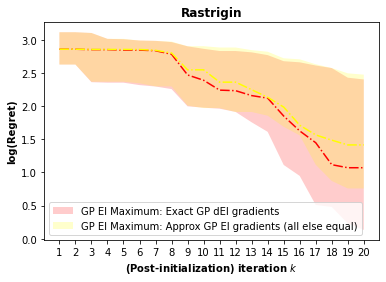

In [145]:
### Visualise!

title = func
plt.figure()

plt.plot(median_ExactSimpleRegret_exact, color = 'Red', ls='-.')
plt.plot(median_ApproxSimpleRegret_exact, color = 'Yellow', ls='-.')

xstar = np.arange(0, iters, step=1)
plt.fill_between(xstar, lower_ExactSimpleRegret_exact, upper_ExactSimpleRegret_exact, facecolor = 'Red', alpha=0.2, label='GP EI Maximum: Exact GP dEI gradients')
plt.fill_between(xstar, lower_ApproxSimpleRegret_exact, upper_ApproxSimpleRegret_exact, facecolor = 'Yellow', alpha=0.2, label='GP EI Maximum: Approx GP EI gradients (all else equal)')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialization) iteration $\it{k}$', weight = 'bold')
plt.ylabel('log(Regret)', weight = 'bold') 
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show() #visualize!